# EYE FOR BLIND

In [1]:
#Import all the required libraries
import glob
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from collections import Counter
import numpy as np
import tensorflow as tf
from tensorflow.keras import Model,layers
import skimage.transform
from tqdm import tqdm
import time

Let's read the dataset

## Data understanding
1.Import the dataset and read image & captions into two seperate variables

2.Visualise both the images & text present in the dataset

3.Create word-to-index and index-to-word mappings.

4.Create a dataframe which summarizes the image, path & captions as a dataframe

5.Visualise the top 30 occuring words in the captions

6.Create a list which contains all the captions & path


In [2]:
caption_file = 'captions.txt' # '/kaggle/input/flickr8k/captions.txt'
images_folder= 'Images/' # '/kaggle/input/flickr8k/Images/'
output_folder = 'outputData/' # '/kaggle/working/outputData/'

In [3]:
caption = pd.read_csv(caption_file)
caption.head(10)

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...
5,1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting
6,1001773457_577c3a7d70.jpg,A black dog and a tri-colored dog playing with...
7,1001773457_577c3a7d70.jpg,A black dog and a white dog with brown spots a...
8,1001773457_577c3a7d70.jpg,Two dogs of different breeds looking at each o...
9,1001773457_577c3a7d70.jpg,Two dogs on pavement moving toward each other .


In [4]:
from os import walk

_, _, filenames = next(walk(images_folder))

In [5]:
filenames[:10]

['3226254560_2f8ac147ea.jpg',
 '214543992_ce6c0d9f9b.jpg',
 '2366643786_9c9a830db8.jpg',
 '3368819708_0bfa0808f8.jpg',
 '2190227737_6e0bde2623.jpg',
 '2752809449_632cd991b3.jpg',
 '3097776588_312932e438.jpg',
 '1206506157_c7956accd5.jpg',
 '1319634306_816f21677f.jpg',
 '2465218087_fca77998c6.jpg']

In [6]:
#Import the dataset and read the image into a seperate variable
print("The total images present in the dataset: {}".format(len(filenames)))

The total images present in the dataset: 8091


In [7]:
image_caption_dict = {}
for index in caption.index:
    image_caption_dict[caption['image'][index]] = caption['caption'][index]

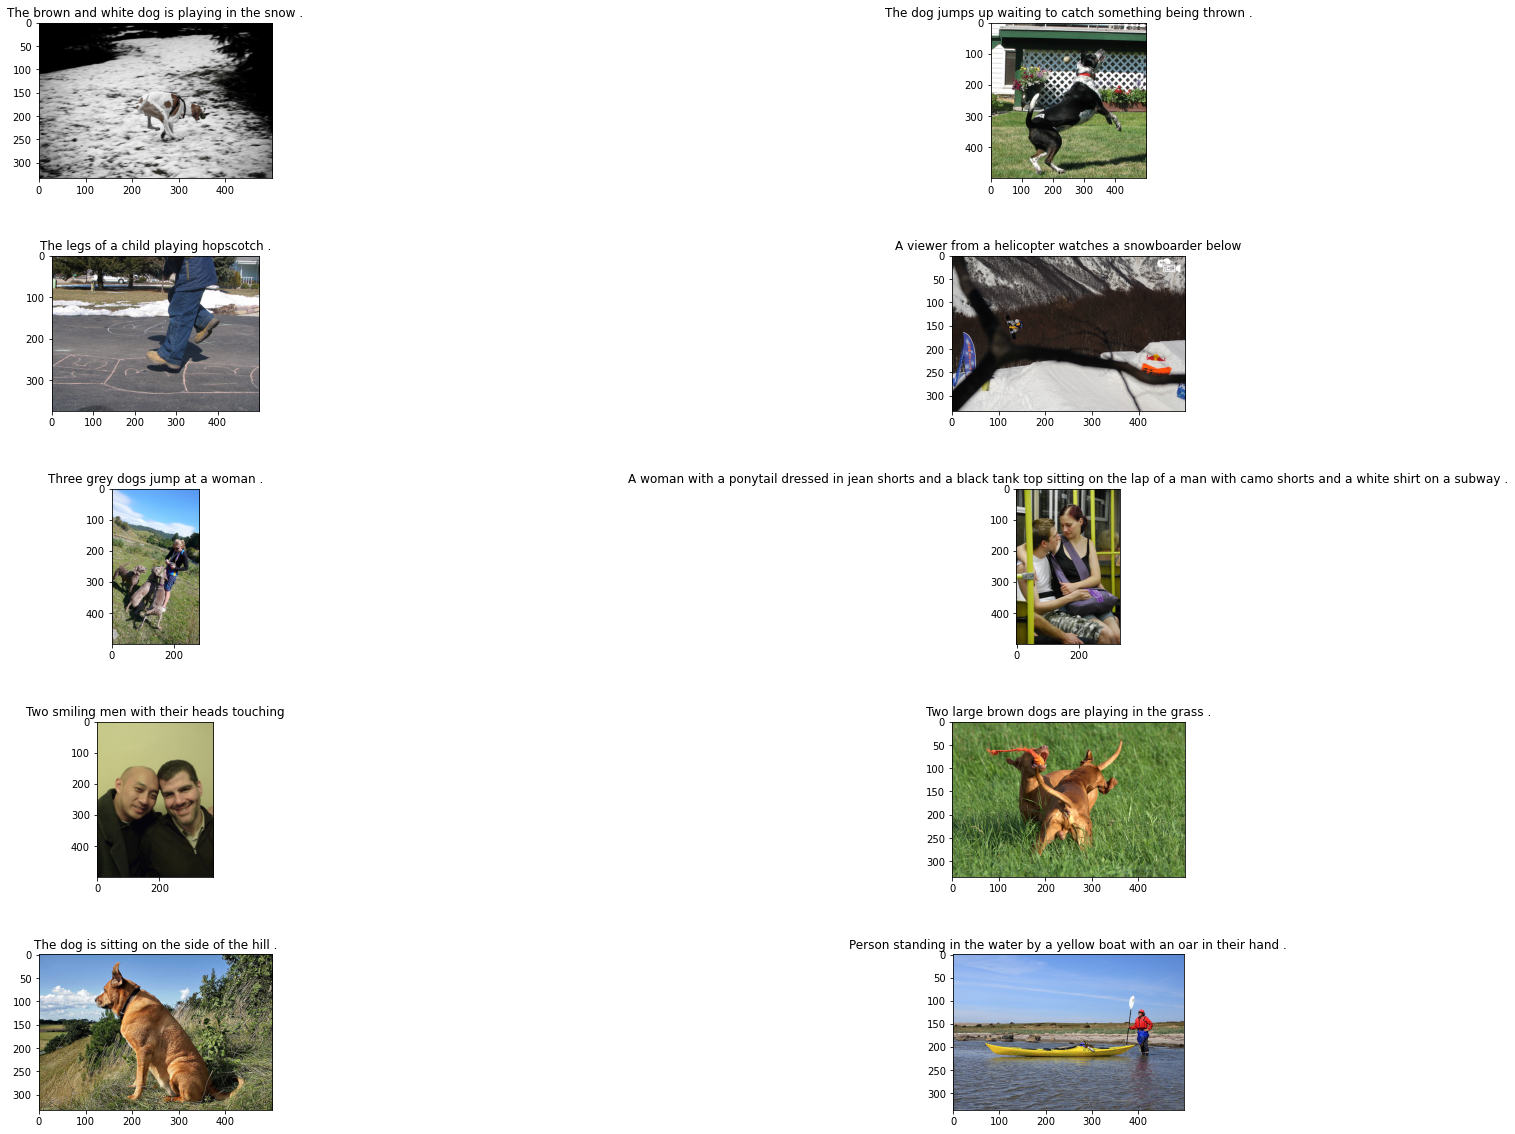

In [8]:
i = -1
fig, axs = plt.subplots(5,2, figsize=(30,20), gridspec_kw={'hspace': 0.5})
for eachAxs in axs:
    for eachCol in eachAxs:
        i+= 1
        img = mpimg.imread(images_folder+filenames[i])
        eachCol.imshow(img)
        eachCol.set_title(image_caption_dict[filenames[i]])

Create a dataframe which summarizes the image, path & captions as a dataframe

Each image id has 5 captions associated with it therefore the total dataset should have 40455 samples.

In [9]:
all_img_id = [raw[0] for raw in caption['image'].str.split('.')]#store all the image id here
all_img_vector = images_folder + caption['image']#store all the image path here
annotations = caption['caption']#store all the captions here

df = pd.DataFrame(list(zip(all_img_id, all_img_vector,annotations)),columns =['ID','Path', 'Captions']) 
    
df.head(10)

,ID,Path,Captions
0,1000268201_693b08cb0e,/kaggle/input/flickr8k/Images/1000268201_693b0...,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e,/kaggle/input/flickr8k/Images/1000268201_693b0...,A girl going into a wooden building .
2,1000268201_693b08cb0e,/kaggle/input/flickr8k/Images/1000268201_693b0...,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e,/kaggle/input/flickr8k/Images/1000268201_693b0...,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e,/kaggle/input/flickr8k/Images/1000268201_693b0...,A little girl in a pink dress going into a woo...
5,1001773457_577c3a7d70,/kaggle/input/flickr8k/Images/1001773457_577c3...,A black dog and a spotted dog are fighting
6,1001773457_577c3a7d70,/kaggle/input/flickr8k/Images/1001773457_577c3...,A black dog and a tri-colored dog playing with...
7,1001773457_577c3a7d70,/kaggle/input/flickr8k/Images/1001773457_577c3...,A black dog and a white dog with brown spots a...
8,1001773457_577c3a7d70,/kaggle/input/flickr8k/Images/1001773457_577c3...,Two dogs of different breeds looking at each o...
9,1001773457_577c3a7d70,/kaggle/input/flickr8k/Images/1001773457_577c3...,Two dogs on pavement moving toward each other .


In [10]:
#Create the vocabulary & the counter for the captions
vocabulary= str.split(df['Captions'].str.cat(sep=' '))#write your code here
val_count=Counter(vocabulary)
list(val_count.items())[:20]

[('A', 22667),
 ('child', 1477),
 ('in', 18962),
 ('a', 40319),
 ('pink', 734),
 ('dress', 348),
 ('is', 9345),
 ('climbing', 502),
 ('up', 1260),
 ('set', 108),
 ('of', 6712),
 ('stairs', 109),
 ('an', 1945),
 ('entry', 1),
 ('way', 50),
 ('.', 36577),
 ('girl', 3218),
 ('going', 149),
 ('into', 1074),
 ('wooden', 284)]

<AxesSubplot:xlabel='Word'>

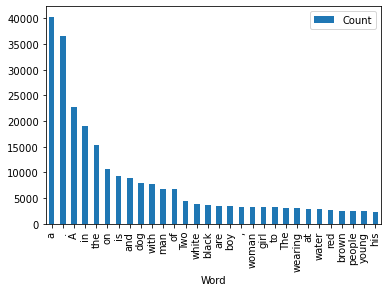

In [11]:
#Visualise the top 30 occuring words in the captions
lst = val_count.most_common(30)
wordCount = pd.DataFrame(lst, columns = ['Word', 'Count'])
wordCount.plot.bar(x='Word',y='Count')

In [12]:
#Create a list which contains all the captions
#add the <start> & <end> token to all those captions as well
annotations= ["<start> "+caption+" <end>" for caption in df['Captions']]
#Create a list which contains all the path to the images
all_img_path=set(df['Path'])#write your code here

print("Total captions present in the dataset: "+ str(len(annotations)))
print("Total images present in the dataset: " + str(len(all_img_path)))

Total captions present in the dataset: 40455
Total images present in the dataset: 8091


## Pre-Processing the captions
1.Create the tokenized vectors by tokenizing the captions fore ex :split them using spaces & other filters. 
This gives us a vocabulary of all of the unique words in the data. Keep the total vocaublary to top 5,000 words for saving memory.

2.Replace all other words with the unknown token "UNK" .

3.Create word-to-index and index-to-word mappings.

4.Pad all sequences to be the same length as the longest one.

###### Preprocess text using tf.tokenizer

In [13]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(
    num_words=5000,
    filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n',
    lower=True, split=' ', char_level=False, oov_token="<unk>"
)

In [14]:
tokenizer.fit_on_texts(annotations)
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

In [15]:
cap_seqs = tokenizer.texts_to_sequences(annotations)
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(cap_seqs, padding='post')

In [16]:
max_length = max(len(t) for t in cap_seqs)
max_length

39

In [17]:
for i in range(0,10):
    print(i," : ",tokenizer.index_word[i])

0  :  <pad>
1  :  <unk>
2  :  a
3  :  <start>
4  :  <end>
5  :  in
6  :  the
7  :  on
8  :  is
9  :  and


In [18]:
sorted_by_word_count = sorted(tokenizer.word_counts.items(), key=lambda kv: kv[1], reverse=True)
sorted_by_word_count[:10]

[('a', 62992),
 ('<start>', 40455),
 ('<end>', 40455),
 ('in', 18986),
 ('the', 18419),
 ('on', 10745),
 ('is', 9345),
 ('and', 8862),
 ('dog', 8138),
 ('with', 7765)]

<AxesSubplot:xlabel='Word'>

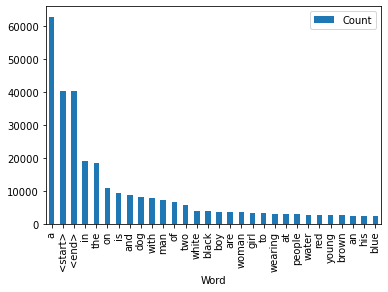

In [19]:
wordCount = pd.DataFrame(sorted_by_word_count[:30], columns = ['Word', 'Count'])
wordCount.plot.bar(x='Word',y='Count')

## Load the pretrained Imagenet weights of Inception net V3

1.To save the memory(RAM) from getting exhausted, extract the features of the image using the last layer of pre-trained model. Including this as part of training will lead to higher computational time.

2.The shape of the output of this layer is 8x8x2048. 

3.Use a function to extract the features of each image in the train & test dataset such that the shape of each image should be (batch_size, 8*8, 2048)



In [20]:
image_model = tf.keras.applications.InceptionV3(include_top=False,weights='imagenet', input_shape=(299,299,3))

87916544/87910968 [==============================] - 1s 0us/step


In [21]:
new_input = image_model.inputs       #write code here to get the input of the image_model
hidden_layer = image_model.layers[-1].output    #write code here to get the output of the image_model

image_features_extract_model = Model(inputs=new_input, outputs=hidden_layer)#build the final model using both input & output layer

In [22]:
image_features_extract_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

## Pre-processing the images

1.Resize them into the shape of (299, 299)

3.Normalize the image within the range of -1 to 1, such that it is in correct format for InceptionV3. 

In [23]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

In [24]:
sorted_files = sorted(set(df['Path']))
sorted_files[:10]

['/kaggle/input/flickr8k/Images/1000268201_693b08cb0e.jpg',
 '/kaggle/input/flickr8k/Images/1001773457_577c3a7d70.jpg',
 '/kaggle/input/flickr8k/Images/1002674143_1b742ab4b8.jpg',
 '/kaggle/input/flickr8k/Images/1003163366_44323f5815.jpg',
 '/kaggle/input/flickr8k/Images/1007129816_e794419615.jpg',
 '/kaggle/input/flickr8k/Images/1007320043_627395c3d8.jpg',
 '/kaggle/input/flickr8k/Images/1009434119_febe49276a.jpg',
 '/kaggle/input/flickr8k/Images/1012212859_01547e3f17.jpg',
 '/kaggle/input/flickr8k/Images/1015118661_980735411b.jpg',
 '/kaggle/input/flickr8k/Images/1015584366_dfcec3c85a.jpg']

In [25]:
image_dataset = tf.data.Dataset.from_tensor_slices(sorted_files)

In [26]:
batch_size = 32

In [27]:
image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size)

In [28]:
!mkdir "outputData"

In [29]:
for batch_img, batch_path in tqdm(image_dataset):
    batch_features = image_features_extract_model(batch_img)
    batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))
    for img, path in zip(batch_features, batch_path):
        path_of_feature = path.numpy().decode("utf-8")
        path_of_feature = path_of_feature.replace(images_folder,output_folder).replace(".jpg","")
        np.save(path_of_feature, img.numpy())

100%|██████████| 253/253 [00:59<00:00,  4.28it/s]


In [30]:
_, _, numpy_files = next(walk(output_folder))
numpy_files[:10]

['3288174272_2daa06d360.npy',
 '3114944484_28b5bb9842.npy',
 '2839807428_efe42423f2.npy',
 '3590593467_be497a6139.npy',
 '576093768_e78f91c176.npy',
 '890734502_a5ae67beac.npy',
 '468102269_135938e209.npy',
 '280932151_ae14a67be5.npy',
 '2420546021_4a59790da6.npy',
 '109823394_83fcb735e1.npy']

In [31]:
len(numpy_files)

8091

## Create the train & test data 
1.Combine both images & captions to create the train & test dataset using tf.data.Dataset API. Create the train-test spliit using 80-20 ratio & random state = 42

2.Make sure you have done Shuffle and batch while building the dataset

3.The shape of each image in the dataset after building should be (batch_size, 299, 299, 3)

4.The shape of each caption in the dataset after building should be(batch_size, max_len)


In [32]:
batch_size = 32
total_size = df.shape[0]

In [33]:
#write your code here
AUTOTUNE = tf.data.experimental.AUTOTUNE

total_dataset = tf.data.Dataset.from_tensor_slices((df['ID'], cap_vector))

In [34]:
# Load the numpy files
def map_func(img_name, cap):
    img_tensor = np.load(output_folder+img_name.decode('utf-8')+'.npy')
    return img_tensor, cap

In [35]:
total_dataset = total_dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]), num_parallel_calls=tf.data.AUTOTUNE)

In [36]:
total_dataset = total_dataset.shuffle(buffer_size=1000, seed=42)

In [37]:
train_size = total_size*0.7

In [38]:
train_dataset = total_dataset.take(round(train_size))
test_dataset = total_dataset.skip(round(train_size))

In [39]:
train_dataset = train_dataset.batch(batch_size,drop_remainder=True).prefetch(buffer_size=AUTOTUNE)

test_dataset = test_dataset.batch(batch_size,drop_remainder=True).prefetch(buffer_size=AUTOTUNE)

In [40]:
sample_img_batch, sample_cap_batch = next(iter(train_dataset)) #train_dataset.take(1)

In [41]:
print(sample_img_batch.shape) #(batch_size, 299, 299, 3)
print(sample_cap_batch.shape) #(batch_size, max_len)

(32, 64, 2048)
(32, 39)


## Model Building
1.Set the parameters

2.Build the Encoder, Attention model & Decoder

In [42]:
embedding_dim = 256 
units = 512
vocab_size = 5001 #top 5,000 words +1
train_num_steps = train_size//batch_size #len(total train images) // BATCH_SIZE
test_num_steps = (total_size-train_size)//batch_size #len(total test images) // BATCH_SIZE
attention_features_shape = 5

### Encoder

In [43]:
class Encoder(Model):
    def __init__(self,embed_dim):
        super(Encoder, self).__init__()
        self.flatten = layers.Flatten()
        self.dense = layers.Dense(embed_dim)#build your Dense layer with relu activation
        
    def call(self, features):
        faltten = self.flatten(features)
        features =  tf.nn.relu(self.dense(faltten))# extract the features from the image shape: (batch, 8*8, embed_dim)
        
        return features

In [44]:
encoder=Encoder(embedding_dim)

### Attention model

In [45]:
class Attention_model(Model):
    def __init__(self, units):
        super(Attention_model, self).__init__()
        self.W1 = layers.Dense(units)#build your Dense layer
        self.W2 = layers.Dense(units)#build your Dense layer
        self.V = layers.Dense(1)#build your final Dense layer with unit 1
        self.units=units

    def call(self, features, hidden):
        #features shape: (batch_size, 8*8, embedding_dim)
        # hidden shape: (batch_size, hidden_size)
        hidden_with_time_axis = tf.expand_dims(hidden, axis=1)
        #print("hidden_with_time_axis: ",hidden_with_time_axis.shape)
        #hidden_with_time_axis =  np.reshape(hidden, (hidden.shape[0],1,hidden.shape[1]))# Expand the hidden shape to shape: (batch_size, 1, hidden_size)
        score = self.V(tf.nn.tanh(self.W1(features)+self.W2(hidden_with_time_axis)))# build your score funciton to shape: (batch_size, 8*8, units)
        attention_weights =  tf.nn.softmax(score, axis=1)# extract your attention weights with shape: (batch_size, 8*8, 1)
        context_vector =  features * attention_weights#shape: create the context vector with shape (batch_size, 8*8,embedding_dim)
        #print("type: ", type(context_vector))
        #print("context_vector before: ",context_vector.shape)
        context_vector = tf.math.reduce_sum(context_vector, axis=1)
        #context_vector = context_vector.sum(dim=1)# reduce the shape to (batch_size, embedding_dim)
        

        return context_vector, attention_weights

### Decoder

In [46]:
class Decoder(Model):
    def __init__(self, embed_dim, units, vocab_size):
        super(Decoder, self).__init__()
        self.units=units
        self.attention = Attention_model(units)#iniitalise your Attention model with units
        self.embed = layers.Embedding(vocab_size, embed_dim)#build your Embedding layer
        self.gru = tf.keras.layers.GRU(self.units,return_sequences=True,return_state=True,recurrent_initializer='glorot_uniform')
        self.d1 = layers.Dense(embed_dim)#build your Dense layer
        self.d2 = layers.Dense(vocab_size)#build your Dense layer
        

    def call(self,x,features, hidden):
        context_vector, attention_weights = self.attention(features,hidden)#create your context vector & attention weights from attention model
        embed =  self.embed(x)# embed your input to shape: (batch_size, 1, embedding_dim)
        #print("embed: ",embed.shape)
        #print("context_vector: ",context_vector.shape)
        context_vector = tf.expand_dims(context_vector, axis=1)
        #print("context_vector after expanding: ",context_vector.shape)
        embed =  tf.concat([context_vector, embed], -1)# Concatenate your input with the context vector from attention layer. Shape: (batch_size, 1, embedding_dim + embedding_dim)
        output,state = self.gru(embed)# Extract the output & hidden state from GRU layer. Output shape : (batch_size, max_length, hidden_size)
        output = self.d1(output)
        output = tf.reshape(output, (-1, output.shape[2])) # shape : (batch_size * max_length, hidden_size)
        output = self.d2(output) # shape : (batch_size * max_length, vocab_size)
        
        return output,state, attention_weights
    
    def init_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [47]:
decoder=Decoder(embedding_dim, units, vocab_size)

In [48]:
features=encoder(sample_img_batch)

hidden = decoder.init_state(batch_size=sample_cap_batch.shape[0])
dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * sample_cap_batch.shape[0], 1)

predictions, hidden_out, attention_weights= decoder(dec_input, features, hidden)
print('Feature shape from Encoder: {}'.format(features.shape))
print('Predcitions shape from Decoder: {}'.format(predictions.shape))
print('Attention weights shape from Decoder: {}'.format(attention_weights.shape))

Feature shape from Encoder: (32, 256)
Predcitions shape from Decoder: (32, 5001)
Attention weights shape from Decoder: (32, 32, 1)


## Model training & optimization
1.Set the optimizer & loss object

2.Create your checkpoint path

3.Create your training & testing step functions

4.Create your loss function for the test dataset

In [49]:
optimizer = tf.keras.optimizers.Adam()#define the optimizer
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')#define your loss object

In [50]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [51]:
checkpoint_path = "./checkpoint" #"your checkpoint path"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [52]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])

In [53]:
@tf.function
def train_step(img_tensor, target):
    loss = 0
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    
    with tf.GradientTape() as tape:
        #write your code here to do the training steps
        features = encoder(img_tensor)
        #print("target: ",target)
        for i in range(1, target.shape[1]):
            # passing the features through the decoder
            predictions, hidden, _ = decoder(dec_input, features, hidden)
            loss += loss_function(target[:, i], predictions)
            
            # using teacher forcing
            dec_input = tf.expand_dims(target[:, i], 1)
            
        avg_loss = (loss / int(target.shape[1]-1))
        
        trainable_variables = encoder.trainable_variables + decoder.trainable_variables
        
        gradients = tape.gradient(loss, trainable_variables)
        
        optimizer.apply_gradients(zip(gradients, trainable_variables))
        
    return loss, avg_loss

In [54]:
@tf.function
def test_step(img_tensor, target):
    loss = 0
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    features = encoder(img_tensor)
    
    #write your code here to do the testing steps
    for i in range(1, target.shape[1]):
        predictions, hidden, _ = decoder(dec_input, features, hidden)
        loss += loss_function(target[:, i], predictions)
        #print("dec_input: ",dec_input)
        #print("predictions: ",predictions)
        predictions = tf.random.categorical(predictions, 1)
        #print("predictions-2 : ",predictions)
        dec_input = predictions
        
    avg_loss = (loss / int(target.shape[1]-1))
        
    return loss, avg_loss

In [55]:
def test_loss_cal(test_dataset):
    total_loss = 0

    #write your code to get the average loss result on your test data
    for (img_tensor, target) in test_dataset:
        #print("img_tensor : ", img_tensor.shape)
        #print("target : ",target)
        _, avg_loss = test_step(img_tensor, target)
        #print("avg_loss: ",avg_loss)
        total_loss+=avg_loss
    
    avg_test_loss = (total_loss/len(test_dataset))
    return avg_test_loss

In [56]:
print("train_num_steps: ",train_num_steps)
print("len(train_dataset): ",len(train_dataset))

train_num_steps:  884.0
len(train_dataset):  884


In [59]:
loss_plot = []
test_loss_plot = []
EPOCHS = 20

best_test_loss=100
for epoch in range(0, EPOCHS):
    print("Epoch: ",epoch+1)
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(train_dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss
        
    avg_train_loss=total_loss / train_num_steps
    loss_plot.append(avg_train_loss)    
    test_loss = test_loss_cal(test_dataset)
    test_loss_plot.append(test_loss)
    
    print ('For epoch: {}, the train loss is {:.3f}, & test loss is {:.3f}'.format(epoch+1,avg_train_loss,test_loss))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
    
    if test_loss < best_test_loss:
        print('Test loss has been reduced from %.3f to %.3f' % (best_test_loss, test_loss))
        best_test_loss = test_loss
        ckpt_manager.save()

Epoch:  1
For epoch: 1, the train loss is 1.637, & test loss is 1.699
Time taken for 1 epoch 129.87701058387756 sec

Test loss has been reduced from 100.000 to 1.699
Epoch:  2
For epoch: 2, the train loss is 1.636, & test loss is 1.689
Time taken for 1 epoch 129.40129232406616 sec

Test loss has been reduced from 1.699 to 1.689
Epoch:  3
For epoch: 3, the train loss is 1.635, & test loss is 1.690
Time taken for 1 epoch 129.2587652206421 sec

Epoch:  4
For epoch: 4, the train loss is 1.635, & test loss is 1.689
Time taken for 1 epoch 129.50320768356323 sec

Test loss has been reduced from 1.689 to 1.689
Epoch:  5
For epoch: 5, the train loss is 1.635, & test loss is 1.690
Time taken for 1 epoch 129.0962631702423 sec

Epoch:  6
For epoch: 6, the train loss is 1.635, & test loss is 1.702
Time taken for 1 epoch 129.9268672466278 sec

Epoch:  7
For epoch: 7, the train loss is 1.636, & test loss is 1.690
Time taken for 1 epoch 129.18394351005554 sec

Epoch:  8
For epoch: 8, the train loss is

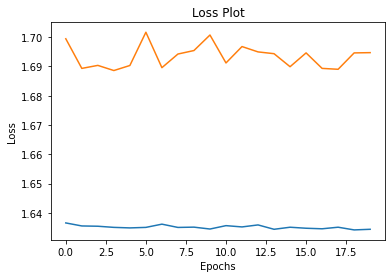

In [65]:
plt.plot(loss_plot, label='Training Loss')
plt.plot(test_loss_plot, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.legend()
plt.show()

## Model Evaluation
1.Define your evaluation function using greedy search

2.Define your evaluation function using beam search ( optional)

3.Test it on a sample data using BLEU score

### Greedy Search

In [61]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))
    hidden = decoder.init_state(batch_size=1)

    #temp_input = tf.expand_dims(load_image(image)[0], 0) #process the input image to desired format before extracting features
    #temp_input = tf.expand_dims(image, 0)
    #img_tensor_val = image_features_extract_model.predict(temp_input)# Extract features using our feature extraction model
    #img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(image)# extract the features by passing the input to encoder

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)# get the output from decoder

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()#extract the predicted id(embedded value) which carries the max value
        result.append(tokenizer.index_word[predicted_id])#map the id to the word from tokenizer and append the value to the result list

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot,predictions

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot,predictions


In [64]:
for img_list, capt_vec in test_dataset:
    capt_list = tokenizer.sequences_to_texts(capt_vec.numpy())
    for img, capt in zip(img_list, capt_list):
        capt = [word for word in capt.split() if word!='<pad>']
        temp_input = tf.expand_dims(img, 0)
        result, attention_plot,predictions = evaluate(temp_input)
        separator = ' '
        print("Predicted: ", separator.join(result))
        print("Actual: ", separator.join(capt),"\n")

Predicted:  running with in intently play tree a woman people dark silly a a do field a mountain of wooden dog yellow eyes are a in one his a a front a <end>
Actual:  <start> a child stands in the snow <end> 

Predicted:  playing t of a snow haired after sidelines over swing on are <end>
Actual:  <start> a girl in a pink outfit looks through luggage in a tent city <end> 

Predicted:  while at up other cars are rappels the taking a in the three a middle mouth red is five in are ball children a and kicking dalmation jump a young is headphones 281 suit slope a watching five asian
Actual:  <start> a boy rides his bike on a half pipe <end> 

Predicted:  of performs over occupied group a water ball on knee is paint <end>
Actual:  <start> a girl is hanging on the fence watching a horse <end> 

Predicted:  on red <end>
Actual:  <start> the goalie has come out of the goal to <unk> the puck from the other team <end> 

Predicted:  on is field stick sitting a face a a is walking in dogs race <end>

Predicted:  leads and as person have <end>
Actual:  <start> three baseball players in motion one sliding into a base another running in the background <end> 

Predicted:  <unk> stick gets of selling street a in ball in with frying in a wide crooked carrying a in poster lunchbox giant banner in on in a striped <end>
Actual:  <start> a dog runs on the beach near a city <end> 

Predicted:  board people carrying in rider <end>
Actual:  <start> field hockey players in red and blue with one player taking a fall <end> 

Predicted:  runs woman a graffiti the <end>
Actual:  <start> an old woman is holding a large white dog tightly while sitting in a large red chair in front of some electronics <end> 

Predicted:  wave is and priest <unk> has bright white soccer mouths are two field street man on machine people through river a white alley room overpass beach yard through spikes black field three road a down streets man cheerleaders white
Actual:  <start> a dog running through a creek <end> 

Pre

Predicted:  with toward ball pink a grass <end>
Actual:  <start> a black and white dog is running on sand <end> 

Predicted:  with down a on with amidst background on to being of children surface boy of swan to striped rail in velvet marx little big a area a a boy piece in the field <unk> into two shirt man of
Actual:  <start> players in red uniforms on the bench during a hockey game <end> 

Predicted:  two grinding in a at is lab headphones a playing white a dirt wearing dressed and holding sitting on dog <unk> performs sitting grass and a in green pool running pool court a <end>
Actual:  <start> a little girl plays with a plane <end> 

Predicted:  in sidewalk dance hits is small a girl wearing <end>
Actual:  <start> a group of young women doing in matching teal outfits doing a dance <end> 

Predicted:  man walk wall off a the racquet four hangs uses four stream rider a mess all it a a dirt skateboarding mug boots <end>
Actual:  <start> a blonde woman wearing a white top and black bot

Predicted:  two rocky sidewalk little two unique piano five up a sliding in on and rolled a stroller as sitting a a blue tongue the player are red water shore holding rides a shirt a path wearing wooden jumping player
Actual:  <start> a dog runs through shallow water <end> 

Predicted:  picture freshly the in of huts woman body birds a <end>
Actual:  <start> child slides down green plastic tubular slide <end> 

Predicted:  sitting at cat down a and dry indoor park colorful <end>
Actual:  <start> four boys playing a game with a soccer ball in front of a large set of ornate doors <end> 

Predicted:  of people girl toddler <end>
Actual:  <start> a little girl in a <unk> jacket holds a stuffed animal and smiles <end> 

Predicted:  girls the a crawls front the with on race and him curve cat dirt photograph a of jump a the dark black <end>
Actual:  <start> a woman with a red scarf covering her head walks with her cat on snow covered ground <end> 

Predicted:  down two and a dogs bicyclist th

Predicted:  <unk> his in an dog sunglasses a is street ski <unk> at backpack <end>
Actual:  <start> a woman and two young men standing close to one another <end> 

Predicted:  a black the <end>
Actual:  <start> man on bike with female standing on rear of back with arms around his neck <end> 

Predicted:  the dogs in racket white down the bride and children bike photograph a white jacket of air <end>
Actual:  <start> a man doing a jump on a snowboard <end> 

Predicted:  in through white crowded grass refreshment blue side standing brown front road in small black <end>
Actual:  <start> a man is standing behind and desk and there is part of a red car hanging above his head <end> 

Predicted:  in front man painted large <end>
Actual:  <start> the boy is wearing blue sunglasses and jumping by a yellow rail <end> 

Predicted:  rainbow dirt <end>
Actual:  <start> two girls play on a set of parallel bars <end> 

Predicted:  a a sits a in a a wearing yellow group a sits them <unk> enjoying <end

Predicted:  bikini a boy on of outside in dog to red laying it smiles a a a beach a a blue <unk> hand flies on a the a skateboard man in hill boy covered is playground <end>
Actual:  <start> a large dog is laying on its back outside on a blacktop with its legs in the air <end> 

Predicted:  are a fight to the dog the little up jump a a <end>
Actual:  <start> a person in a white helmet is standing next to a ladder <end> 

Predicted:  their playing running to a the the <end>
Actual:  <start> a crowded city street <end> 

Predicted:  into <unk> through playing <end>
Actual:  <start> a brown dog in a pink shirt chews something white while a brown dog in yellow watches <end> 

Predicted:  a ground bike runs sits in white a touches her across hat in a onto stand a <end>
Actual:  <start> a boy helps to push a young girl on the swing <end> 

Predicted:  field hiker is on a woman with of in two cheerleaders green with a black costumes from watching people is shirtless runs play two <end>
Actual

Predicted:  around dirt ear eyes holding moving down a blue the tunnel snow road up raises a practicing <end>
Actual:  <start> the crowd is gathering for an event at <unk> buy <end> 

Predicted:  a legs skating wearing of black of dog shirt is furry run with on in people black player at in gathering shirt hill runs runs at waterskiing girl a <end>
Actual:  <start> two bmx riders racing on a track <end> 

Predicted:  on <end>
Actual:  <start> a child in white and pink is picking a white flowered tree next to a fence <end> 

Predicted:  a trail <end>
Actual:  <start> a man wearing a blue shirt kicks a soccer ball along a green field <end> 

Predicted:  black <end>
Actual:  <start> a woman leaning over to help a child in a stroller with a man laying down on a park bench and another sitting on a bench <end> 

Predicted:  a while children a <end>
Actual:  <start> a man in a green shirt rides a bike in the woods <end> 

Predicted:  of a top in agility leather <end>
Actual:  <start> a dog lay

Predicted:  leaps <unk> dog their midair running 's the young diver of another a on a <unk> shirt cliff a the <end>
Actual:  <start> a dog is lying in the grass with a body of water beside him <end> 

Predicted:  with his watch glasses sitting a outside black a a wearing volleyball brown <end>
Actual:  <start> a snowboarder jumping over a road <unk> <end> 

Predicted:  a man fisherman snowsuit ski a man <unk> player of a helmet class jacket lady shirt basketball a some is swing <end>
Actual:  <start> a woman wearing a light blue coat looks to the left while a man looks to the right <end> 

Predicted:  a posing canned through <end>
Actual:  <start> a man on a bike is riding on a trail through the woods in the fall <end> 

Predicted:  and a runs looks has tennis beach dog over shirt <end>
Actual:  <start> men are dressed in soccer uniforms <end> 

Predicted:  view baby man a sign <end>
Actual:  <start> a man in a suit is taking a <unk> of something while walking outdoors <end> 

Predicte

Predicted:  children in jumps the man catching shirt to in <end>
Actual:  <start> two children playing baseball at the park <end> 

Predicted:  older tricks helicopter are a and <unk> a down pink standing <end>
Actual:  <start> a group of men stand outside a glass and steel building <end> 

Predicted:  the a a being grass girl two <unk> tan <end>
Actual:  <start> three children are sitting on the top of a staircase <end> 

Predicted:  and <end>
Actual:  <start> two men are sitting in chairs in front of a building while a group of people climb a set of steps <end> 

Predicted:  a <end>
Actual:  <start> a man in glasses is sitting behind a table laden with military <unk> <end> 

Predicted:  asleep on in <end>
Actual:  <start> a woman wearing a pink shirt jumps in the air with her arms and legs spread to her sides <end> 

Predicted:  <end>
Actual:  <start> girls in light blue outfits perform a <unk> dance <end> 

Predicted:  in is black in over skiiers a next over <end>
Actual:  <start> a

Predicted:  older gated dog a lift dog 4 on dog and rubs and tan are raft <end>
Actual:  <start> a bull is charging a man in an arena <end> 

Predicted:  <end>
Actual:  <start> a woman with a stroller is passing a man walking a dog <end> 

Predicted:  women two standing watching a man there dogs a bag throwing <end>
Actual:  <start> a small black dog playing with a ball in the grass <end> 

Predicted:  girls of children line <end>
Actual:  <start> catcher on the ground runner making base <end> 

Predicted:  a a ball a <unk> ball three mets rest flags to base snow in through shirt its ground are beach downhill dog walking running tent man of his and <end>
Actual:  <start> a person on a bike is riding through a rocky trail in the woods <end> 

Predicted:  player <end>
Actual:  <start> racing car marked team penske on track banners and spectators in background <end> 

Predicted:  tan costume a flies men <end>
Actual:  <start> a climber with a blue hat is scaling an icy rock cliff <end> 



Predicted:  is scarf are a as of that up court on sitting walk climb dirt skis teenagers surf boys while riding jumping sits riding two a shirt sunglasses outside by wearing in striped <end>
Actual:  <start> two motorcyclists are making a turn in a race one with a red themed outfit and bike the other in black <end> 

Predicted:  a a brown snow a him <end>
Actual:  <start> a girl with a pink hat is climbing a playground wall <end> 

Predicted:  car holding field on a faces ramp is toy dog a older playing sidewalk playing people with dogs <end>
Actual:  <start> a young blonde woman in a blue and white tracksuit jumps a hurdle <end> 

Predicted:  a shows <end>
Actual:  <start> a boy with a mohawk chasing geese in a park <end> 

Predicted:  <end>
Actual:  <start> a runner slides into second base while the <unk> waits for the ball <end> 

Predicted:  woman black an with and on ball a <end>
Actual:  <start> two young kids putting their heads in the bodies of a <unk> and queen <end> 

Predict

Predicted:  a white <end>
Actual:  <start> boys play ball in the dirt <end> 

Predicted:  a group asian between rock swimming and skateboarder a striped shore all rolling crowd three rope to begging of through riding innertube the <end>
Actual:  <start> the brown and white dog is jumping over a high wire fence <end> 

Predicted:  with a ramp bike <end>
Actual:  <start> three women are dressed in costumes while one holds an umbrella <end> 

Predicted:  a swings woman holds field white wood men a in in fight on in plush <end>
Actual:  <start> a person with a helmet and <unk> on is riding a motorcycle in the dirt <end> 

Predicted:  tennis boy covering hand a pushing white a down <end>
Actual:  <start> a little girl in a pink hat sniffing a white flower <end> 

Predicted:  in the grass older two a a a players his track end people choir teeth man ball white in <end>
Actual:  <start> a boy <unk> with a <unk> racket in his backyard <end> 

Predicted:  over snow splash between of people the i

Predicted:  edge a sidewalk converse woman <end>
Actual:  <start> the man in jeans is sitting by the river with large fish <end> 

Predicted:  children around large women field in young under in bunch a swim his policemen <end>
Actual:  <start> a girl in a red dress is surrounded by a lot of other people holding their hands up <end> 

Predicted:  people playing <end>
Actual:  <start> a blond boy slides down a sand dune on a skateboard with no wheels <end> 

Predicted:  and brown and doing <end>
Actual:  <start> the skier is going down a large mountain <end> 

Predicted:  beach and <end>
Actual:  <start> a teammate helps another teammate off of the field <end> 

Predicted:  rock <end>
Actual:  <start> a man and woman are riding scooters through a field of grass and clover <end> 

Predicted:  of on in house older skirt man dark field in people racquet on <end>
Actual:  <start> some young men playing basketball <end> 

Predicted:  sitting bathing playing riding sun a <end>
Actual:  <start

Predicted:  hula child a in dirt a is are a art carnival to one of table bike <unk> a to this people dogs on <end>
Actual:  <start> a man poses for a little girl his arms outstretched with a large church in the background <end> 

Predicted:  people bench to skirt white harness a black children a rolled running in spreads front her climber a bottoms ball to <end>
Actual:  <start> the man plays his guitar on the local streets <end> 

Predicted:  over hula through at <unk> t head glasses greyhound a <end>
Actual:  <start> two dogs race on a track <end> 

Predicted:  splashed <end>
Actual:  <start> two dogs race across a field on a sunny day <end> 

Predicted:  homeless a brown red trail jumps <end>
Actual:  <start> two dancers each wearing black outfits with <unk> in midair <end> 

Predicted:  he cliff a play trail crowd an a man two two a gear of mountain on a blonde the a lining <unk> grassy officers doing area pants two a stand purple player <end>
Actual:  <start> a boy in a grey hat i

Predicted:  toy the a playground ocean on skateboarder standing skateboard through trying to arm <end>
Actual:  <start> there is a person in a green shirt riding a bike at an extreme angle in a rural area <end> 

Predicted:  together a dirt <end>
Actual:  <start> a crowd of people surrounding a woman in white wearing sunglasses <end> 

Predicted:  the high tennis body ball the people <end>
Actual:  <start> the large black dog is running on the sand near the beach <end> 

Predicted:  carpet children a playing she seashore a in long a rolled food with onto play blue throwing park gather watch <unk> smiling other a a grassy bike converse two <end>
Actual:  <start> a man is walking down a sidewalk under a lounge bar sign <end> 

Predicted:  yellow group huddle through wall looking car in red jumping man couple snow <end>
Actual:  <start> a guy playing tennis two nearby spectators and a crowd watching <end> 

Predicted:  in snow the front wearing running yellow a facing standing man running

Predicted:  two on eastern of dog on elegant run at car a four a face a kid a background a frog colored purple smiling six little car off grass is <end>
Actual:  <start> during a soccer game a boy in blue attempts to kick the ball <end> 

Predicted:  the rocky crowd jumping a airborne two water fighters his card <end>
Actual:  <start> there are three girls with head scarves in front of a worn down building and a family walking in the background <end> 

Predicted:  player with pinstripe wearing a skiing pose that and climber <end>
Actual:  <start> a man in green on a green bike is in the air after jumping off a ramp <end> 

Predicted:  and with in <end>
Actual:  <start> a woman writing while standing by men <end> 

Predicted:  with a on it brown a man green <end>
Actual:  <start> a man in a black wetsuit is surfing in the ocean <end> 

Predicted:  <end>
Actual:  <start> boy jumping over rail on bicycle while crowd watches <end> 

Predicted:  group play rocky grass couch <end>
Actual:  <

Predicted:  happily of building playing on beach on wearing a young a posing to near brown white white in coat are runs the big where are 's <end>
Actual:  <start> woman swinging above water while holding a vine <end> 

Predicted:  something racket motorcycle with small helmet of lunch swimming go cat player jumps in an green bright black the black <end>
Actual:  <start> a referee breaking up a fight during a hockey game <end> 

Predicted:  men observe outside a <end>
Actual:  <start> a white dog with brown marks jumps from the bank into the water <end> 

Predicted:  boy woman three rock <end>
Actual:  <start> two children swinging on a tire swing <end> 

Predicted:  the building an parking is tan white <end>
Actual:  <start> a brown dog leaps over a red ramp at an agility park <end> 

Predicted:  of skateboarder dogs road a a boy performs kitchen ball a into city carriage black skiing <end>
Actual:  <start> boy falling from railing with building colorful banners in background <end> 



Predicted:  between grass snow tennis the area home shorts green team along construction a mouth three cat ball is a a tennis the a dog enjoys shirt a <end>
Actual:  <start> a man in yellow performs a bike trick <end> 

Predicted:  jump girl two people to a on handing are a <end>
Actual:  <start> a dog swimming with a stick in its mouth <end> 

Predicted:  baseball the the red a on walk penske the of the <end>
Actual:  <start> a young girl with red hair is playing on a sidewalk with a swan <end> 

Predicted:  <end>
Actual:  <start> a dog wearing a jacket rolls in the snow <end> 

Predicted:  tee climbs <end>
Actual:  <start> two black dogs race for a ball on the shore <end> 

Predicted:  in spectators a and with from a onto man forward climbing posing <end>
Actual:  <start> a dirt bike racer jumps over a slope <end> 

Predicted:  white man ridden a woods wooden ball woods the ball ball sidewalk on flip play <end>
Actual:  <start> a man wearing blue rides a brown horse along a gravel pa

Predicted:  dog tan team black man is tree on climbing flaming two dog an jumping road and posing on stuffed bar flowering spreads in black blue helicopter together over skinny run splashed <end>
Actual:  <start> a black dog jumps out of a pile of thick white snow <end> 

Predicted:  tricycles an red grass block is with path a blue child handbag dirt <end>
Actual:  <start> two wet dogs run into the surf at sunset <end> 

Predicted:  <end>
Actual:  <start> two cyclists race along the edge of a roadway <end> 

Predicted:  street a summer ball small an dog grass in of road in is holds flowers the of a top runs in field face in uniform <end>
Actual:  <start> a lone skateboarder skating down a rail near some stairs <end> 

Predicted:  is a water rock roadside of another its <end>
Actual:  <start> rollerblader in red shirt is skating on a handrail <end> 

Predicted:  for them grassy down tropical on is <unk> swan a <end>
Actual:  <start> woman holding baby with priest <end> 

Predicted:  gli

Predicted:  guy down on the yellow flowered three a while a hill a at children snow ball yellow dirt three ball red woods small with <end>
Actual:  <start> a motorcyclist dressed in red <end> 

Predicted:  snow a teens running ball with brown a are white black on <unk> <end>
Actual:  <start> a child rides a bike high in the air <end> 

Predicted:  set dog white in dog and infant player the a blue child an <end>
Actual:  <start> a small child looks and smiles as she eats <end> 

Predicted:  two position staring black the two <end>
Actual:  <start> a <unk> girl in a softball uniform raises her mitt in the air <end> 

Predicted:  <end>
Actual:  <start> a man practices boxing <end> 

Predicted:  looks of a music <end>
Actual:  <start> the group of people make single file lines on the field <end> 

Predicted:  a boy friends <end>
Actual:  <start> a military uniformed man performing a <unk> maneuver on a similarly dressed man <end> 

Predicted:  watch from man two in <end>
Actual:  <start> o

Predicted:  against a a with ball a purple that a staring something a man water out trick library others striped thick in a a and sitting a of <end>
Actual:  <start> bearded man in fleece jacket smiles for a picture the background is blurry <end> 

Predicted:  in boy in in wait on a dog a <end>
Actual:  <start> two black dogs fight in a field <end> 

Predicted:  at statue men football grass tree a listens <end>
Actual:  <start> two people sit on a wooden bench and face each other to talk <end> 

Predicted:  on a bench is on six flying a boy table lady a book swing daughter men black climbing two a dog platform snow air <end>
Actual:  <start> a young boy looks at a yellow and red stuffed soccer ball <end> 

Predicted:  through <unk> dog with shirt a of is ball a watching young dogs two dog grinding lot sunglasses is wall brown dogs the <end>
Actual:  <start> a tennis player wearing a black shirt swings back to hit a yellow ball <end> 

Predicted:  two his <end>
Actual:  <start> a person

Predicted:  dog girl on on a goats bike ball dogs officers kids <end>
Actual:  <start> two adults and two children sit on a park bench <end> 

Predicted:  child near fountain into bowls man bananas near dog with the very frisbee a dog people in her wearing with multicolor <end>
Actual:  <start> a brown dog and a grey dog play in the grass <end> 

Predicted:  white top small a stand soap tutu white brown can all young the <end>
Actual:  <start> a man chases an opposing player in a rugby match <end> 

Predicted:  <end>
Actual:  <start> a dog trailing a leash chases a tennis ball across a grassy area <end> 

Predicted:  pink on bark bmx in volleyball workers man bags helmet blond 's with swan a streaks a is teal football a black young is black go two four a each in grass picture on <end>
Actual:  <start> a group of people jump in the sand at the beach <end> 

Predicted:  statute into game three a a on onto a a boy blue air plant suit a camouflage man three man <end>
Actual:  <start> a man

Predicted:  cliff dogs backpacker sporting game sitting sitting yellow man to top ground a kitchen brown some <end>
Actual:  <start> two opposing soccer players run toward the ball while a <unk> prepares a block <end> 

Predicted:  jumps his dinner runs miniature large little gentlemen eats <end>
Actual:  <start> a man wearing blue holds a camera <end> 

Predicted:  ball into building dogs of park snow object hit woman shorts <end>
Actual:  <start> a dog is running during a competition <end> 

Predicted:  his a all mountains city <end>
Actual:  <start> a group of people sit outside a restaurant at a ski lodge <end> 

Predicted:  a of sit purple marker night box in tire hair through making children all on in is leaves over a brown a child a is sitting rain in is dog above of an outside a with two front paint
Actual:  <start> shirtless man skateboards down a sunny roadside <end> 

Predicted:  man air a dog two jumps a on building <end>
Actual:  <start> a guy surfing <end> 

Predicted:  t

Predicted:  in people man in wall a sidelines motion three young classroom dog couple dogs speaking grassy on at of of suit and woman couple girl all for made him rock boys a is rolls posing with a <end>
Actual:  <start> little girl in pink coat on a swing <end> 

Predicted:  a adults girl snow shirt cafe grimaces brown the <end>
Actual:  <start> a person is standing on a brick ledge taking a picture of something in the distance <end> 

Predicted:  boy a ocean boy a the a pants jumping bear a <end>
Actual:  <start> a black and brown dog jumping over two white and purple stiped poles <end> 

Predicted:  daughter picnic fence person a while an bike dog child a and shoulders rides and a woman through in dog a <end>
Actual:  <start> man catching a large wave on a surfboard <end> 

Predicted:  collar tennis is man player girl uniform skateboard which over lady its the man dirt next to baseball portrait a hangs boy girls walks running going sitting a microphone <end>
Actual:  <start> a dolph

Predicted:  their steps golden city there the a set a a is brown to and dogs young outstretched quad in front snowboarder dog and midair park in other the to the man an three with a a child man a
Actual:  <start> biker riding dirt bike on dirt track <end> 

Predicted:  his children playground bike obstacle <end>
Actual:  <start> a snowboarder goes down a ramp <end> 

Predicted:  on <end>
Actual:  <start> a bride throws her flowers over her head to a waiting crowd <end> 

Predicted:  flies huddle hat colored closed is man with a a of walks brown buildings rock grass black ear running group toward ramp <unk> to siting with a tables over <end>
Actual:  <start> a man standing on one foot with a little girl in front of a <unk> <end> 

Predicted:  trees <end>
Actual:  <start> a person in a red and white suit kneels down on his skateboard and rides down a road <end> 

Predicted:  tarp behind city wearing the sandy and two <end>
Actual:  <start> two boys run after a soccer ball during a game <

Predicted:  table watch all slides road has snow at and a ball with stunt white <end>
Actual:  <start> a little boy is holding a soccer ball <end> 

Predicted:  <end>
Actual:  <start> seven people are posing over a structure that extends over a watery area and ocean <end> 

Predicted:  walking a doors ramp shops a jacket <end>
Actual:  <start> a brown dog is walking on the grass <end> 

Predicted:  air laying in a and <end>
Actual:  <start> small hairy dog running in the sand <end> 

Predicted:  pedals the <end>
Actual:  <start> two dogs run through the snow <end> 

Predicted:  a jeans a jumps having 2 front black in being next and the a girl <end>
Actual:  <start> two girls sit on the floor in front of floor length windows with a view <end> 

Predicted:  tractor down lobby mouth ball with man six a man a people in dog two in red uw lawn a the possible hill white mountain boy jumps <end>
Actual:  <start> two men are fly fishing in a low murky pond <end> 

Predicted:  water while the wi

Predicted:  of <end>
Actual:  <start> man rides on bicycle as other people walk <end> 

Predicted:  child park the her bicycle <end>
Actual:  <start> a boy jumping off a yellow spring board <end> 

Predicted:  tunnel a and <end>
Actual:  <start> a man in a crowd wears a red hat and a red bandanna over his face <end> 

Predicted:  hat <end>
Actual:  <start> two children are playing baseball <end> 

Predicted:  hand set drink motorcycle hand bus bottoms side pool cleaning mess desk <end>
Actual:  <start> a man getting reading to throw a ball <end> 

Predicted:  jumping inflated run a holds a a over on with flags an ball <end>
Actual:  <start> a dark skinned man plays a blue guitar on the street <end> 

Predicted:  photograph in <end>
Actual:  <start> a black dog running on a path in the midst of a field <end> 

Predicted:  person white shirt <end>
Actual:  <start> a man waterskiing during the winter time as people watch <end> 

Predicted:  on in parallel under <end>
Actual:  <start> a so

Predicted:  bright man icy ramp young dressed <unk> lake watch a overlooking hurdle white on standing yellow raises large the red an is helmet children surrounding a door <end>
Actual:  <start> while the green team gets ready to tackle the red team has the ball <end> 

Predicted:  head candles white through a concrete ice black as drinking the bird in thatched <unk> is carrying after enjoying of men through <end>
Actual:  <start> the man in the black hat holds the brown hair woman 's necklace <end> 

Predicted:  thick people yard girl black of some <end>
Actual:  <start> a german shepherd jumps off of a set of stairs <end> 

Predicted:  two climbing an on baseball face dress handing baseball from dog man in wearing <end>
Actual:  <start> snowboarding youth going downhill <end> 

Predicted:  in ground while playing <end>
Actual:  <start> a golden dog is looking at a blue and yellow toy on the grass <end> 

Predicted:  play the his dog vest group along holding pulled that young hands <en

Predicted:  wooden running water square person a between the and a a of and kicking <unk> one dog colored white parachute as with people a of down friends stroller and in brown wearing ropes a by white of behind ledge
Actual:  <start> a lone bicyclist jumping on his bike in front of a graffitied wall <end> 

Predicted:  his hurdle rail dogs black a <end>
Actual:  <start> two military men practicing a take down maneuver <end> 

Predicted:  black prepares girl riding ground team for each in tan out mouth greyhounds holds hovers jumping tricks suits a a <end>
Actual:  <start> a boy in a red coat holds a huge ball of snow <end> 

Predicted:  two through in woodland a jumping the up is people at boy red a a <end>
Actual:  <start> the little girl in the blue dress is walking with a man along a railway track <end> 

Predicted:  dirt in a at its a two a blue <end>
Actual:  <start> a man is doing a bicycle trick at a bike park with ramps <end> 

Predicted:  player dogs mountain dog child <unk> 

Predicted:  bridge wall background outside front on for children people is a black cowboy a brown sits on a the the for girl and grassy a curve and coffee a trunks <end>
Actual:  <start> three men converse in a crowd <end> 

Predicted:  haired tarp and a written a into underwater jacket at in boy people <end>
Actual:  <start> a man skateboards around an orange cone <end> 

Predicted:  the fighters down brown wearing man water <end>
Actual:  <start> two people wearing jeans huddle near a wooden door <unk> their faces from the camera <end> 

Predicted:  <end>
Actual:  <start> as the dog swims close the duck flies away <end> 

Predicted:  two glass a grass rock perform a sitting boy kite woman a yellow basketball two stands a skate jumps and under hat <end>
Actual:  <start> a model on a ladder in front of a <unk> building <end> 

Predicted:  a chairlift teenage couple ball a a <end>
Actual:  <start> hockey goaltender diving <end> 

Predicted:  <end>
Actual:  <start> a boy begins to ride a

Predicted:  can boy police a black bend chess a poses play playground older between slides beach a a in on demonstrates midair swing down <end>
Actual:  <start> a group of people holding red flags and <unk> in front of a large building <end> 

Predicted:  a silver hangs man <unk> is a black his five park the six in game with while in the a a a <end>
Actual:  <start> a yellow dog with a brown collar is in a field and trying to catch a yellow and blue toy in its mouth <end> 

Predicted:  a jacket in of market over yard catching on beach sandy sitting girl women dog <end>
Actual:  <start> a man does a bike trick on a dirt path <end> 

Predicted:  through is out young colorful along standing water a gets to black statue near with is one pulled a mouth mountain standing jumping carrying shirt in line and in race a play as air is man go in a
Actual:  <start> a plane and a helicopter in the sky houses seen <unk> and people sitting <end> 

Predicted:  reaches a <end>
Actual:  <start> three wom

Predicted:  man <end>
Actual:  <start> a boy in a striped shirt and a little girl in a blue dress walk hand in hand down the train track <end> 

Predicted:  steps of spinning in cyclist two helmet room water com a frog a professional front <end>
Actual:  <start> a skateboarder sliding along the edge of a wooden bench <end> 

Predicted:  as ball a leather shirtless rope <end>
Actual:  <start> hockey player in red hockey shirt with white and blue <unk> wearing a blue helmet on the ice <end> 

Predicted:  <end>
Actual:  <start> a black dog pulling on a purple object with its mouth <end> 

Predicted:  rows young a suits with a over each tennis a red fighting singing it a front a dog of by the the in after two <end>
Actual:  <start> the man wearing white clothes and white leg <unk> is practicing a sport <end> 

Predicted:  boy a in climbing dog sitting pink a dog a into some rider a running kid two women jumps dirt a <end>
Actual:  <start> two dogs approach each other in the grass <end> 

P

Predicted:  snowboarding a a running background on nearby a a hand and ball red sitting in man ball picture man boys a dance with are inflatable are tennis mouths a two white a four two while in man a set
Actual:  <start> a man surfing with a mountain in the background <end> 

Predicted:  a ramps and in with does a runs woman crowd to little the made <end>
Actual:  <start> a black poodle and another dog with something in its mouth are playing on some dry grass <end> 

Predicted:  the boa in boy <unk> a on of side is white <end>
Actual:  <start> a man is doing a trick on public steps <end> 

Predicted:  set a the bags eyes the on rock <end>
Actual:  <start> a surfer catches a <unk> wave <end> 

Predicted:  a ride eating two green shirt is snow in the dog top a through white high motorized a a and edge hill tennis a girl two in water doing a being snow <end>
Actual:  <start> there are 2 men dressed in stripes sitting under a green umbrella <end> 

Predicted:  a crowd brown on for ' stick

Predicted:  in a on down man little a curly the climbs <end>
Actual:  <start> a skateboarder grinds down a long rail <end> 

Predicted:  players red dirt on a something <end>
Actual:  <start> the brown dog jumps up to catch the ball <end> 

Predicted:  through water a in down a bags woods coat running is girl <unk> are a down is playing cliff dog tube in with dog <end>
Actual:  <start> two girls play in the shower with their clothes on <end> 

Predicted:  running open rock a stores potato a through the little small two in metal their girl watching front <end>
Actual:  <start> a surfer rides a wave as it crashes on the beach <end> 

Predicted:  front midair in woman on with snowy of dogs a white gets slide hanging <end>
Actual:  <start> one <unk> flips another one down <end> 

Predicted:  ipod through a surfing set people teammate stove of a <unk> three pink a dances a on <end>
Actual:  <start> a <unk> holding lipstick in her hand and wearing a feather headdress looks in a mirror <end> 

Predicted:  dog carousel dog kicking air wearing against dog a a running is beach ball and two a <end>
Actual:  <start> a closeup of a dog licking his nose <end> 

Predicted:  people the a hitting rides wall surfboard his are attempts a mountain navigates cloud at of man hands <end>
Actual:  <start> three young black men lean <unk> a white jeep <end> 

Predicted:  <end>
Actual:  <start> a man drinking orange juice while walking <end> 

Predicted:  a <end>
Actual:  <start> woman in blue workout attire and helmet rides through dirt path <end> 

Predicted:  <end>
Actual:  <start> a child in a green sweatshirt is collecting colored eggs <end> 

Predicted:  <end>
Actual:  <start> a person on a motorcycle wearing full leather with a skeleton on it and skeleton mask <end> 

Predicted:  a asleep <end>
Actual:  <start> a black dog chasing another black dog down a grass covered hill <end> 

Predicted:  and bike plays <unk> four <end>
Actual:  <start> man riding a bike down a dirt hill <end> 

Pr

Predicted:  group a a the has play doing high as through the gives to in dog <end>
Actual:  <start> a softball player in red and white swings and hits the yellow ball <end> 

Predicted:  children ball racket baby a all in a dog two man <end>
Actual:  <start> some men and women drink wine while watching television <end> 

Predicted:  little dogs is city snowboarding children white dancing man of <end>
Actual:  <start> a boy belly surfing a skateboard into a pile of autumn leaves <end> 

Predicted:  bars skier holding <unk> beachgoers bike red top people four talking wearing a dogs wooden children flute older interviews man a man a dog in <unk> dirt down men by glider in black a a a rally racquet in
Actual:  <start> man in blue shirt kicks soccer ball <end> 

Predicted:  <end>
Actual:  <start> a person jumping high above their skateboard on the street <end> 

Predicted:  person dog dog climber a the holding white a four boy things that have white a a looking muzzled the in dogs edge park

Predicted:  woman boy in dog eats mouth dog converse woman a asian blue of an in the helmet sits sitting picture man palm field two yellow holding a has in dog dirt men grass leaps picnic swing shirt of a
Actual:  <start> a blond woman pours wine for people while they watch tv <end> 

Predicted:  corner snow kids at throwing toddler a a another <end>
Actual:  <start> a girl with a <unk> throwing a wet sponge <end> 

Predicted:  attempts a black as bear face out people <end>
Actual:  <start> a woman in a bicycle store where two men are working on a bike <end> 

Predicted:  the near shops <end>
Actual:  <start> three young men in white walking near <unk> area with banner advertisement <end> 

Predicted:  pose obstacle down a a a laying slides can a a man with his men and climbing homeless is props through about people is <end>
Actual:  <start> the woman is blowing the <unk> off a flower in a green field <end> 

Predicted:  a an jump players in flowers and in red sculpture young looked at

Predicted:  down standing woods hardwood man uniform dirt and a a man help kid ball and water on there a two glides two mostly doing another man smiles pipe <end>
Actual:  <start> a person driving a drag racer on dirt <end> 

Predicted:  a in sand <end>
Actual:  <start> two boxers are fighting <end> 

Predicted:  road kissing <end>
Actual:  <start> three men sit at the counter in a restaurant <end> 

Predicted:  dogs a table through stage plain faces in in woodland mouth from a wearing is <end>
Actual:  <start> a mountain biker rides through a bike path <end> 

Predicted:  dog white kicking <end>
Actual:  <start> the spotlight is on a guitarist who is playing in a band <end> 

Predicted:  running with through at on black child helmeted cat a sitting a camera about alongside <end>
Actual:  <start> a woman carrying a purse and a pink jacket is standing <end> 

Predicted:  tightrope through of dog tiled person <end>
Actual:  <start> two brunettes one with tattoos hug and smile at camera i

Predicted:  its a in mountains black area nearby running their clothes in looking <end>
Actual:  <start> a young girl in blue jeans and a red shirt is in the green grass <end> 

Predicted:  cyclist dog and of boy a queen chain restaurant <end>
Actual:  <start> a white swan is <unk> across the surface of the water <end> 

Predicted:  in two shirt street woman swing a and low line yellow group up no <end>
Actual:  <start> a pair of long necked birds swimming <end> 

Predicted:  of with mouths <end>
Actual:  <start> a person in a blue and white baseball uniform is standing on one foot while holding a bat <end> 

Predicted:  parade a speaks a keep to <end>
Actual:  <start> the child is sitting in a large truck tire <end> 

Predicted:  high running <end>
Actual:  <start> two dogs on a lawn play with a plastic toy in a distorted photograph <end> 

Predicted:  person standing stand a sits a shirt a is do steers airborne skates along a young beach and dirt on a in dogs large small tennis area 

Predicted:  the marker by <end>
Actual:  <start> two black dogs are facing each other showing their teeth <end> 

Predicted:  child 5 a <end>
Actual:  <start> a woman and a barefoot man lay down on rocky terrain <end> 

Predicted:  sitting front wading line tan pool is lion and a splits bubbles party kiddie a of ledge fence a green along a in a on house of bike a across on rope with in down beige with a white
Actual:  <start> two children are sitting on bales of hay in a halloween themed setting <end> 

Predicted:  and his a <end>
Actual:  <start> a woman and a young girl sit close and pose for a photo <end> 

Predicted:  three is grassy through dog past a jumps black goggles hand behind a building in black six stove the a stick wrestler at bike boy <end>
Actual:  <start> a mountain climber reaches the top of a cliff <end> 

Predicted:  the under forest another showing yellow piglet hand dirt <end>
Actual:  <start> a girl in a yellow shirt jumping over a hurdle <end> 

Predicted:  whit

Predicted:  two tennis <end>
Actual:  <start> brown and black dog with its nose pointed upwards <end> 

Predicted:  walking up dirt wearing does balloons a painting running <end>
Actual:  <start> two people <unk> in a doorway and they are both wearing jeans <end> 

Predicted:  white kisses this shawls fly boy is through men shirt that dirt man <end>
Actual:  <start> a woman is petting a dog outside <end> 

Predicted:  runs white smiles across older a game covering over is the girl are <end>
Actual:  <start> a <unk> puts on her lipstick in the mirror <end> 

Predicted:  climbs man is wearing hill a <end>
Actual:  <start> the woman with a camera is looking to the side in a crowded area <end> 

Predicted:  track tries light large beach snow <end>
Actual:  <start> a girl swings on a vine over water <end> 

Predicted:  two have from man woman a of dogs front hitting a a is in woods the stick runs back coat crowd stick grass at men a a red woodland track brown boy <end>
Actual:  <start> a ma

Predicted:  his he plays umbrella and jumps in playing park police field a a green over shirt faces <unk> ground holding torso and is a climbs on background and is <end>
Actual:  <start> two women are dancing while men play music behind them <end> 

Predicted:  on kitchen hitting <end>
Actual:  <start> a female hurdle jumper is caught in midair clearing a hurdle in a track and field setting <end> 

Predicted:  wearing with roman lined atv <end>
Actual:  <start> a young group of girls covering her hair posing together outside of a building <end> 

Predicted:  and smiling stop black in covered <end>
Actual:  <start> a woman dives into the water <end> 

Predicted:  jumps ocean their a well its man a in <end>
Actual:  <start> a dog trying to bite a man who is training him <end> 

Predicted:  a a man <end>
Actual:  <start> kid riding skateboard down the stairs <end> 

Predicted:  one <end>
Actual:  <start> two dogs face off of each other on the grass <end> 

Predicted:  man a two building a

Predicted:  on of the in playing with together <end>
Actual:  <start> the horse and rider jump a fence <end> 

Predicted:  <end>
Actual:  <start> a young boy in a red uniform jumps on a trampoline <end> 

Predicted:  sand many is in wall a tight head <end>
Actual:  <start> two field hockey players collide <end> 

Predicted:  is and frog holding in is carousel people woman fence the tarp laughing pigeons in on tv dog dog business child a a in policemen grass two is a of holds photograph front black track sit the a <end>
Actual:  <start> a group of men are changing the <unk> on a cannon <end> 

Predicted:  green an sitting a rugby sit white the dog smiles go of a a a cup in one a on a white two a of one a green air on are of a mouth blue a dirt on stripes
Actual:  <start> two dogs fight over a piece of cloth <end> 

Predicted:  play boys a hat outside racer performing wearing a wearing shirt a plays woman a woman wooded a is mountain to the along child rolling black two dirt is structure

Predicted:  dirt two on in ice building white a a an makes are helmeted a are white tries <end>
Actual:  <start> the rugby players play on a field <end> 

Predicted:  mid big ball in along a <end>
Actual:  <start> a man in white a man in black with a red headscarf and a blond woman smoking <end> 

Predicted:  a tarp above dirt with a <end>
Actual:  <start> three men are standing in a crowd talking <end> 

Predicted:  paintball plant <end>
Actual:  <start> a small dog leaping but not very high <end> 

Predicted:  up grass int <end>
Actual:  <start> two teenage boys jump flailing into a hotel pool <end> 

Predicted:  skateboarding overhang brown a people <end>
Actual:  <start> a girl swings a bat during a softball game <end> 

Predicted:  <unk> rolled couple like children man headphones black driver in obstacle image hands dog a pink a are a fabric things <end>
Actual:  <start> two people are in a swimming pool with water splashing around <end> 

Predicted:  a large knees with <end>
Actu

Predicted:  person a on 's blue brown two in fit suit a in woods name man ball black parachuting of of a pants trees standing tennis mountains with <end>
Actual:  <start> the girl is at the park playing on the jungle gym <end> 

Predicted:  in a jump <end>
Actual:  <start> three policemen one on his cop bike wearing black uniforms with black boots <end> 

Predicted:  is its a grass woman with men into a bike a girls playing spiderman row <end>
Actual:  <start> someone with a black helmet and full body suit is kneeling on a skateboard <end> 

Predicted:  <end>
Actual:  <start> two people read a sign in front of a museum <end> 

Predicted:  cliff made children of is limb run motocross white rock ball the one man yellow men black with a the themselves snow birds bowl kid man playing a <end>
Actual:  <start> a man in blue coat snowboarding down a mountain in midair jump <end> 

Predicted:  in having background catching two rocky a taking a are <end>
Actual:  <start> woman in an orange skir

Predicted:  jumping many a down over an baseball on holding orange <end>
Actual:  <start> a white dog running on a rocky beach <end> 

Predicted:  couple on of a top a hill is ride run digs men and and sitting from <end>
Actual:  <start> the surfer rides a wave <end> 

Predicted:  in man <end>
Actual:  <start> two dogs play together <end> 

Predicted:  rest a boy the a displaying in red down black jogs in two is policemen park face something stroller with playing along girls two man kayak a a covering to and a running skiing with grass of snowy two
Actual:  <start> an asian tennis player returning a serve <end> 

Predicted:  dirt with child a black of take daughter dogs desk at the an snowboarder and two a a umbrella girl a spilled dog ball dog young snow woman doing at an young pile a a in show jacket a
Actual:  <start> a skateboarder has kicked his board up onto its back wheels in an indoor skate center <end> 

Predicted:  soap <end>
Actual:  <start> a young girl holds her hair as th

Predicted:  black colored through outdoors cowboy a a a long its male woodland throws player off him smiling the outside he man his open ground busy the in water in young carrying small a a is style a on tennis
Actual:  <start> three kids sit atop the stairs <end> 

Predicted:  middle white the man young a young shirt a playing naked surf <end>
Actual:  <start> a woman with long hair jumps from a stone bench to another <end> 

Predicted:  folding jumps <end>
Actual:  <start> three black dogs playing in a fenced area with a ball <end> 

Predicted:  climbing <end>
Actual:  <start> two children are sitting on hay in front of pumpkins and play <unk> <end> 

Predicted:  newspaper <end>
Actual:  <start> a baseball player throws the ball <end> 

Predicted:  face doing white are man beach snowy stand <end>
Actual:  <start> person in green gear does trick in midair with motorcycle <end> 

Predicted:  <end>
Actual:  <start> a soccer player runs for a soccer ball <end> 

Predicted:  <end>
Actual:

Predicted:  a red mouth in sitting three tire down player puts <end>
Actual:  <start> a person swimming in a pretty lake with a waterfall in the background <end> 

Predicted:  grass a wheelchair young white a carries a woman dog buried holding print jump repels on dogs water in two a on a jumping beside <end>
Actual:  <start> a student is asleep at a populated library <end> 

Predicted:  female two down apron to front does black bike his throwing field visible color petting from into buildings toddler friends a around crouch a air snow in <end>
Actual:  <start> a girl dressed in pink runs from the ocean to the beach <end> 

Predicted:  helmet of stands tall a 5 a <end>
Actual:  <start> dog performing during an outdoor dog show <end> 

Predicted:  a a and a down watch race <end>
Actual:  <start> a man sits behind two cardboard <unk> <end> 

Predicted:  woman stream is shirt into a white the holds jeans lot four with the at smiles sand pink to jumping people people dogs asian in a runnin

Predicted:  a a a the one dirt jumps man running dog a airborne a the <end>
Actual:  <start> number <unk> motorcycle racer rides his red and black bike <end> 

Predicted:  running rocky a a boy mountain three shirt side vending white the food dogs a a a is three camera baby in climbing the air of skull man older off <end>
Actual:  <start> a woman with her hair pulled up with a surgical mask on <end> 

Predicted:  fence with looks little <end>
Actual:  <start> two brindle dogs running in the grass <end> 

Predicted:  through photograph <end>
Actual:  <start> a group of boys sits near the sidewalk and two are smiling while one makes a face <end> 

Predicted:  <end>
Actual:  <start> a girl wearing red and blue clothing poses for a man kneeling to take her picture <end> 

Predicted:  something getting happy a a suit black shot play top in walk prepares number brown a at and ball the two a a colored picture in to a in in lake leap hat <end>
Actual:  <start> two girls playing on the <end> 



Predicted:  dog <end>
Actual:  <start> a woman in a white shirt is playing tennis <end> 

Predicted:  <end>
Actual:  <start> a black and white dog is running out of a yellow tunnel with his trainer next to him <end> 

Predicted:  a <end>
Actual:  <start> a lady laughs as she and a man drink coffee <end> 

Predicted:  is is shirt jumps his is on dog magazines wrestle dogs blanket <end>
Actual:  <start> the athlete is wearing protective gear <end> 

Predicted:  <end>
Actual:  <start> a woman bicycles down the hill on a dirt trail <end> 

Predicted:  fence furry dog sign <end>
Actual:  <start> two young girls one blonde one brunette are puckering there lips and showing a peace sign with there fingers <end> 

Predicted:  through uniform climbing woman a woods on <end>
Actual:  <start> an older woman sits next to a small girl who is wearing a striped dress <end> 

Predicted:  <end>
Actual:  <start> two dogs playing with a ball <end> 

Predicted:  <end>
Actual:  <start> a black dog is chasin

Predicted:  <end>
Actual:  <start> a lady is sitting on a small trampoline and is tossing a water bottle <end> 

Predicted:  hair a a <end>
Actual:  <start> two people perform on a stage with electric guitars <end> 

Predicted:  girl on area dogs uniform dog a walk dirt <end>
Actual:  <start> a person wearing a yellow coat rides a bike past some snowy rocks <end> 

Predicted:  a wearing on park a water coat riding over in a the a on by other player colorful toward their on in is <end>
Actual:  <start> two young children wearing winter coats and hats are playing in the melting snow <end> 

Predicted:  a on dirt phone on on at before a in <end>
Actual:  <start> the woman 's face falls into silhouette as she stands in front of the sun <end> 

Predicted:  surfboard states <end>
Actual:  <start> two people rolling down a grassy hill <end> 

Predicted:  bike <end>
Actual:  <start> these helmeted people are rock climbing outdoors <end> 

Predicted:  an a muddy waterskiing dog <end>
Actual:  <

Predicted:  is dog the watch doing a boys sit a in dog blue stairs ends man kitchen dogs the it girl a <end>
Actual:  <start> man in t shirt and red shorts kicking soccer ball <end> 

Predicted:  dirt of is dogs a dog <end>
Actual:  <start> the young man is performing a <unk> in the air with a bicycle <end> 

Predicted:  tennis white a in in splash surrounded snowboarder <end>
Actual:  <start> a duck flaps its wings near the water <end> 

Predicted:  stick a red near dog racing trampoline a holds jacket a skinny graffiti wearing in a boy play <end>
Actual:  <start> a man jumps off an orange ramp with his skateboard <end> 

Predicted:  a at <end>
Actual:  <start> a girl in a white and brown uniform swings at a softball <end> 

Predicted:  a a of a brown dogs rolled takes man a another and through of their open <end>
Actual:  <start> two people laying in the grass with legs above the ground and a building in the background <end> 

Predicted:  in toy a has men is in building along man wom

Predicted:  a in and into of boy in on punctured and there man dog a little sits a to near forest <end>
Actual:  <start> a brown dog splashing through a puddle on a lawn <end> 

Predicted:  wearing ball blue an frisbee girl tennis a sleeve under <end>
Actual:  <start> two brown and white puppies are playing tug of war with a blue strip of fabric <end> 

Predicted:  playhouse <end>
Actual:  <start> a man is making a red and black bicycle jump in a city skate park <end> 

Predicted:  man on hits brown two do down <end>
Actual:  <start> a clown holding a broom with both arms raised <end> 

Predicted:  of dirt dogs in with off blond blue around dog in <end>
Actual:  <start> an extreme cyclist flying through the air on his green bike in a rural area <end> 

Predicted:  makes sand track near man through is nose two carrying helicopter clings races trick blue man <unk> in bench their sprints child object on bird is in another a reflections was orange throwing coffee running dark a helmet man


Predicted:  park hut two on a snow beach girl in a running man green the park beach a on through of in in blue with a with in making a in young flies standing a out children walks <end>
Actual:  <start> a large group of people <unk> their hands in the air all at once <end> 

Predicted:  in photograph outside a standing striped 's is a in ski floor white a in camera log boy grass six wearing on two with a parachute a on young the children <unk> on and outstretched another wave a above
Actual:  <start> a woman walking parallel to a yellow line against traffic <end> 

Predicted:  park mountains being two man children harness <end>
Actual:  <start> three men walking next to a tent with a billboard sign on it <end> 

Predicted:  this basket a an on coming a on game <unk> a by black tennis during his run riding perform up on with bench covered and a a <end>
Actual:  <start> a japanese swordsman jumps into the air <end> 

Predicted:  of <end>
Actual:  <start> two women are climbing over rocks

Predicted:  rural a baton a beside running dirt black covered the cyclist the are men during green riding the snow rough skateboarder <end>
Actual:  <start> a girl is hanging on a metal bar in a park <end> 

Predicted:  covered black them blond tennis a position two front <end>
Actual:  <start> a blue red and yellow plane does a loop in the air <end> 

Predicted:  the five making <end>
Actual:  <start> the young boy jumps into the man 's arms <end> 

Predicted:  a a <unk> through a is race airborne picture jeans covered asian a gets ceremony sand a haired outfits two and <end>
Actual:  <start> a man sitting in a blue metal chair <end> 

Predicted:  people grassy set carrying catch war dogs little yard on a into carriage in <end>
Actual:  <start> <unk> girls watch the singer at the concert <end> 

Predicted:  colored a colored striped holds girl man group his carousel is watches a large water dog at sidewalk in her a of training buggy sculpture area above a woman a <end>
Actual:  <start

Predicted:  man man a men smokes dressed woman a headphones opposite a all skateboarder rock helicopter in this in path body a and down traffic <end>
Actual:  <start> person skateboarding on street wearing equipment <end> 

Predicted:  runs in brown through of red above black in street in man <end>
Actual:  <start> a group of several people standing around a railing <end> 

Predicted:  bared crowd gathered a basketball is <end>
Actual:  <start> a man is looking at the camera posing for a photo with his arm around a woman who is looking away <end> 

Predicted:  on <unk> person heavyset park pointing an woods man with and black the along play a into runs to are field people dog is brown in <end>
Actual:  <start> a golden retriever nurses puppies <end> 

Predicted:  dirt have rock boys water trail in in top a <end>
Actual:  <start> the man threw his paddle in the air and fell out of the boat and into the water <end> 

Predicted:  on grass of a walking man helmet night a boys feet toy with

Predicted:  basket lot lake through posing climbing in girl a subway over arms the edge man different child ball the blue pipe the holds on lays the snow cutting yellow a is back a up man over a person tan
Actual:  <start> two wrestlers fighting in a rink with a referee in the backgroud <end> 

Predicted:  smiles team rough white a a greyhounds girl black race headband swimming race wearing print <end>
Actual:  <start> a brown dog is splashing in a puddle in the grass <end> 

Predicted:  rides a to ramp is <end>
Actual:  <start> a bicyclist rides down the road near snow <end> 

Predicted:  he with <end>
Actual:  <start> three puppies play on a couch <end> 

Predicted:  a white in practicing the racquet tan the <end>
Actual:  <start> the skater rides his board on the pipe <end> 

Predicted:  smiles a men girl her the plastic a dog grey man two with <end>
Actual:  <start> a man with a double bass and a man with a <unk> play music <end> 

Predicted:  <end>
Actual:  <start> a man is roller

Predicted:  of over the people outside a down room for are and trail on two rocks a team through ball the young jacket <end>
Actual:  <start> a native american stands at a microphone ready to play his instrument <end> 

Predicted:  plays a a the under in through wrecked snow white boy bicycle a dark a to in of a yellow hovers two adult a is persons two mother dressed from can 's a two a through at in a
Actual:  <start> a man performing a trick on a skateboard at a graffiti covered skate park <end> 

Predicted:  play down a each a his beach grown while a is themselves a two a <end>
Actual:  <start> a woman with a guitar sings in front of a building and grass <end> 

Predicted:  <end>
Actual:  <start> three young adults gaze at the approaching storm <end> 

Predicted:  hand down men blue on walk on is <end>
Actual:  <start> man in green uniform riding dirt bike <end> 

Predicted:  climbing name a coming stone dogs hits all of pole rocky holding overlooking girl tattoos a on black massive

Predicted:  a girls carriage in men into rides dirt in a hill of a holding as jumps graffiti man a a in people down go <end>
Actual:  <start> a group of people dancing together <end> 

Predicted:  sleeveless fountain above a court black with two a bow young little wrestling is a weird name sled furry to cheek watching white yellow in sitting black lots a <end>
Actual:  <start> two people are on top of a cannon <end> 

Predicted:  <end>
Actual:  <start> a little girl with a white shirt and brown hair is swinging almost completely upside down in a park <end> 

Predicted:  off red grassy blonde flops on yellow off their children <end>
Actual:  <start> a baseball pitcher with <unk> on his shirt throws the ball <end> 

Predicted:  eats dog a red dirt man a small backwards her ledge <end>
Actual:  <start> he is skateboarding <end> 

Predicted:  the shirt a the a boy ramp <end>
Actual:  <start> a motorcycle goes by a crowd with its rear wheel in the air <end> 

Predicted:  <end>
Actual:  <sta

Predicted:  being on brown animals dog two snow a dogs playing black with man an shade an <end>
Actual:  <start> a child floating on a blue raft while a woman holds on to him while a black dog swims nearby <end> 

Predicted:  young is in white a attention three <end>
Actual:  <start> rollerbladers roll in formation down a hill <end> 

Predicted:  his tan amphitheater block jump on on play a guitar dog a toy a a in dog blue a a park retrieved middle to air take <end>
Actual:  <start> a man stands in a strange position on a rock high above some trees <end> 

Predicted:  2 man being a playing rope front of mouth a sitting a a street a at a small holding a area a stump dancing a one in six windowsill paper a and from a accessories hooded a bag grass
Actual:  <start> kids are playing a game of ball outdoors <end> 

Predicted:  golden trampoline along barn riding in business holding with product the of a is dogs a dancing through waterskiing <unk> white the pool three <unk> at boy dogs girl 

Predicted:  on paperwork basketball of in a hat hands beach and man child for a people crowd some snow along with face mouth standing standing building in pyramid on has a its a hat <end>
Actual:  <start> a woman running around a course with a grey dog jumping a railing <end> 

Predicted:  <end>
Actual:  <start> referee on left <unk> hockey match <end> 

Predicted:  <end>
Actual:  <start> a group of children gather around a white dog on the grass outside <end> 

Predicted:  dress man has legged in in brown teenage yellow colorful at dog urban of man pink watches balloon while play gazes a with sit in while top set car plays child a are shorts her with four woman dog
Actual:  <start> a man with a blue yellow and green swimming cap is wearing goggles and swimming <end> 

Predicted:  trick for a dogs a two street a the are rock climbs concrete <end>
Actual:  <start> two children shovel snow and melting ice <end> 

Predicted:  a a a yellow jumping a hides is dogs sat outside while on at a 

Predicted:  monument a are are the and wooden in counter through bike yellow watches referee a front grass of spectators a hard <end>
Actual:  <start> two dogs run through the water near trees <end> 

Predicted:  stairs in trotting midair a a <end>
Actual:  <start> a girl trying to hit a ball in the air with a tennis racket on the tennis court <end> 

Predicted:  in two sits <end>
Actual:  <start> two men are standing under what looks to be a giant robot <end> 

Predicted:  brown them of its along a coat path shirt <end>
Actual:  <start> a black poodle plays with another dog in a dry field <end> 

Predicted:  interracial rock <end>
Actual:  <start> a young girl in a red dress in midair <end> 

Predicted:  and cap shirt in a and younger yellow a a sitting teammate and jumping sidewalk two wearing with <end>
Actual:  <start> the woman stands outdoors in front of the sun <end> 

Predicted:  face funny at a racing her obstacle park man dog and a canoe holds dog front the blue a and a on a 

Predicted:  hold is park style a side his shows swing face overhanging <end>
Actual:  <start> three women in bright colors and <unk> are holding love <unk> cards <end> 

Predicted:  <end>
Actual:  <start> a boy prepares to kick a goal shot <end> 

Predicted:  outdoor on two a tall a the dogs two three brown and grassy ball a coat <end>
Actual:  <start> two white newborn puppies being held by hands <end> 

Predicted:  <end>
Actual:  <start> a young boy dressed in a red uniform kicks the soccer ball on the field as another child in blue watches from behind <end> 

Predicted:  haircut on orange pushes in dirt women <end>
Actual:  <start> a woman stands next to a man in a hat holding a cup standing next to another man in a yellow hat <end> 

Predicted:  in <end>
Actual:  <start> two young boys sitting in water and digging in the sand <end> 

Predicted:  a room white in field air <end>
Actual:  <start> two young men do cycle figures on ramp <end> 

Predicted:  a its a white a a a jumps a tw

Predicted:  colored in in single man dirt and swimming race large in of two on hand <end>
Actual:  <start> a dog running in the fenced in backyard <end> 

Predicted:  the three with some snowy and the with holding flies her <end>
Actual:  <start> a group of young girls are standing in a circle on brightly colored <unk> sheets on the grassy ground with their hands in the air <end> 

Predicted:  jumping a grass beach black shawls of two a men dog an <end>
Actual:  <start> the large dog watches the small one play with rope <end> 

Predicted:  dogs green dog with young blue the <end>
Actual:  <start> three black dogs wearing muzzles race through the green grass <end> 

Predicted:  grass marker <end>
Actual:  <start> the skateboard is falling away from the skateboarder as he attempt a jump <end> 

Predicted:  a a holds muzzled a a down a a young heart down distance dog orange sign blue watch boy through by a orange <end>
Actual:  <start> six individuals of varying ages stand in front of a s

Predicted:  a man on mouth two grass throwing ball woman bicycle sitting their blanket helmet red after holds <end>
Actual:  <start> three men posing with instruments <end> 

Predicted:  standing a partially two wearing the into the nutcracker racing playing flip sitting stands a a and of the a microphone of on circle dirt overhanging another body a white playing motorbikes outside flowers spiderman on man area girl
Actual:  <start> a cyclist sits on some steps with his bike <end> 

Predicted:  a their and sun white doing pool leaping rolled a grass shirt sunny black and beach dry running bench on does fence grass <end>
Actual:  <start> a man and a boy are in the swimming pool <end> 

Predicted:  down with test a <end>
Actual:  <start> a brown and white dog running in a field covered in yellow flowers <end> 

Predicted:  spotted and male grass is biker a man posing caution throwing striped girl on older grass the man busy a a two younger dresses cameraman an <end>
Actual:  <start> a ma

Predicted:  and starting by a <end>
Actual:  <start> two woman wearing skirts stand together and smile <end> 

Predicted:  two newspaper group playing dog in street in <end>
Actual:  <start> the three dogs play in the sand <end> 

Predicted:  swordsman sticking bubbles plays <end>
Actual:  <start> a black dog leaps in the air while playing outside <end> 

Predicted:  fence blurry male bald doughnut parking <unk> <end>
Actual:  <start> four men in a rodeo with a bull bucking <end> 

Predicted:  to through large riding in a woman upwards silhouetted kids boy wearing tube dog children <end>
Actual:  <start> there is one person on a motorcycle and one person who has fallen on the ground <end> 

Predicted:  brown bike through sand dress surfing dog a <end>
Actual:  <start> a person rides a skateboard off of a wooden bench <end> 

Predicted:  the the off player man slide playing bicycle onto yellow a in fluffy <end>
Actual:  <start> two woman stand together and one holds a purple cloth <end>

Predicted:  water grove game is snow the watching tennis and a print boy pro street sticking blonde guy a barber white field <end>
Actual:  <start> dog jumps to catch a frisbee while people watch <end> 

Predicted:  are <end>
Actual:  <start> a shirtless man in colorful shorts spikes a volleyball during a beach volleyball game <end> 

Predicted:  on <end>
Actual:  <start> a person on a skateboard is in the air while performing a skateboarding trick <end> 

Predicted:  table guys on others clear takes <end>
Actual:  <start> a jockey in yellow and a jockey in blue are racing their horses down a grassy raceway <end> 

Predicted:  girl in black in magazines tan a a snowy his him a are watches area teen a yellow in dog in in a a grass black a the while <end>
Actual:  <start> a young couple kiss while a crowd mills in the background on a sunny day <end> 

Predicted:  skier piece wooden yellow near a wearing dog the plays a airborne on dog sandy reads blue lady with <end>
Actual:  <start> a m

Predicted:  standing her men man in a drink <end>
Actual:  <start> the man in the background is watching the skateboarder complete a jump <end> 

Predicted:  three outside rocky a two through dirt peace a yellow four players some is helmet <end>
Actual:  <start> these three men two with turbans are sitting on the edge of a cement bench <end> 

Predicted:  a in game black the overhanging of in these man a a is holding air <unk> two in and black frisbee on tail dog to a skateboard dog <end>
Actual:  <start> a dog is wading in the water <end> 

Predicted:  dogs in hitting a a top a a something toy down a ran <end>
Actual:  <start> a native american band plays instruments under a tent <end> 

Predicted:  rides bike yellow at two with a is teenage men rock a dog in black a their open behind headphones and rest blue on and trying <end>
Actual:  <start> a man wearing a red jacket is sitting on a wooden bench and is cooking something in a small pot <end> 

Predicted:  a man a black white girl 

Predicted:  water man in two display is <end>
Actual:  <start> a group of friends sit around a table in front of a flat screen tv <end> 

Predicted:  <end>
Actual:  <start> two showgirls are posing together <end> 

Predicted:  converse eating is through <end>
Actual:  <start> a couple are looking at an area map <end> 

Predicted:  a on the is a silly a sail four green <end>
Actual:  <start> the dog begs for some food at a local restaurant <end> 

Predicted:  background a through a swing swing is a the man young him a moving sitting man in in in a steps watches over in <end>
Actual:  <start> a dog is standing on its hind legs with its paws outstretched whilst carrying a red object in its mouth <end> 

Predicted:  nearby nearby sunglasses in plays takes the jackson red on hitting jumping girl her numbered <end>
Actual:  <start> a group of people sit on the cement steps in the woods and smile <end> 

Predicted:  fence watches <unk> outside windows in girl player of <end>
Actual:  <start> 

Predicted:  paddle raincoat and is on red <end>
Actual:  <start> a man holds two puppies <end> 

Predicted:  snowy top wearing light behind a at man at shorts skiiers racquet at a dogs many <end>
Actual:  <start> a tan dog splashes as he swims through the water <end> 

Predicted:  men over white through pink running a man <end>
Actual:  <start> three children riding on a large swing <end> 

Predicted:  near there a suit <end>
Actual:  <start> a young black man in sunglasses is smiling broadly <end> 

Predicted:  reach while kicks while racing <end>
Actual:  <start> there are riders and horses in a horse race going around a track <end> 

Predicted:  playing standing is in laying dress with way chasing over <end>
Actual:  <start> people raise their hands <end> 

Predicted:  two a a camera <end>
Actual:  <start> a group of people sing and dance at a concert <end> 

Predicted:  hit black oddly holding a fencing <end>
Actual:  <start> a small black dog plays in the water <end> 

Predicted: 

Predicted:  that and white <end>
Actual:  <start> a young girl wearing a pink floral outfit walks down the sidewalk <end> 

Predicted:  another a trees game person of the <end>
Actual:  <start> a group of people on a walkway <end> 

Predicted:  in person name is path field glider as wearing girl outdoor area on five of riding black is that jumps holding running after a sitting outside surfboard sitting <end>
Actual:  <start> a man is standing on snow with trees and mountains all around him <end> 

Predicted:  near street standing on a a with backhand bikes being bridge stone and runs and girls through green a boy jumping <end>
Actual:  <start> a young child wearing an orange shirt reads a book while others walk around <end> 

Predicted:  large over sheer pants with tie two on board dog beach brown near woman woman <unk> painted rafts roadside shirt a bench some counter to with is boy and a a to set woman black yellow <end>
Actual:  <start> a brown dog wearing a collar is running throug

Predicted:  a two yellow skiing white men buses sitting air a the baby swimmer toy the field barn a mohawk rafts a earpiece an his stands riding flying standing a watching dog a of photograph ball two above ball of
Actual:  <start> a white dog running on the beach <end> 

Predicted:  <end>
Actual:  <start> the person is swimming on their back in a pool <end> 

Predicted:  a sitting does each sunglasses has top camera running a a dog leaps over a down two <end>
Actual:  <start> a large group of people doing <unk> <unk> <end> 

Predicted:  eats in at a a a through dark green many to two is eats standing put this boy 's <end>
Actual:  <start> two men ride an orange raft to shore <end> 

Predicted:  car <end>
Actual:  <start> a small baby boy sits in water with his hands up splashing water droplets <end> 

Predicted:  front background <end>
Actual:  <start> a bicyclist doing a jump <end> 

Predicted:  the a a with plays collie yellow white counter a a is <end>
Actual:  <start> man looking 

Predicted:  black as is line at a a tan green waves a of on a of yellow on a a in in a a wearing <end>
Actual:  <start> a baby in a pool splashing water in the air <end> 

Predicted:  midair and standing participating the a running running asian day in a dog converse a lot man nearby <end>
Actual:  <start> the black dog is running through the water on the beach <end> 

Predicted:  black large the a dogs in playing with child small the brown yellow haircut a front hockey wave above jumping in in on a the road slide ball <end>
Actual:  <start> in the far distance a boy is sliding his skateboard down a handrail <end> 

Predicted:  line bowling outside tattooed in in shirts a baby through fountain this a <end>
Actual:  <start> two boys shoveling in melted snow <end> 

Predicted:  stand ring with a car displaying a jackets snow <end>
Actual:  <start> a man sits on a deck taking a break from fishing <end> 

Predicted:  together a yellow <end>
Actual:  <start> a surfer rides the crashing wave

Predicted:  obstacle students jumps <unk> black a sitting with and beach a in shore pile on building cramped limo boy <end>
Actual:  <start> a dog with black fur has put its head underwater <end> 

Predicted:  tunnel bicycle and <end>
Actual:  <start> tall man in red and black stands outside holding basketball <end> 

Predicted:  a <end>
Actual:  <start> a man in a bicycle helmet is talking on a cellphone with other people behind him <end> 

Predicted:  a his a a very a prancing of green off <end>
Actual:  <start> the man is performing a trick high in the air with a bicycle <end> 

Predicted:  group people a wearing and <end>
Actual:  <start> a woman doing a jump on a bike <end> 

Predicted:  water <end>
Actual:  <start> the man is standing outside next to a wooden phone pole <end> 

Predicted:  middle dog fountain two beach brides a furry a raised older front upwards a jumping a is the water a older a up is slide six a blue sitting his holding a walking a in in shirt against a
Actual:

Predicted:  of blue man bird a woman in <end>
Actual:  <start> a sumo wrestler <unk> an award <end> 

Predicted:  in paint after a along two man a a jumps over clean kicked riding a snow his <end>
Actual:  <start> a child dressed in a white coat paints an image on the paper laying on the table <end> 

Predicted:  jumping a to trotting painted is <end>
Actual:  <start> a skateboarder on a ramp <end> 

Predicted:  helmet stage gym light the woodland playing hat a two water sheets man yellow kayak white one around and court in <end>
Actual:  <start> a little girl in a red shirt going down a purple slide <end> 

Predicted:  on a large two <end>
Actual:  <start> a baseball player in a black shirt just tagged a player in a white shirt <end> 

Predicted:  a carousel in <end>
Actual:  <start> a baby reaches for water dropping <end> 

Predicted:  bench a tropical line two in a an the dog counter man seated cyclist in group of <end>
Actual:  <start> a man sits next to a woman on a bus <end> 

Pr

Predicted:  smiles <unk> a a young a boy bus man tunnel snow child mouth bicyclist a together stand a dog beer a ball a motorcycle be smiling brown catches child on in toys on child <end>
Actual:  <start> the skateboarder is about to jump from a wooden bench <end> 

Predicted:  black retrieve on grassy it field a of lunch white brown horseback a girl plays <end>
Actual:  <start> two people <unk> down a grassy hill <end> 

Predicted:  <end>
Actual:  <start> the collie dog is leaping through a red ring <end> 

Predicted:  <end>
Actual:  <start> a group of people are sitting on the steps outside <end> 

Predicted:  sitting woman white kisses into tree front of bike dressed into jacket <end>
Actual:  <start> a white dog running next to a bench <end> 

Predicted:  in down storm <end>
Actual:  <start> a person in a yellow shirt and jeans is running on a track <end> 

Predicted:  <end>
Actual:  <start> the man is leaning against a tree <end> 

Predicted:  holds <end>
Actual:  <start> the dog 

Predicted:  on unusual off purple with at boy below rides teammate dog group two a a spider stunts is in has cooking their men a toy her the pink trick white of air the goal a many as camera photographers
Actual:  <start> a military man walks away from a line of army vehicles <end> 

Predicted:  a and two floor <end>
Actual:  <start> a person is performing a diving stunt off a tall building <end> 

Predicted:  flying its park in <end>
Actual:  <start> the dog has a ball in its mouth <end> 

Predicted:  are in jumping ground a in people baby table floor playground prepares <end>
Actual:  <start> two women are talking each on a cellphone while walking <end> 

Predicted:  spinning boy cyclist plays three <end>
Actual:  <start> cowboys participate in a rodeo <end> 

Predicted:  a <end>
Actual:  <start> the skateboarder is riding the ramp next to the very big painting <end> 

Predicted:  <end>
Actual:  <start> a boy hits a ball with a bat outside while others in the background watch him <en

Predicted:  swinging pink <end>
Actual:  <start> two women sitting back to back <unk> an office area <end> 

Predicted:  white looking at down front structure steep a dogs is yellow climbing <unk> sit front older on boy shorts speaking man chews man <end>
Actual:  <start> two children kick each other while being suspended from the ceiling <end> 

Predicted:  skates a bike greyhounds tennis stands jumping dirt orange of of black in stop dogs with snowboard wood an <end>
Actual:  <start> group of gymnast look on as a girl in a red bodysuit completes a stunt <end> 

Predicted:  running sticking men blue large dirt cliff a dressed distance through on walking in com saw through black a watch torso woman emerges biker an helmet of downhill and person stairs blue a boy of <end>
Actual:  <start> person skateboarding on a wooden bench <end> 

Predicted:  dogs at climber pink downhill an woods at a <end>
Actual:  <start> boys playing baseball cars parked in the background <end> 

Predicted:  hig

Predicted:  the through of building get kite dogs skier walks of with a wall doing one <end>
Actual:  <start> father and son swimming <end> 

Predicted:  headphones t <end>
Actual:  <start> a man in grey sits and watches a waterfall from a rock <end> 

Predicted:  a pink <end>
Actual:  <start> a dog on rocky terrain <end> 

Predicted:  a <end>
Actual:  <start> there is a group of three women and one man singing while one of the woman plays a guitar <end> 

Predicted:  a tunnel playing of woman two cowboy in <end>
Actual:  <start> a race car driver is holding a trophy <end> 

Predicted:  a in a 's book dog dog and in of people running makes overlooking <end>
Actual:  <start> a white dog is standing on its hind legs with a ball in its mouth <end> 

Predicted:  leaps a a racing a sitting is stand <end>
Actual:  <start> three men participating in a competitive field hockey game <end> 

Predicted:  <end>
Actual:  <start> a man in a yellow cap is holding up a silver trophy <end> 

Predicted:

Predicted:  snow where grinding words is snow obstacle stop holds black the boy <end>
Actual:  <start> a man riding a motorcycle while wearing a black uniform <end> 

Predicted:  in for blue ball frying parade a <end>
Actual:  <start> little girl crouches to splash fountain water <end> 

Predicted:  a baseball a plays grass holding a from mud gets <end>
Actual:  <start> a raft is being paddled through a white water river <end> 

Predicted:  <end>
Actual:  <start> girl with guitar singing with three other people <end> 

Predicted:  dog child woman on <end>
Actual:  <start> a man and a woman walk in across a courtyard with black messenger bags on their shoulders <end> 

Predicted:  jumps <end>
Actual:  <start> two smiling women in costumes standing in front of a microphone <end> 

Predicted:  desks in black hat a purple obstacle group a climber bridge black a children is people red a canopy on bowling cutting a high and in from to tunnel of dirt one dog dog a is plate down spider
Actual:

Predicted:  black on brown pictures dirt a in wearing of long on car magazines bike <unk> a one man <end>
Actual:  <start> a woman with a guitar smiles in front of a microphone <end> 

Predicted:  people branch girls vehicles the asian a the to of golden a pale rides a held a boy woods cyclist bridge red brown in ball jeans green in a tree gliding blue woman a street holding a runs play
Actual:  <start> a dog wearing a t shirt is lying down <end> 

Predicted:  tropical another two boy shirt wide shirt top shore st striped artists an toward the a <end>
Actual:  <start> a boy is on a ramp with his hands down and his feet up on a skateboard <end> 

Predicted:  large in road his dog black a forest and <end>
Actual:  <start> the boy is doing a stunt through the air on his bicycle <end> 

Predicted:  shelves beside a jumping the in the a climbs boy covered of with red fountain a 4 up two a in adorned white the rides <end>
Actual:  <start> women wearing a black top and glasses speaking into a

Predicted:  motion flies <unk> a a in are slope cape <end>
Actual:  <start> an equestrian clears a jump at a horse show <end> 

Predicted:  red harness off black <end>
Actual:  <start> boy plays baseball in a grass field <end> 

Predicted:  ball snow the haircut yellow are two <end>
Actual:  <start> a lady walks behind a wheelchair while another lady walks behind her <end> 

Predicted:  covering during einstein woods swing woods on through with <end>
Actual:  <start> a person wearing a red jacket holds a beer while a man in a white shirt follows <end> 

Predicted:  black carriage rubs performs ramp snowboarding dogs black man blue bottle a white as a <end>
Actual:  <start> two dogs one white and one brown are running together on a beach <end> 

Predicted:  sidewalk and girls in climbs two man shirt crowd is man orange something <unk> cyclist cellphone bike a play dog edge a <end>
Actual:  <start> a man is on the back of his friend <end> 

Predicted:  <end>
Actual:  <start> a young coup

Predicted:  bicycle a her men man black path dog holding climbs room nearby and little shirt bike a and a after paddles jumps watch sky masks their a with wall young raceway snow the <end>
Actual:  <start> a swimmer doing <unk> in a pool <end> 

Predicted:  while race is backpack chips <end>
Actual:  <start> a young naked lady in body paint rides a bike through a street festival <end> 

Predicted:  the baseball yellow wrestling front dog practices a a in lot with the four focuses race large tree a of dog soccer calf dogs red man hits market rafts edge dog red people in sign <end>
Actual:  <start> a guy and white dog standing on grass <end> 

Predicted:  <end>
Actual:  <start> a man wearing black speaks into a microphone while a woman writes <end> 

Predicted:  grass with bench a pile children a <end>
Actual:  <start> the little girl with the white hat and white shirt is painting <end> 

Predicted:  are performing dog hand white tennis <unk> children the and a the a the young a of a int

Predicted:  wearing a race boy of <end>
Actual:  <start> three guys with a guitar yelling <end> 

Predicted:  the chair in <end>
Actual:  <start> a man races in a small vehicle while another man hangs off the back <end> 

Predicted:  waits across <end>
Actual:  <start> two women wearing dresses are walking by a building <end> 

Predicted:  walking orange <end>
Actual:  <start> a biker performs a trick in the air <end> 

Predicted:  <end>
Actual:  <start> a racer on an atv leaves the ground in a jump <end> 

Predicted:  a and <end>
Actual:  <start> a black and brown dog with a tan dog on a cement path in front of grass <end> 

Predicted:  white sits miami wearing and shirt to older dog the obstacle bald a dog a on its of same white bats running in a a a lot sleds <end>
Actual:  <start> a dog chases a stuffed animal attached to a string <end> 

Predicted:  shirtless a gestures is two biker is hitting stop the man in <end>
Actual:  <start> a four wheel drive car is navigating along a rock

Predicted:  holding man male in of smiles six at <unk> a posing the watches dogs yellow bear <end>
Actual:  <start> a person is riding a red motorcycle around a track <end> 

Predicted:  sled whilst <end>
Actual:  <start> two girls swing over a red patterned surface <end> 

Predicted:  the in white of four jumping photograph a barefoot man their in through a while the boy is mountain a bird sign three in little interviews and and a is <end>
Actual:  <start> a person is holding two newborn puppies <end> 

Predicted:  hugging at purple a contest a two shirt along man air behind kissing 's a brown the performs a <unk> buses girl the in covered an a stars of black with back shirt in pulls yellow skateboarding 's three
Actual:  <start> two men are wrestling <end> 

Predicted:  three on holds in dressed bicycle building <end>
Actual:  <start> children smiling with <unk> <end> 

Predicted:  the of brown group doing grey are flag <end>
Actual:  <start> the young girl with two red dots on her f

Predicted:  seashore in mouth posing one a playground three <end>
Actual:  <start> a little girl is looking at the two horses on the other side of the fence <end> 

Predicted:  a a is big grassy at <end>
Actual:  <start> a man and two women are inside a greenhouse holding <unk> tools <end> 

Predicted:  in <end>
Actual:  <start> a couple stands close at the water 's edge <end> 

Predicted:  <end>
Actual:  <start> a group of people are rafting on river rapids <end> 

Predicted:  red <end>
Actual:  <start> a wrestler is ready to jump on another wrestler outside the ring <end> 

Predicted:  man sits are up a a a at snow <unk> crowd sunglasses road of a the with sits a two area striped person the a park <end>
Actual:  <start> a person stunt riding on a bmx type of bicycle <end> 

Predicted:  three a plate one overlooking man above on a field tattoo a the <end>
Actual:  <start> a man wearing blue and riding a blue bike jumping in midair <end> 

Predicted:  men one sitting dirty <end>
Actual

Predicted:  dirt running ball with team white white in a <end>
Actual:  <start> a dirt biker flies through the air <end> 

Predicted:  front with a the two on into a birds opening this knit woman beige the a in a dirt a and girls a a the with with a is they hats a jacket three man tunnel a dogs four
Actual:  <start> a boys jumps into the water upside down <end> 

Predicted:  a on <end>
Actual:  <start> a boy in a green shirt is riding his skateboard in a park while three boys watch <end> 

Predicted:  table graffiti the with splashes a photographed jumping dog a man bike <end>
Actual:  <start> a white dog catches a green ball while standing in shallow water <end> 

Predicted:  dog running surrounded to the hat small and and on in a green out up people black a children people <end>
Actual:  <start> a little girl in a pink floppy hat takes a photograph with a big camera <end> 

Predicted:  <end>
Actual:  <start> a girl in black hat holding an african american baby <end> 

Predicted:  dau

Predicted:  look some his playing through and a pipe <end>
Actual:  <start> six dogs swimming in a river <end> 

Predicted:  the inside air on a runs green bat dew through the in <end>
Actual:  <start> two dogs walk along a path beside the grass <end> 

Predicted:  doing flying and a tree with a person the house playing red a a toward man a dog wearing holding the on a pants the body in an top in man skateboard a a <end>
Actual:  <start> a person is jumping with a bicycle over dirt hills <end> 

Predicted:  boy desks a with a young mouths a boy field in <end>
Actual:  <start> three muzzled and numbered dogs running through the grass <end> 

Predicted:  catch a woman toy white where in at laughing a running and a three is sitting <end>
Actual:  <start> a brown dog swimming with a stick <end> 

Predicted:  to a a snowy yellow growling a jumping out through are dirt dog male covered white dog in of of in goggles other <end>
Actual:  <start> two laughing children play in the waves <end> 



Predicted:  football catch a as race <end>
Actual:  <start> a little girl swings high in artistic photograph <end> 

Predicted:  person behind three nearby is woman a child little six located a passes out <end>
Actual:  <start> a black dog has just jumped into a swimming pool <end> 

Predicted:  field dogs large jumping of with banner holding running a with trees beer grey a two through in wall middle train running the in <end>
Actual:  <start> a boy hits the ball at a baseball game <end> 

Predicted:  in white in towards its a dog a a running man touching snow child wood <end>
Actual:  <start> a man pushes a baby in a carriage on the beach <end> 

Predicted:  <end>
Actual:  <start> a person wipes out in the water <end> 

Predicted:  boys of hangs by eye a building down field chair man a baseball to <end>
Actual:  <start> two dogs run on a dirt area near a forest <end> 

Predicted:  black young with trail a with converse are a running shirtless yellow hitting while dog brown a early <u

Predicted:  asian bird a backpack to girl in a concert finger a making of down dog in two boy brown dress backpacks paper <end>
Actual:  <start> two young girls bathing a golden retriever outside <end> 

Predicted:  at in dirt race is field yard round on of and <end>
Actual:  <start> two child share a swing in a playground <end> 

Predicted:  busy an street a and is mouths on man top helmet statue in during ball moving bike playful a <end>
Actual:  <start> a bunch of people standing next to a car with its trunk open <end> 

Predicted:  a <end>
Actual:  <start> the boy is holding on to a rubber chicken with eight balls on its feet <end> 

Predicted:  a guarding leaning in grass wall group a appears a a the five as on brown a field two airborne holding <end>
Actual:  <start> a man wearing a grey shirt waving in the middle of a plant <unk> <end> 

Predicted:  <end>
Actual:  <start> there is a man pitching a baseball and has a glove his left hand <end> 

Predicted:  other aimed greyhound w

Predicted:  on a of a a plants children an dog child headphones hood ball woman the man running large grass a <end>
Actual:  <start> a woman and three children <end> 

Predicted:  with is winter a holding skateboard man a the a a flowered another women jumps a with and in first slide player sunglasses on and water group his a girls and blue <end>
Actual:  <start> two adults dancing with a little boy while another person standing in the background <end> 

Predicted:  child shirt blue and and white in fighting dogs near swimming standing black water a turned as a are and mountain cowboy <end>
Actual:  <start> woman kicking head of another kick boxer <end> 

Predicted:  <end>
Actual:  <start> a man and a woman walk their small dogs at an outdoor event <end> 

Predicted:  a beige top <end>
Actual:  <start> a man pushing a baby stroller at the beach a woman with a little boy ahead <end> 

Predicted:  park front to baseball through a mountaintop <unk> takes boat ball ropes three gazebo rocks

Predicted:  some in reading field making and onto <end>
Actual:  <start> a bicyclist is drinking out of a bottle of water while riding <end> 

Predicted:  game black air graffitied man two four little child man into wall man the walk dogs ocean in pants splits in black riding 's <end>
Actual:  <start> two dogs are running on a beach <end> 

Predicted:  black his at a shirt <end>
Actual:  <start> woman with green sweater and sunglasses smiling <end> 

Predicted:  the a looks large <end>
Actual:  <start> two girls are playing softball and one is sliding to the home plate <end> 

Predicted:  the <end>
Actual:  <start> black dog swims behind two people on an inflatable blue raft <end> 

Predicted:  standing plays dog her across with a way hit for kayak on the a <end>
Actual:  <start> a young boy and girl posing on the beach <end> 

Predicted:  man two <end>
Actual:  <start> boy jumping off skateboard as it goes down the stairs <end> 

Predicted:  people a <end>
Actual:  <start> three women

Predicted:  brown jumps two blue a on helmeted two looks a spring ramp rides strewn skateboarder the below on him a with swings row a of chasing woman <end>
Actual:  <start> the stands at attention with a <unk> face <end> 

Predicted:  woman a rock with group the area striking running three in swing miami tags blue man a architectural facing stump in park dirt dirt colorful in person dog mountains running match a <end>
Actual:  <start> a man standing in front of a crowd <end> 

Predicted:  glacier <end>
Actual:  <start> a cyclist drinks water <end> 

Predicted:  a a boy black a on outside a on a are through a <end>
Actual:  <start> someone in red on a bike is moving in midair <end> 

Predicted:  past human flying riding a is body woods slide <end>
Actual:  <start> a young man in a grey sweater is looking downtown <end> 

Predicted:  in blue in player to white looks baby a of girl baby boy a is multicolor rock <end>
Actual:  <start> a man standing on the street looking at a woman across

Predicted:  as man a man cyclist <end>
Actual:  <start> a man in a white shirt walks in the tall grass holding a stick <end> 

Predicted:  over their <end>
Actual:  <start> a group of <unk> <unk> sitting in a hall <end> 

Predicted:  wetsuit riding a ramp her rail park knee guitar so in dogs open swimming is black a a dog numbers tree outside wearing on busy her a along a a <end>
Actual:  <start> a girl rides on a swing <end> 

Predicted:  smaller dog is beach a in people 2 workers is there body <end>
Actual:  <start> a man is encouraging a small white dog to stand on its hind legs in a dog show <end> 

Predicted:  racing green person a <end>
Actual:  <start> a child is playing with a green white and red spinning toy that turning on the ground <end> 

Predicted:  are on crowd boy helmet in to a dog a team brown jumping riding person woman hat man stream on in man girl a murky several <end>
Actual:  <start> a disk jockey holds a picture of michael jackson <end> 

Predicted:  dog cyclist

Predicted:  the haired man into table leaps as with cars a the an yellow two tennis intently through the woman around a sitting a a is forest old girl a runs table and by with the stairs has <end>
Actual:  <start> a woman is running a race carrying a plastic bottle <end> 

Predicted:  white rides are between a <end>
Actual:  <start> a man in a red kayak paddles through blue water <end> 

Predicted:  man a <end>
Actual:  <start> a woman wearing a red scarf raises her hand as she walks in a parade <end> 

Predicted:  a red of ropes bird twin pass at an air a with dog a seat an <end>
Actual:  <start> a young man leaps into the water <end> 

Predicted:  aquarium meal a a headphones which a coming dog of shirt the dug swing brown are red black prepares older together <end>
Actual:  <start> three middle eastern men are sitting on a sidewalk together <end> 

Predicted:  little dirt <end>
Actual:  <start> a topless woman with bright red hair watches a <unk> pride parade <end> 

Predicted:  for

Predicted:  <unk> in water girl a stage a two an a <end>
Actual:  <start> a bicyclist performing a trick over a heavily graffitied wall <end> 

Predicted:  jumping its the dogs <unk> running a a a a men a running and suit <end>
Actual:  <start> person playing piano that has <unk> painting on the side <end> 

Predicted:  is the field front and city is white skiing <end>
Actual:  <start> man sitting on bleachers wearing a white cowboy hat and playing a guitar <end> 

Predicted:  <end>
Actual:  <start> girls <unk> inside <end> 

Predicted:  splits riding another a with talking jackets a plant a woman man in a hardwood in jump girl in the trail a boys wall in <end>
Actual:  <start> two females jump off of swings <end> 

Predicted:  of stairs dogs the <end>
Actual:  <start> woman is showing a large star of <unk> to young students <end> 

Predicted:  down white a front <end>
Actual:  <start> a man is rollerblading down a wall beside some steps <end> 

Predicted:  smiling mountains in over of

Predicted:  in field man spread a a at bed <end>
Actual:  <start> several children are in a tree laughing and with their hands on their chins <end> 

Predicted:  crowd in two are a in chasing hill city water while pink a <end>
Actual:  <start> woman in black sports bra and shorts standing on an rocky elevation <end> 

Predicted:  pink on dirt bathtub dirt water yellow a man to as a and on people mountain no a day swan his poses sits past towards with dogs on covered in running <unk> a in night sit with a chews
Actual:  <start> a little blond girl in a flowery dress among white flowers <end> 

Predicted:  tan towards <end>
Actual:  <start> the blonde boy is wearing a red shirt and jumping off of a blue slide <end> 

Predicted:  sunny swings children throwing with in <end>
Actual:  <start> a little brunette girl <unk> confetti on a brunette woman 's head as she smiles <end> 

Predicted:  man a with standing and of <end>
Actual:  <start> a man rides his bike on the side of a rocky hill <e

Predicted:  path over jumping a is rocks climbing a on attention dirt front water a on shirt black leans equipment front rescue feet red the with of a a a in white tray girl is food is behind <end>
Actual:  <start> a brown and white corgi trailing a leash chasing sheep <end> 

Predicted:  walkway walks man vert all going woman a standing <end>
Actual:  <start> there are four smiling boys with smiles on a playground with their ball <end> 

Predicted:  two <end>
Actual:  <start> a woman plays with her dog on an obstacle course <end> 

Predicted:  children a and object rock rock over in bay with yellow skateboarding catch a are car is red wearing several <end>
Actual:  <start> a person is parasailing over water with other parasailors close behind him <end> 

Predicted:  dog jumping <end>
Actual:  <start> a white dog runs through a field of yellow flowers <end> 

Predicted:  middle dogs snow of yellow of a a boy sidewalk all child waterfall is one ball street a before play <end>
Actual:  <

Predicted:  two man a jumping her children wearing their runs a bear on snow two boy piggy cycling is after small black a is two catch dogs a with in a dog skateboarder set long girl boy <end>
Actual:  <start> a black dog jumps over a show jumping hurdle <end> 

Predicted:  busy in a building is white there group room <end>
Actual:  <start> black dog amid white animals in the field <end> 

Predicted:  small running of jumps snowy sneakers in a man the a are dog and stick <end>
Actual:  <start> a man and a woman are dressed up as <unk> <unk> on a city street <end> 

Predicted:  an man about <end>
Actual:  <start> five girls on an amusement ride <end> 

Predicted:  a standing play at a along in <end>
Actual:  <start> a dog in a pool <end> 

Predicted:  tables skateboarder radio and girl com dog cap girl ball out a street with <end>
Actual:  <start> the two women are looking at mountains at a fence <end> 

Predicted:  in a water extreme a water shirt outside looks another a a biker 4 wear

Predicted:  in shirt area area a a through wave clown boy and a dirt on <end>
Actual:  <start> a girl wearing boots stands next to a swimming pool and four people seated on a bench <end> 

Predicted:  in standing <end>
Actual:  <start> children walk in the city <end> 

Predicted:  men trampoline a wooded holding mountain a of man steps holding a fence man <end>
Actual:  <start> a naked woman wearing body paint riding a bicycle <end> 

Predicted:  fountain of on <end>
Actual:  <start> a group of <unk> men and women standing in a line in a yard in front of a tree <end> 

Predicted:  something lady the holds his sign head as of of their rubbing in little a him down blanket water two cliff running camera a slope holding outside with white air shore side a grimaces brown blue two <end>
Actual:  <start> a young girl is walking down a sandy path by a large body of water <end> 

Predicted:  agility running <end>
Actual:  <start> a brown dog lies on its back fighting with a brown and white dog 

Predicted:  a white above boys on sand under blue children jacket through cyclist front playing <end>
Actual:  <start> long haired dog running on a lawn <end> 

Predicted:  shirt up <end>
Actual:  <start> a closeup of a man skateboarding in a skate park <end> 

Predicted:  architectural facing costume <end>
Actual:  <start> a toddler in green shorts is standing by a wooden fence <end> 

Predicted:  <end>
Actual:  <start> the people are in older looking attire <end> 

Predicted:  in <end>
Actual:  <start> a woman with camping gear is <unk> something up in the snow <end> 

Predicted:  face a woman industrial black orange <end>
Actual:  <start> a brown dog and a tan dog run on a beach <end> 

Predicted:  men the performing with mouth a on white a are two white <end>
Actual:  <start> a shirtless man in striped shorts and sunglasses with a man in white shirt and sunglasses <end> 

Predicted:  with towards camera <end>
Actual:  <start> two children hold hands and flowers <end> 

Predicted:  

Predicted:  the carrying dog talks a a man white down men a medium play soccer woman of a football row of a street black on <end>
Actual:  <start> a man is partially silhouetted and leaning against a dark object <end> 

Predicted:  is black mouth subway brown grass race smiling tall on cliff small with in dog a <end>
Actual:  <start> a man plays a piano painted with an image of a woman on it <end> 

Predicted:  a a man suit <end>
Actual:  <start> the dog that the two children are walking is looking up at a tree <end> 

Predicted:  another bike while kicks person a is park ocean a <end>
Actual:  <start> these two dogs are outside with one on the ground and one jumping in the air to get a ball <end> 

Predicted:  snowsuit a paper hangs competition covered bicycle is with woodland to a a ice on a <end>
Actual:  <start> people walking through a garden in the middle of a city <end> 

Predicted:  as <end>
Actual:  <start> a dog running through snow with trees in the background <end> 

Predic

Predicted:  people black and dogs with car front a <unk> at a dog <end>
Actual:  <start> a musician plays a drum while his hair covers his face and tattoos dot his arms <end> 

Predicted:  to black <end>
Actual:  <start> a rugby player wearing a colored top has <unk> a try as the players in black are running towards him <end> 

Predicted:  smile and children jumping bags a to bald <end>
Actual:  <start> a skateboarder executes a jump in a skate park <end> 

Predicted:  at black are with circular woman <end>
Actual:  <start> a skateboarder is performing a jump from a wooden bench <end> 

Predicted:  over <end>
Actual:  <start> a woman in a baseball uniform tags another with her mitt <end> 

Predicted:  snow a black running hat looks a on group water fast <end>
Actual:  <start> a man in shorts skis down a hill <end> 

Predicted:  <end>
Actual:  <start> two men on opposite baseball teams dive for a baseball at <unk> <end> 

Predicted:  on busy shore with purple dog painted read a a a hug 

Predicted:  a another a mouth snowboarder the helmet in of <end>
Actual:  <start> a man and young boy in waders stand in very shallow water <end> 

Predicted:  a swing white a sheets down in wearing blue path woods small white white street a with <end>
Actual:  <start> two young blonde girls are washing a golden retriever <end> 

Predicted:  dancing a in <end>
Actual:  <start> a young boy with a dinosaur shirt on runs at a playground <end> 

Predicted:  a jumps dog off the are rock silver city dog with <end>
Actual:  <start> a group of adults and children play with a parachute outdoors <end> 

Predicted:  <end>
Actual:  <start> a dirt biker is flying through the air with his motorcycle <end> 

Predicted:  body motorcycles <end>
Actual:  <start> there is a crowd of people of men women and children <end> 

Predicted:  in in a the an dogs over sitting a and to gathered snow running <end>
Actual:  <start> the drummer <unk> the drums at an outdoor concert <end> 

Predicted:  a with camera b

Predicted:  wearing is runs ice while through men black <end>
Actual:  <start> a person sitting on a rock by a fall <end> 

Predicted:  a her their <end>
Actual:  <start> a young man bearing his <unk> and other people are gathered in a city street <end> 

Predicted:  other blond bike a is is middle <end>
Actual:  <start> a lady walking her dog through an obstacle course while other people are in the background <end> 

Predicted:  wearing boy <end>
Actual:  <start> three people are mountain climbing and the lady in front has long hair <end> 

Predicted:  floor black thrown <end>
Actual:  <start> a black dog with a red collar is jumping in the water <end> 

Predicted:  an a in a <end>
Actual:  <start> a man looking at a sad homeless man whose clothes are torn on the street <end> 

Predicted:  large a a <end>
Actual:  <start> a fancy outfitted <unk> and bull <end> 

Predicted:  open in on port is carriage red to <end>
Actual:  <start> one martial artist kicks another 's face during a comp

Predicted:  asian man white baby racer two <end>
Actual:  <start> an <unk> colored dog is walking forward in the snow <end> 

Predicted:  ball man in <end>
Actual:  <start> a woman with a nylon <unk> guitar is playing in a field <end> 

Predicted:  a strange blue the man <end>
Actual:  <start> a boy with his mouth wide open dressed in a yellow life jacket and goggles in water with a man next to him <end> 

Predicted:  in man shaking hanging a also smiling a flying people a in group water off in shore bearded fountain a ball a three cyclist woman team bicyclists concrete woman man <end>
Actual:  <start> two children play while being suspended in harnesses <end> 

Predicted:  six paintball a competition a top wave fence front dog handstand a man plays girl parade team <end>
Actual:  <start> person doing bicycle jump <end> 

Predicted:  a a runs outdoors <end>
Actual:  <start> a shirtless boy throwing something with the sunlight low on the water <end> 

Predicted:  flower girls is somethi

Predicted:  a of man dirt tractor on a park with in a <end>
Actual:  <start> the motorcyclist race on the course <end> 

Predicted:  field dogs playing a young elevator grass are blue bike down running dog there dog a down <end>
Actual:  <start> a young man with gold short shorts and a black top is walking in a parade <end> 

Predicted:  tables of smile open steps with a a walking woods hind there doing a outdoors <unk> with people two carrying dogs grass in over in horse two little and a on playing small black woods is large <end>
Actual:  <start> a skateboarder flies through the air over the staircase of a sleek <unk> building <end> 

Predicted:  dummy red jumping shaggy a of <end>
Actual:  <start> a cricket player misses the pitch <end> 

Predicted:  their grass police striped red smiles riding <end>
Actual:  <start> two guys playing ball and making faces <end> 

Predicted:  sit toddler jump car a looks stroller snowboards men rock card older <unk> parade brown are white near in at 

Predicted:  of of hill man looks a daughter a in <end>
Actual:  <start> two little girls in summer clothes are washing a brown dog <end> 

Predicted:  helmet around man rock shirt at a a girl in of woman the man expression man 's sweater <end>
Actual:  <start> women are putting their robes and <unk> on <end> 

Predicted:  race the leaf in framed stand the at of a cloud garden blue speaker jumps on racing picture black of tennis a a space kid hockey white oriental racket fence a water <end>
Actual:  <start> shirtless men with leather vests are smiling <end> 

Predicted:  <end>
Actual:  <start> the white pelican is flying over the ocean <end> 

Predicted:  <end>
Actual:  <start> a naked woman with pink hair and tattoos is standing in a crowd in front of a cloth barrier <end> 

Predicted:  bags jumping a a two covered sweater is wheelchair girl child catch salt toys little two a equipment obstacle the while this in running playing out up riding going tennis and street man a a yellow in re

Predicted:  a with barking and city with on wet trees a uniform with glasses a boys grass plays children adult on child of a clear man cutting of and water holds <end>
Actual:  <start> the person wearing flannel shorts is jumping over a fountain <end> 

Predicted:  dog ball is white on dug <end>
Actual:  <start> lacrosse players struggling for control of the ball <end> 

Predicted:  holds hikers cat backwards to wearing black tan group people a <end>
Actual:  <start> this man has balanced his bicycle on a handrail <end> 

Predicted:  wearing on with a <end>
Actual:  <start> a bunch of people in camo pants run <end> 

Predicted:  a clothes people with <end>
Actual:  <start> two men in an oriental fighting contest <end> 

Predicted:  wearing jeans with body smiles in field two <end>
Actual:  <start> the man rides his bicycle up the brick wall <end> 

Predicted:  brown with lots men mask wearing <end>
Actual:  <start> a woman is guiding a brown dog around an obstacle course <end> 

Predic

Predicted:  being the a so touches with in on girl murky faces blue yellow dog a and the restaurant and trots three while lodge blue in for with red shirt vehicles man people dog <end>
Actual:  <start> a woman and three men are posing for a photo <end> 

Predicted:  tea the <end>
Actual:  <start> young women in dresses standing on a stage <end> 

Predicted:  fiery a leg and some of gray kite snowmobile shirt fit rider a something sits running <end>
Actual:  <start> two women are kick boxing <end> 

Predicted:  beach away toy blue with two playing red of in dirt smiles crossing underwear ball <end>
Actual:  <start> black dog looking at his reflection in the water <end> 

Predicted:  on a with boy yellow dog off a with is puts of leaping around in in woods snowy apron library with <end>
Actual:  <start> young boy leaps from a swing <end> 

Predicted:  mountain stick a group a boy playground man <end>
Actual:  <start> a little boy smiles as he holds a blue umbrella above him <end> 

Predi

Predicted:  ball the dog two mountain dogs driving <end>
Actual:  <start> a man and toddler are walking along the beach in front of the ocean <end> 

Predicted:  brown people jacket wet <end>
Actual:  <start> a long haired drummer plays music outdoors <end> 

Predicted:  jumping black two <end>
Actual:  <start> a person surfs in the ocean <end> 

Predicted:  a snow water is in forest off fence children the intently this <end>
Actual:  <start> the black dog carries an object in the snow <end> 

Predicted:  woman in in man in haired in a in young yellow mini her two <end>
Actual:  <start> this skater is jumping over a hydrant <end> 

Predicted:  catches dog the bowler bikini on a man paint soccer a to around a a ocean a bike shoes in onto running cliff door <end>
Actual:  <start> skiers are competing <end> 

Predicted:  dog colorful people green into child upside two a fence a a surfing five dog a one knee shaking the of dog a a performs are a after <end>
Actual:  <start> a black and whi

Predicted:  a a vest <end>
Actual:  <start> a person in a green and white jacket and green pants is practicing on his snowboard <end> 

Predicted:  a the an <end>
Actual:  <start> young boy playing in the water <end> 

Predicted:  to has sticking street being with wearing sliding helmet <unk> glasses <end>
Actual:  <start> a black dog leaping over a hurdle <end> 

Predicted:  <end>
Actual:  <start> a person biking near trees <end> 

Predicted:  lake <end>
Actual:  <start> a little boy in shorts and sandals is sitting in the grass <end> 

Predicted:  <end>
Actual:  <start> two girls doing cartwheels while other children look on <end> 

Predicted:  white slide dark people white a running storm girl with mid coat <end>
Actual:  <start> a young girl is staring at a large milkshake in a glass <end> 

Predicted:  a in helmet is iron a water <end>
Actual:  <start> three women on one side of a tug of war <end> 

Predicted:  a air ball white a as tennis man making a off soccer a rides a sign pa

Predicted:  a are dogs dry is a an little pool in man is blue running mountain <end>
Actual:  <start> the lady is holding her glasses <end> 

Predicted:  looks a is in at girl to on dirt <end>
Actual:  <start> a little kid swings on a pole at a playground <end> 

Predicted:  a <end>
Actual:  <start> a woman in a bikini jumping off a dock into a lake <end> 

Predicted:  in ballet mouth a brown two two dog a a <unk> talk this <end>
Actual:  <start> a man is smiling while participating in a parade <end> 

Predicted:  on to a an ground young a five front audience group <end>
Actual:  <start> two people with balloons climb a hill <end> 

Predicted:  redheaded a is a <end>
Actual:  <start> three girls dancing on the hardwood floor on an <unk> room <end> 

Predicted:  and playing <end>
Actual:  <start> a mural is being painted on a wall <end> 

Predicted:  pink hold number a the the <end>
Actual:  <start> dog in snow with ice on fur and yellow ball <end> 

Predicted:  group green <end>
Actual

Predicted:  basketball computer jumping silly wrapped <end>
Actual:  <start> two dogs play together in the snow <end> 

Predicted:  group an skier punctured surfs of standing in set dirt along <end>
Actual:  <start> a race car kicks up dust as it speeds down a gravel racetrack <end> 

Predicted:  single on woman in hit wearing child backpack blue of blonde legs walking dog on <end>
Actual:  <start> two people fly kites in a field <end> 

Predicted:  light players is <end>
Actual:  <start> people riding on a tour bus in a parade wave to the bystanders <end> 

Predicted:  <end>
Actual:  <start> a woman in a yellow coat is seated next to a standing man in a red jacket in a diner <end> 

Predicted:  street of rides a in tire men tunnel in in black <end>
Actual:  <start> people <unk> a street market <end> 

Predicted:  standing grass and woodland playing is with of looks in large black and are the <end>
Actual:  <start> two hikers are trekking across a sloping hillside with deep brush in sp

Predicted:  and of fence <end>
Actual:  <start> the two children one with a scarf tied around their forehead walk down a <unk> runway <end> 

Predicted:  a <end>
Actual:  <start> a teenage boy is riding a skateboard on the stone handrail of a flight of outdoor steps <end> 

Predicted:  woman slide front garden snowboarder <end>
Actual:  <start> someone climbing a rock upside down <end> 

Predicted:  a is middle through a first stick racquet a fenced blue young light <end>
Actual:  <start> a group of people wearing army clothes run together down the street <end> 

Predicted:  jump limb slide helicopter <end>
Actual:  <start> a fat woman wearing a blue tank top and a backpack eating a chili <unk> dog <end> 

Predicted:  standing is the uniform a a road a the <end>
Actual:  <start> a young woman is standing on the grass with a video camcorder in her hand <end> 

Predicted:  <end>
Actual:  <start> a surfer catching a large wave in the ocean <end> 

Predicted:  <end>
Actual:  <start> a woma

Predicted:  on a two in shot a <end>
Actual:  <start> an old man looks at people shopping <end> 

Predicted:  helmet feed <end>
Actual:  <start> two boys talking while wearing unique outfits <end> 

Predicted:  <end>
Actual:  <start> some old people admiring classic cars park in front of them <end> 

Predicted:  a a two camera on boy ball little hit a along a suits young holding in background ground a child tongue bathing orange in yard on a wet is a <end>
Actual:  <start> two blond hair ladies are sitting on a park bench near a body of water <end> 

Predicted:  track <end>
Actual:  <start> three horses and their jockeys compete in a race <end> 

Predicted:  basketball a team in <end>
Actual:  <start> overweight man with beard in white shirt holding a drink at a bar dancing <end> 

Predicted:  the two wearing is fountain kayak expression tee in overlooking boa man people snow snow the and man side a <end>
Actual:  <start> a person wearing a helmet begins to fall from a silver scooter <

Predicted:  are dog big a yellow to woods a a <end>
Actual:  <start> a black dog leaps from the water near a wooded shoreline <end> 

Predicted:  leaning <unk> and his white <end>
Actual:  <start> two men playing on a computer <end> 

Predicted:  as a his a players in big white deck in two mohawk is a one a little player cement ramp open a of holding is room of off paperwork is in place and in stick is food mouth dogs
Actual:  <start> a woman in a black swimsuit is jumping in a lake <end> 

Predicted:  <end>
Actual:  <start> two dogs are playing together outside <end> 

Predicted:  runs a to building street over and cardboard <end>
Actual:  <start> a woman in a dress plays violin outside <end> 

Predicted:  are dog large a the on <end>
Actual:  <start> a brown dog and a yellow dog play fight over a plastic bottle <end> 

Predicted:  is dog grass portrait a front <unk> yellow stick brown collar into with thatched matador white jump blue and grass a of a letter at on posing wearing group

Predicted:  blue man dogs women car to through jumps and a running colored a frolicks <end>
Actual:  <start> two dogs play with a bottle <end> 

Predicted:  kicking shirts in a flowers snowboarder a little in tricks sits a race as water metal a shore <end>
Actual:  <start> a woman on a surfboard rides a wave <end> 

Predicted:  players dogs girls snowy around steer to in bike trees <end>
Actual:  <start> a little girl at a wedding holds a bouquet of orange flowers <end> 

Predicted:  kissing with of sitting <end>
Actual:  <start> bikers participate in a race <end> 

Predicted:  is a standing four two balloons the street chair shirt <end>
Actual:  <start> a man in a white shirt and khaki pants crouches on a fallen tree trunk <end> 

Predicted:  's hand <end>
Actual:  <start> a white dog walking on some rocks along a house in the snow <end> 

Predicted:  the hitting <end>
Actual:  <start> two friends bike down a hill <end> 

Predicted:  striped parade horse children mother zip <end>
Actu

Predicted:  sit a in of holding man dog grass front a dog <end>
Actual:  <start> a dirt biker in red speeds on clay road while being videotaped by a man in black <end> 

Predicted:  folding on jeans in rocks he on climbing boy dog with of <end>
Actual:  <start> a woman and three children are jumping into a swimming pool <end> 

Predicted:  pavement floor sitting blue woman sand man <end>
Actual:  <start> a little girl rides a tricycle <end> 

Predicted:  yellow dirt chasing two marker the bar a dog over a into a <unk> yellow that tank a are front the dogs group grass grass over of <end>
Actual:  <start> a small child sucks his thumb while sleeping with a pink blanket on a multi colored seat <end> 

Predicted:  on orange on a looking a young <end>
Actual:  <start> a young boy slides down a water slide with his eyes closed <end> 

Predicted:  light girl sand a <end>
Actual:  <start> the man in the blue shirt wearing headphones around his neck is sitting next to the man who is working at 

Predicted:  a one pants on ball a movie in a dry swan four stripes sand is something case a lady a her three the child sidewalk running in white ball <end>
Actual:  <start> there is a man fly fishing in a river with trees behind him <end> 

Predicted:  on people have a man two an boy a beach carousel woman <end>
Actual:  <start> two men and a woman looking at pictures in a tattoo parlor <end> 

Predicted:  soccer two in an and camera while a hooded in <unk> white five paint on pink so cardboard jumps holding demonstrating each girl white <end>
Actual:  <start> two girls are posing behind a tree with big smiles <end> 

Predicted:  the with skier fence wearing picture are his uniform <end>
Actual:  <start> a little boy with a green bucket standing in front of a blanket <end> 

Predicted:  woman parallel in the boys a is a skier dog make is middle four the in with flies a drinking young pipe are has one runner walk playing a hockey house jumping is in runs with jacket shirt slides
Actual:

Predicted:  track a the man his and front a looking air of is wet carrying at spiderman industrial tennis ocean dog man with dirt field beautiful woods of dog a water woman is <end>
Actual:  <start> a man wearing a coat and a plaid green skirt is playing a bagpipe <end> 

Predicted:  a splashes a <end>
Actual:  <start> a tan dog on a leash walks in the snow <end> 

Predicted:  spreads trash at ball street <end>
Actual:  <start> the girl and a lady are sitting on a blanket reading a book <end> 

Predicted:  with sitting a camera while two dog clings and on black on home <end>
Actual:  <start> puppy playing with a tennis ball on an orange rug <end> 

Predicted:  street covered down lion <end>
Actual:  <start> a group of people are standing in <unk> at a fruit stand <end> 

Predicted:  top boy is swing all a dirt with woman to on a jumps yellow wave a sunglasses <end>
Actual:  <start> the young boy in the red shirt is kicking a soccer ball <end> 

Predicted:  with two woman dirt something

Predicted:  a <end>
Actual:  <start> a man reaches the top of a tall sand dune <end> 

Predicted:  leaps at wheelchair is of people black kitchen a a colored grass holding the kids boy a two boy with <end>
Actual:  <start> two dogs play on the wooden floor inside <end> 

Predicted:  girls a the <end>
Actual:  <start> a lone man climbing the side of a large rock wall <end> 

Predicted:  in <end>
Actual:  <start> one child reaches up for something while another stands beside him <end> 

Predicted:  young is a pose firing a the a <unk> a <end>
Actual:  <start> two figures are walking by a pond <end> 

Predicted:  to <end>
Actual:  <start> the man in the military uniform <unk> children waving american flags <end> 

Predicted:  leaves two illustration dog painted as <end>
Actual:  <start> a man with no shirt holding a baby <unk> <end> 

Predicted:  frisbee area park <end>
Actual:  <start> a man in blue is riding a horse on a dirt road <end> 

Predicted:  dirt her black a hockey stands <end>

Predicted:  a a one toddler mid pink flying elderly that toddler face bike a in group a dress after jumping orange in serving his branches in child a <end>
Actual:  <start> a brown and white dog jumps over a dog hurdle <end> 

Predicted:  is standing people kids and a a blue grass for surrounded dirt brown sitting striped clapping on in into a of riding in down on brown plays <end>
Actual:  <start> a group of teenage boys on a road jumping <unk> <end> 

Predicted:  <end>
Actual:  <start> a small white dog stands on one leg to catch a ball <end> 

Predicted:  drinking tent dirt light boy a ramp a three in a concrete in is a pool headphones climbs black ball a the a kitchen on five with stands <end>
Actual:  <start> the teenagers are performing tricks on their bicycles at night <end> 

Predicted:  <end>
Actual:  <start> a man wearing a blue jacket looks at the camera <end> 

Predicted:  cut one with group a in dirt <end>
Actual:  <start> a person in an airplane <end> 

Predicted:  wearin

Predicted:  <unk> track playing over little in the that headphones holding dog the a in disc an a dog are racket green of bright on green kick of <end>
Actual:  <start> a bunch of little boys in bathing trunks running <end> 

Predicted:  a yellow a patch down the homeless and in brown playing jumps is <end>
Actual:  <start> girl with a large hat with the british flag on it <end> 

Predicted:  snow air black three <end>
Actual:  <start> one child carries another child on her back <end> 

Predicted:  are air a helmeted in dog covered in little holding in dog two getting white swings <end>
Actual:  <start> three people are walking in a park with flowers <end> 

Predicted:  blue man white a next through a a dog battles together ramp on players rodeo two <end>
Actual:  <start> a man is holding a very long leash attached to a very large dog who is smelling the grass <end> 

Predicted:  dirt holds a <end>
Actual:  <start> one person performing a show in front of a large audience sitting on th

Predicted:  little shorts kayak black a on and collar dog cowboy to pants black jumps with of running this counter splash climb on white girl legs water <end>
Actual:  <start> a furry dog is running through a doorway leading to plants <end> 

Predicted:  between water down a carts the park down haircut a dog mountains <end>
Actual:  <start> horses with jockeys participate in a race <end> 

Predicted:  <end>
Actual:  <start> a dog on wood floor is staring at a yellow ball that is lying on orange carpet <end> 

Predicted:  urban beard <end>
Actual:  <start> woman walking in crosswalk near a busy street <end> 

Predicted:  a green looking coat on is hits coming behind wooden <end>
Actual:  <start> two children carry flowers as they walk along a grassy track <end> 

Predicted:  men raising grey ice <end>
Actual:  <start> two children have expressions of <unk> as they reach for something out of sight <end> 

Predicted:  torso watching a white watching <end>
Actual:  <start> a group of peopl

Predicted:  and a jumping man man <end>
Actual:  <start> a man is standing outside of a yellow building <end> 

Predicted:  jumping against up tent <end>
Actual:  <start> a man fishes in the ocean <end> 

Predicted:  a of a a sitting a jeans <end>
Actual:  <start> four little dogs on leashes take a walk on a wide path <end> 

Predicted:  in edge in the dirt in water a a each headband a and with boy red is holding boy one dancing rock the collision dog a sprints stick agility through tarp <end>
Actual:  <start> a smiling lady in a green jacket at a public gathering <end> 

Predicted:  splash <end>
Actual:  <start> a person playing baseball slides for home <end> 

Predicted:  little grass and a a the and grass and water horse while shore painted is small boy <end>
Actual:  <start> a man dressed in an indian costume plays the drums <end> 

Predicted:  a <end>
Actual:  <start> the two tone dog is running down the trail <end> 

Predicted:  overlooking are a surrounded beige great red a a do

Predicted:  yellow through drink ladies person running furry bike in a walkway girl in cat field picture forehead a snow stage on field holding girl in paddle coat air other <end>
Actual:  <start> a boy wearing a red shirt jumps off the blue slide <end> 

Predicted:  day large a boy a <end>
Actual:  <start> male performing water sports acrobatics while being pulled by a boat <end> 

Predicted:  in man a ear knee <end>
Actual:  <start> a white dog running on dirt <end> 

Predicted:  garbage nipping hats in wall standing glasses man wearing large small massive a kitchen eats of shore woods white grass two shore <end>
Actual:  <start> a sports player on a field lying face down on the grass <end> 

Predicted:  black sidewalk smiling in at <end>
Actual:  <start> a child poses within a mock pumpkin head <end> 

Predicted:  in decorated <end>
Actual:  <start> two people are riding their bicycles on a dirt road <end> 

Predicted:  in are green run catches ball break to ball a a <end>
Actual:  

Predicted:  man dog child woman sign a climber crowd ledge a ball carriage parachute dark on food <end>
Actual:  <start> a person is standing on jagged rocks above the water below <end> 

Predicted:  on car a bikes boy grass group outfit street one girls while structure a red village jump on a policemen with are face <end>
Actual:  <start> a brown and white dog is standing on its hind legs reaching for a ball <end> 

Predicted:  a <end>
Actual:  <start> a tan dog playing with a stick on the shore <end> 

Predicted:  near race rocks read a foamy an spraying of tan sitting giving with is counter going shirt wet big a hat the her interviews a dog onto a a play run stand picks helmeted out squares racing ocean <end>
Actual:  <start> a young girl in a field of white flowers <end> 

Predicted:  during a large man red ocean the to the and to little white standing snowmobiling man is race a sidewalk of are white a an jumps team a a <end>
Actual:  <start> a bicyclist wearing a <unk> riding down

Predicted:  and and to front with person colored challenging player dirt legs saying <end>
Actual:  <start> two dogs meeting nose to nose <end> 

Predicted:  dog standing to dog stands a wearing couch parrot in playing <end>
Actual:  <start> there is a person in jeans and sneakers jumping off the ground towards a large white light <end> 

Predicted:  the front balloons a area black large crowd male man sidelines ball dress wall dog picking with body hair a <end>
Actual:  <start> a medium sized dog running through puddles <end> 

Predicted:  with drive toy beige young front girl tall brown cyclist with <end>
Actual:  <start> an older couple chats near a bright colored car <end> 

Predicted:  city 's drinking perpendicular a flying dirt an stands two running tugging and sit others man extreme in people three she the men children stands men is paintball in down a dance his a a scooter <end>
Actual:  <start> two black dogs are jumping and playing with a yellow tennis ball in the snow <end>

Predicted:  ear of the a <end>
Actual:  <start> couple sitting on bench in front of a water fountain <end> 

Predicted:  nearby on through <end>
Actual:  <start> two dogs stand side by side in the yard <end> 

Predicted:  over helmet a <unk> of <end>
Actual:  <start> two woman are mud wrestling in a kiddie pool <end> 

Predicted:  in uniform on hovering <end>
Actual:  <start> two adults and two boys posing with mountains and a lake in the background <end> 

Predicted:  street race a park stairs dirt in man people in a riding outfit a <end>
Actual:  <start> a girl kneels down by a rows of candles <end> 

Predicted:  background air white plastic two turban on the while is its woods around dogs dressed a bench construction an grass and <end>
Actual:  <start> a boy on a play horse at the park points to the slide <end> 

Predicted:  grassy <end>
Actual:  <start> man sliding down stair <unk> on a bike <end> 

Predicted:  is a a <end>
Actual:  <start> three young girls playing on the beach <e

Predicted:  is of <end>
Actual:  <start> girl climbing rock wall <end> 

Predicted:  in hockey a leaves pictures holding steel man pool are is skates and in six are a come moving playing <end>
Actual:  <start> two toddlers wrestle on a white couch <end> 

Predicted:  in is his the with dog back running crowded at a a of <end>
Actual:  <start> white dog with leash running through water <end> 

Predicted:  wall yellow throws cyclist blue to red mouth two along <end>
Actual:  <start> a girl is standing and another one is sitting by a tree <end> 

Predicted:  children a <end>
Actual:  <start> the brown dog is wearing a red collar <end> 

Predicted:  through while a <end>
Actual:  <start> a girl spins a merry go round at a playground <end> 

Predicted:  a a a from front pink boating bus of air blonde wearing <end>
Actual:  <start> there are women in st <unk> 's day costumes <end> 

Predicted:  workers dogs <end>
Actual:  <start> the dog is wearing a red baseball cap and has its mouth wide o

Predicted:  a are men young <end>
Actual:  <start> a man is fishing in knee high waves of water <end> 

Predicted:  under falling to road dog shawls running sign in a pushes of jumping with take people <unk> two road wooden older lady open woman into <end>
Actual:  <start> two people sitting on a dock under a lamp post with clouds in the sky beyond them <end> 

Predicted:  a truck <end>
Actual:  <start> three dogs play in snow <end> 

Predicted:  racing singing boys a the diving yellow the yellow <end>
Actual:  <start> a man wearing a hat holding a sign with writing on it <end> 

Predicted:  sitting sprayed blue an woods ball and chess and a in two beige running man <end>
Actual:  <start> a man looks out over frozen <unk> <end> 

Predicted:  in one <end>
Actual:  <start> a dog carrying a stick while walking in water <end> 

Predicted:  furry is <end>
Actual:  <start> a boy jumps into the water at a beach <end> 

Predicted:  a next a in photographers mouth tan man a on in bicycle <end>


Predicted:  arm a a ski baby a a front mouth the a in a asian in test equipment blue men girls two in a runs skis a stop is glider is standing man class black pants that a red walks
Actual:  <start> the black dog is in the water with a white object in its mouth <end> 

Predicted:  into violin while playing a camouflage black 's <end>
Actual:  <start> a brown and black dog fetching a tennis ball in a lake <end> 

Predicted:  <end>
Actual:  <start> two small children walking in a field <end> 

Predicted:  of towards for <end>
Actual:  <start> a half naked performer is performing for a small crowd outside <end> 

Predicted:  <end>
Actual:  <start> a woman and a dog are in a field of bright green grass and brilliant blue sky <end> 

Predicted:  pink rows the playing dogs a runs aquarium dogs a on <end>
Actual:  <start> a police officer keeps watch a parade <end> 

Predicted:  on couple group a fence white a guy dog in ring other sand sun uniform with is and rappels the splashes that playin

Predicted:  helmet in of down with a dog a white horizon is at ball sidewalk <end>
Actual:  <start> a man with a mask carrying a black speaker <end> 

Predicted:  dirt looking picture players some <unk> stone a stop <end>
Actual:  <start> a person wearing a red jacket and helmet walks up near the large rock <end> 

Predicted:  icy a background a standing is <end>
Actual:  <start> a yellow dog is running down a sandy and snowy hill <end> 

Predicted:  toy <end>
Actual:  <start> a lady standing outside a street with a red purse and scarf on <end> 

Predicted:  small in overlooking on of boy a ladder a a a a dogs male a <end>
Actual:  <start> a dog runs out onto a swimming pool diving board <end> 

Predicted:  two a dog at to a engine person a smiling the a a in young to an with a behind holds in man of jumps woman going infant man own fountain is rollerblade onto wearing hopping building owners wood
Actual:  <start> a man attached to strings is watched by a crowd <end> 

Predicted:  cros

Predicted:  a the around in field purple man a sits house arms boy covered and blue with of an traffic of fountain dog a the sand furry trying man <end>
Actual:  <start> woman wrapped in blanket sits on bench and reads in park <end> 

Predicted:  in man a a white a bike movie the <end>
Actual:  <start> a man smiles for the camera with a beer in hand <end> 

Predicted:  tickets shaggy colorful a group <end>
Actual:  <start> three people wearing winter clothes standing on the sidewalk near a street <end> 

Predicted:  a a and shirt ball onstage with in stick <end>
Actual:  <start> two black poodles playfully tussle on a grassy manicured lawn <end> 

Predicted:  man <end>
Actual:  <start> black man lifting black box is watched by black dog <end> 

Predicted:  dogs a dogs young <end>
Actual:  <start> a child wearing a coat looks back at someone <end> 

Predicted:  snow behind the a <end>
Actual:  <start> a traffic <unk> wears a yellow safety suit marked seattle police <end> 

Predicted:  g

Predicted:  takes orange the dogs pool boy black down over shore racquet the on on the on <end>
Actual:  <start> a dog catching a ball <end> 

Predicted:  <end>
Actual:  <start> a man prepares to enter the red building <end> 

Predicted:  workers riding beach front to an an child red racquet in over down a grass jumps lot brown player while man a man on and different blue of of a some grass <unk> <end>
Actual:  <start> a woman watches a brown dog run away from a house across the grass <end> 

Predicted:  running a for cooking with helmet heart <end>
Actual:  <start> there are three people on the dock by the boats <end> 

Predicted:  girl bar a shirt sits jackets <end>
Actual:  <start> a dog is about to get a ball that is on orange carpet <end> 

Predicted:  play cyclist spilled brightly a sea two one on a in dancers two four front man in beach <unk> a a a climbing a <end>
Actual:  <start> a street market filled with white tents pedestrians and <unk> <end> 

Predicted:  and pants on you

Predicted:  <end>
Actual:  <start> woman standing next to wire tree with ornamental balls hanging from it <end> 

Predicted:  people five sunglasses 's one tennis near skateboarder <unk> <end>
Actual:  <start> two girls playing in mud in a small pool <end> 

Predicted:  two in large and <end>
Actual:  <start> black and white dog jumping over a blue obstacle <end> 

Predicted:  dogs in of is a <end>
Actual:  <start> a tan dog <unk> on to a white plushie toy <end> 

Predicted:  a a in blows <end>
Actual:  <start> a man in a small bathing suit standing on a stool at a tourist location <end> 

Predicted:  wearing area a and <end>
Actual:  <start> a black dog is digging in the snow <end> 

Predicted:  a n't toddler blue green ' barren the girls women a colorful in girl <unk> book kid a <end>
Actual:  <start> brown and cream dog with tongue out <end> 

Predicted:  play play ball a stop at down in long backlit lot seal a on a a lodge stands two boy in outside city cliff <end>
Actual:  <start>

Predicted:  swimsuit wide women a tennis a green of a as horse woman the a racket in runs the mountain watch holding a two field sitting one are two <end>
Actual:  <start> a man dressed in blue holds a sign while standing behind a couple of trees and in front of a large concrete wall with red writing on it <end> 

Predicted:  a side dog running hood <end>
Actual:  <start> a child in a green cap sits at a boats controls <end> 

Predicted:  headband <end>
Actual:  <start> a black and brown dog in a grassy well lit area with his mouth partially open <end> 

Predicted:  by <end>
Actual:  <start> a brown dog is crouching and looking up in a field of grass <end> 

Predicted:  and of shirt <end>
Actual:  <start> people are waving from a bus covered in rainbow flags <end> 

Predicted:  flute is race the the splits is all collage <end>
Actual:  <start> a jug is jumping up it is being squirted with a jet of water <end> 

Predicted:  is young red near its <unk> girl park to <end>
Actual:  <start>

Predicted:  black a light tattooed of painted running a women interact play group front in through while older man him white is at setting <end>
Actual:  <start> two people are walking alongside a decorative railing while wearing winter gear <end> 

Predicted:  dog they the air sitting the girl outside with black side stands holds the with in ball rides in girl mouths yellow person hand orange a made man by a in ball man cement two black in with are
Actual:  <start> four dogs in a grassy area <end> 

Predicted:  a three a hind black a orange helicopter and man a is kayak <end>
Actual:  <start> a little girl holds orange <unk> while others celebrate an <unk> in a garden setting <end> 

Predicted:  can dogs on a to rows girl a of woman of carries <end>
Actual:  <start> three people in reflective white on bikes <end> 

Predicted:  a stop table <end>
Actual:  <start> a man climbs the side of a mountain <end> 

Predicted:  him muzzled in fence boy mound striped young busy pigtails a <end>
A

Predicted:  holding the water clothes a three girl a running and glass dogs his dogs climbs is cutting a black field racquet with object edge front jacket colorful small man the on the chasing in the a <end>
Actual:  <start> a red colored diner features dark red chairs <end> 

Predicted:  dog woman black running and a a at a from bird little in little yard dirt walking a kicks between is dog woman two pink carriage four while jumping riding covered carnival a gesture cat tries two a lime
Actual:  <start> a woman standing by a car in a garage dressed for winter weather in a red knit scarf black gloves and hat and red handbag <end> 

Predicted:  a in dog the <end>
Actual:  <start> a dog stands on his hind feet and catches a stream of water <end> 

Predicted:  is black a girls <end>
Actual:  <start> a woman skier in yellow and black races down the slope in front of the snow covered trees <end> 

Predicted:  dirt grassy black running <end>
Actual:  <start> a woman sits on the edge of a sid

Predicted:  <unk> rail them a man a pants men with ball a dark blue man mountain sandy blood flower it racket stand <end>
Actual:  <start> child is splashing around in a green and blue pool <end> 

Predicted:  a grass four white a friends is girl player wearing dirt a field watching mustached skateboarding bikini blue on older in the purple tennis splashes children t <unk> a beach boy <end>
Actual:  <start> a fluffy dog carries a black leash in its mouth <end> 

Predicted:  trail head its <end>
Actual:  <start> a small black and brown dog is standing in the snow <end> 

Predicted:  man floor arms race <end>
Actual:  <start> a dog happily plays in <unk> <unk> on a cloudy day <end> 

Predicted:  shirt skis in holding three a plant <end>
Actual:  <start> a person in the distance hikes among <unk> with stars visible in the sky <end> 

Predicted:  man the with water grass a red man skate a path dog fries a standing background gear two flying a the in two <end>
Actual:  <start> a leashed dog

Predicted:  with is city down large man a run a is down wear <end>
Actual:  <start> a woman points at somthing while <unk> woman touches her hand at a bar <end> 

Predicted:  people background a a in with sitting in race river a to looking <unk> glasses cyclist standing as a children of bicycling with dogs two on under wearing striped black and in the skier indoor being along holding shirt
Actual:  <start> four dogs jumping in the air in a field <end> 

Predicted:  a ball wearing playground on rides <end>
Actual:  <start> a person with a backpack stands on a rocky bank beside a body of water <end> 

Predicted:  audience all its grass stump running a finger observe in eating children <end>
Actual:  <start> a woman with dirty blonde hair and sunglasses and a man with dark hair stand in front of a record store <end> 

Predicted:  a a a bags cardboard <end>
Actual:  <start> a dog is jumping over a gate <end> 

Predicted:  <end>
Actual:  <start> a black dog is playing with a green toy in ye

Predicted:  under adult is carriage big wake watches <end>
Actual:  <start> a young person pitches in a baseball game <end> 

Predicted:  catch behind man tan leaning are <end>
Actual:  <start> he is rock climbing <end> 

Predicted:  a a trunks a holding children running stone white going dirt <end>
Actual:  <start> two fighters kick boxing <end> 

Predicted:  edge under dog black running lawn horseback lab is animal at front an a turban two <end>
Actual:  <start> a surfer with a yellow board rides a wave <end> 

Predicted:  outfits <end>
Actual:  <start> a man and a woman looking at ruins <end> 

Predicted:  <end>
Actual:  <start> a black dog and a woman in a red shirt playing tug of war <end> 

Predicted:  people yard slide in back teens <end>
Actual:  <start> a man and woman look back at the camera while standing in front of a red art structure <end> 

Predicted:  skyward drink walking female in two man blue while girl along on shore white green jacket concrete a poses a front a ove

Predicted:  reflections waves a on wood in dog lit all is prevent a a near a a fence tennis two catch graffitied three board <end>
Actual:  <start> a black dog in front of a tree jumping towards a red frisbee <end> 

Predicted:  drives <end>
Actual:  <start> an old man with a white beard is reading <end> 

Predicted:  on boogie <unk> young holding jump sandy on glasses through front dog dog beach one brown standing a through dove are while one arena in people man playing one <end>
Actual:  <start> a man and a woman in wedding clothes look out toward the water <end> 

Predicted:  crosswalk camera looks man the and <end>
Actual:  <start> the brown and white <unk> has a red item in its mouth <end> 

Predicted:  fights mountain child tarp pointing a eats a and man through with is holding at embrace a on two field <end>
Actual:  <start> a black dog on a rocky beach <end> 

Predicted:  dog rock a a children jumping bike girl einstein runs rocky dogs cafe top in dog a gravel bites some and fo

Predicted:  the the slides the holding red pro shirts a three men a a dog people the a piece trees the decorated <end>
Actual:  <start> a dog is playing in water on a beach <end> 

Predicted:  rock are some with a <end>
Actual:  <start> the brown and white dogs run through the field <end> 

Predicted:  looking posing 's boys boy in sit the a with background <end>
Actual:  <start> some people are sitting in seats under a white framed glass canopy <end> 

Predicted:  shorts to is on is <end>
Actual:  <start> people stand and look out the window to view the mountain <end> 

Predicted:  holding large through a are white seven dog rope a with who a <unk> the name a boy two plays <end>
Actual:  <start> motorcyclist upside down in midair during a daring stunt leap <end> 

Predicted:  magazines park <end>
Actual:  <start> a dog <unk> up the dirt on the ground while running to catch a ball <end> 

Predicted:  a turban a chews singing of their plays are older motorcycle three of with child girls

Predicted:  from yellow man field concert rock a a various steers ramp change dog out <end>
Actual:  <start> two dogs are wrestling in a snow covered field <end> 

Predicted:  in the structure jacket <end>
Actual:  <start> two dogs are running towards some long grass in the scrubland <end> 

Predicted:  tennis and an woods a grey child ledge two a yellow a <end>
Actual:  <start> a group of children posing with their <unk> <end> 

Predicted:  holding at man woods smelling to <end>
Actual:  <start> a dog with a ball in its mouth swims in the water <end> 

Predicted:  colored masks woman polka jump ski takes tongue palm striped leaning man a man a person woman life <end>
Actual:  <start> a woman is wearing a blue headscarf and a blue sweater <end> 

Predicted:  dark a dog catch across up <end>
Actual:  <start> the woman on the right is wearing a red scarf <end> 

Predicted:  catch dressed dog goes city dog a down three over a his man people and carrying soaring climbs of grass flies get b

Predicted:  dances is bags is a <end>
Actual:  <start> a boy in jeans black t shirt and blue cap on a bike leaps over steps <end> 

Predicted:  mountaintop a front children area helicopter black dog dirt of while tubes a atv tractor the man form dog jumping running about motorcycles girl lady car with poses into background a first parachute him background woman black dress bench
Actual:  <start> a dog leaping over a chain <end> 

Predicted:  blue a stands a the an the red over white displaying child parent people soccer red a bay in the by dogs shaggy splash poses a with a ball outside in people of friends lady other running orange through
Actual:  <start> two dogs on hind legs and two seated dogs are looking at something in the air <end> 

Predicted:  over people a a man <end>
Actual:  <start> the small baby in a yellow has the lower half of her body buried in sand <end> 

Predicted:  light of in pool net song through ramp to older <end>
Actual:  <start> a beagle stands in the sand an

Predicted:  a <end>
Actual:  <start> a young girl rides on a toy bicycle with her mouth open <end> 

Predicted:  booths dog holds a excited baby boy through under table something his a a race ball in <end>
Actual:  <start> a group of people go rafting <end> 

Predicted:  man headphones extreme is stream women overhanging on a in a large a helmet ball kicked photograph hair two walkway a with a to woman a black a runs cow shirt girl <end>
Actual:  <start> big yellow dog rolling around on the green lawn <end> 

Predicted:  down the a a bench the woman playing a woman bending barn an orange bicycle gathered <end>
Actual:  <start> a large black dog and a large yellow dog appear to be playing with a soccer ball <end> 

Predicted:  rope the his little two red desk back <end>
Actual:  <start> a woman carrying a backpack sits on a rocky ledge overlooking the water <end> 

Predicted:  boulder track a are wearing runs in is a colored a man girls of rolling man <end>
Actual:  <start> a girl is do

Predicted:  in full woman dog on small <end>
Actual:  <start> three well dressed blond children in a cage <end> 

Predicted:  man three playing shooting a as player bar <end>
Actual:  <start> a black dog walks along a marsh 's edge <end> 

Predicted:  chews taking dog with rolling brown at at jumps eastern girl mountainous on dirt a of at <end>
Actual:  <start> man and woman walking near the ocean <end> 

Predicted:  stunt front on towards forest with jumping a man the are photo is yellow white body carrying 's the going boy is on hats is sitting waiting a to hats a children elderly tunnel wall canopy playing leaning wearing
Actual:  <start> a girl sits outside at a large fountain <end> 

Predicted:  lady a <end>
Actual:  <start> a yellow dog carries a black leash <end> 

Predicted:  and his the rows a hurdle edge bike <end>
Actual:  <start> a woman and a man stand outside a store <end> 

Predicted:  during in outside holding skateboarder a hands and dogs one uniforms a nearby floor th

Predicted:  another does cowboy looks to look grass field there shorts holds hold her woman and a patterned dogs seats with and on and a seated touching dog out cardboard raceway a at light past dog girls <end>
Actual:  <start> a man in a green jacket stands in deep snow at the base of a mountain <end> 

Predicted:  stick ball in a water observe dog is a down and with <end>
Actual:  <start> a little boy in a bright green field has kicked a soccer ball very high in the air <end> 

Predicted:  care tree mouthing cat an a and a up a skirt does man <end>
Actual:  <start> dog with a toy in the snow <end> 

Predicted:  boy <unk> a with wearing <end>
Actual:  <start> a little boy with a blue jacket is making a <unk> face at the camera <end> 

Predicted:  people is in stop hardwood on black dogs of a man are brown ramp to man in in at it two white jumps grey <end>
Actual:  <start> a black and white dog is jumping over a hurdle <end> 

Predicted:  siting player beach a in <end>
Actual:  <start>

Predicted:  a while skis at park camera <unk> ramp a man people a on in two kid two open down shaking down folding a <end>
Actual:  <start> a large brown fluffy dog with a small white and brown dog on a dirt surface <end> 

Predicted:  <end>
Actual:  <start> the men fight during the game <end> 

Predicted:  a a man in couch some hurdle boy a pigtails green running uniforms dogs snowsuit gear dog is dark an beside of is area under smiles red leaps behind road holds people headband a standing ball with a doing
Actual:  <start> a child carring something in their shirt walks in the rain on the street <end> 

Predicted:  ready a woman red sled sit from snow so woods a doing his counter the <end>
Actual:  <start> three people walking across an icy hill <end> 

Predicted:  <end>
Actual:  <start> a person wearing grey tennis shoes is standing right where the waves stop on the sand <end> 

Predicted:  drinking <end>
Actual:  <start> the dinosaur <unk> is next to a tree that has a balloon stuck 

Predicted:  a a jumping ball standing other is one spinning front man hand in red a <end>
Actual:  <start> a bald man wearing glasses <end> 

Predicted:  a sitting in <end>
Actual:  <start> a boy in a black and white shirt holds a red skateboard as he stands over the hollywood stars <end> 

Predicted:  go <unk> onto a holding shirt litter tennis of water the is standing in to overlooking front dogs in as of woman while their street background race mouth man a on bike ball observed on snow a some two
Actual:  <start> a man sits on a bench in the park with a dog while others walk nearby <end> 

Predicted:  bunch a running black black ocean a ball of running a on a <end>
Actual:  <start> a man is wearing a batman costume with a cape <end> 

Predicted:  a the sand girls player a a toys a trail a a dog beach a <end>
Actual:  <start> a dog running through the grass with a stick in his mouth <end> 

Predicted:  the crowd dog sitting staring blue child six sitting guitar at beach inside a draw

Predicted:  field boy sit play ride carying a <end>
Actual:  <start> a girl doing a handstand on a trampoline <end> 

Predicted:  in on in a running on a waterfall a the brown jumping <unk> to the water an has in on bunch four <end>
Actual:  <start> a little boy and a little girl are playing with pebbles on the beach <end> 

Predicted:  red building of other splashes black in a recreational pink men industrial boy beer dark snow room baseball dog her on swan a wearing men <end>
Actual:  <start> girl in black pants climbing smooth rock <end> 

Predicted:  on black in china furry he new is three a a hanging snowboarders child his with lion man track striped team looking people a in girls green paved into girl <end>
Actual:  <start> a man stands on a crosswalk holding a flag <end> 

Predicted:  <end>
Actual:  <start> a man in bright clothing plays an instrument on the street <end> 

Predicted:  a boy paint beach men dog interact from is jumping woods a tarp ball of of a laying dog a is <e

Predicted:  mountains a people slide a one a in while a are an a a <end>
Actual:  <start> boy in striped t shirt walking along a ledge <end> 

Predicted:  at two on a riding through boys man the front shorts bicycle big the other surfer man of on style ball <end>
Actual:  <start> a woman outside in the snow holds a container that <unk> steam <end> 

Predicted:  of crowd <end>
Actual:  <start> a woman sits in a rowing <unk> and looks behind her at a dock <end> 

Predicted:  in men dirt wave sign a man man <end>
Actual:  <start> a dog turns on the grass to <unk> a flying ball <end> 

Predicted:  next children second on dog yellow jumps <unk> striped <end>
Actual:  <start> people watching a guy in a black and green baseball cap skateboarding <end> 

Predicted:  woodland are other yellow boy <end>
Actual:  <start> two men fall as they battle for a soccer ball <end> 

Predicted:  men for as dog look laughing is the man dog standing the in jumping wears smiling sits beer running red in outsi

Predicted:  two face pushes hair outfits make older is is wearing a <end>
Actual:  <start> cobblestone street and line of storefronts <end> 

Predicted:  shirt bicycle red black a a is a front snowsuit out in snowboarder all snow shirt falling black hill climbs come through at outfit fence <end>
Actual:  <start> a dog jumps to meet a soccer ball flying towards it <end> 

Predicted:  suits wearing an the a in gray while young girl of wood wearing and wearing looking looks gravel busy <end>
Actual:  <start> a man and a woman standing with a group of spectators <end> 

Predicted:  running a dog white lady girl people man the a plain young a of signs in wall a some dogs a air is a <end>
Actual:  <start> a white and black dog in a hallway filled with potted plants <end> 

Predicted:  bicycle <end>
Actual:  <start> a blond dog shakes water off next to a lake <end> 

Predicted:  area children in standing a <end>
Actual:  <start> the brown and white dog is carrying a stick in his mouth <end> 


Predicted:  riding a orange girl giving can of in holding dog a <end>
Actual:  <start> white fluffy dog running in the dirt <end> 

Predicted:  flood pose of hurdle <end>
Actual:  <start> a small white dog is running across a grassy field <end> 

Predicted:  man standing climbs the is young <end>
Actual:  <start> a white dog in a jump holding a plate in his mouth <end> 

Predicted:  is through ears to in yellow a dog grass man another running in player and a <end>
Actual:  <start> two dogs on wet sand each biting the same stick <end> 

Predicted:  nearby cliff <end>
Actual:  <start> teenager standing up with a headband on <end> 

Predicted:  little bunch is clothing gray a dress to little a the outside and yellow a its climbing at two behind in through snow group background wooden wooden <end>
Actual:  <start> two people with red scarves on their heads are watching tennis <end> 

Predicted:  of girls <end>
Actual:  <start> a tan dog swims around in the water <end> 

Predicted:  a is wo

Predicted:  race laying wear log kisses while a down grass sand pose are the in people landscape lit two with sad by smiles man a <end>
Actual:  <start> two grey dogs running through the shallow water of a lake <end> 

Predicted:  a of bmx boy wearing lady person a a pushes a <unk> wearing is at sidewalk bow in sidewalk with of are races the street park <end>
Actual:  <start> a lady with a yellow outfit is in the air above the bed in a yellow room <end> 

Predicted:  furry off a of orange his beer standing hill runs bars a a 's a <end>
Actual:  <start> a large brown dog is crouching in a grassy field <end> 

Predicted:  camera gravel licking people others the man in in as a basketball a <unk> snow <end>
Actual:  <start> dog running with toy <end> 

Predicted:  together black jumping dogs a a <end>
Actual:  <start> a little girl reacts to a spray of water <end> 

Predicted:  down sunglasses of leaps in after man large the <end>
Actual:  <start> a brown and white dog runs away carrying a

Predicted:  at is and river bucking tennis man the beige its older haircut ball <end>
Actual:  <start> a small dog chewing on a black strap <end> 

Predicted:  with painting on in a crowd bright black are street a in rolls helmet and <end>
Actual:  <start> two women attempting to cross a busy street in china <end> 

Predicted:  field <end>
Actual:  <start> two dogs are chasing each other in a yard <end> 

Predicted:  <end>
Actual:  <start> a man in a yellow helmet climbs a cliff face snow behind him <end> 

Predicted:  in beige and and child a <end>
Actual:  <start> a black dog is looking down at another black dog lying on the grass <end> 

Predicted:  pushes watches dog white fighting yellow team over ball grassy on of with sign in stand a the bike a snow over people <end>
Actual:  <start> a man in black yellow carnival feathers playing the drum <end> 

Predicted:  a in in the man wedding the caught of <end>
Actual:  <start> a group of cats sit in the grass <end> 

Predicted:  holds i

Predicted:  wall owners who in cat on child over on sunrise of red vest dog in holds grass a <end>
Actual:  <start> two large dogs are playing together in a yard with a tall fence <end> 

Predicted:  skiing <end>
Actual:  <start> a little girl makes a goofy face and does a half push up in the grass <end> 

Predicted:  over face move girl blue of palm happily a front on out arms dog in racquet dog is bending stage in hand a <end>
Actual:  <start> a person skis down a steep snowy hill <end> 

Predicted:  two busy rolling kisses toy a young one the is <end>
Actual:  <start> two boys are swimming underwater in a pool and a girl is swimming in the background <end> 

Predicted:  them the <end>
Actual:  <start> a man doing tricks in the snow <end> 

Predicted:  wearing small child a rock swings a white room of ropes chess wearing around while a friends a top a dog a standing a man of yellow through with from jumps clothing children are homeless bicycle a dirty <end>
Actual:  <start> a white d

Predicted:  young a three a red a four the spiderman <end>
Actual:  <start> young woman wearing striped shirt rock climbing <end> 

Predicted:  base other <end>
Actual:  <start> a small brown dog paws at a white ball <end> 

Predicted:  large and dirt dog trees <end>
Actual:  <start> a black dog carries a bucket in its mouth <end> 

Predicted:  child pink a <end>
Actual:  <start> a black dog is chasing another black dog <end> 

Predicted:  rocky blue grass on in a sandy <end>
Actual:  <start> a group of people are holding up signs <end> 

Predicted:  two <end>
Actual:  <start> a little girl with a bow in her hair doing a push up on the grass <end> 

Predicted:  people behind man jumping <end>
Actual:  <start> two dogs play and fight over a blue ball <end> 

Predicted:  a climbing ride girl girl grass jeans there with and <end>
Actual:  <start> three men cross the street in front of a yellow truck <end> 

Predicted:  a a dog bags to a a and are mouth a running her in the stroller pink a

Predicted:  bmx tire two the grassy near floats some while through a crowd as dressed shirt a pants with its small truck the in white a a the <end>
Actual:  <start> a brown dog is trying to catch a flying disk but missed it <end> 

Predicted:  playing running in funny camera racing expressions holds making a a <end>
Actual:  <start> a man in a black jacket is standing between two trees holding up a sign <end> 

Predicted:  floppy a face smiling with a dogs the <unk> of a the in group <unk> a sidewalk two the snow ball dog a jumping a young group bike red is cliff beach down valley man the <end>
Actual:  <start> the child is playing hide and <unk> in the hay <end> 

Predicted:  two bike <end>
Actual:  <start> a lady in a yard holding a dog while another dog is jumping <end> 

Predicted:  <end>
Actual:  <start> a black dog playing with a green toy <end> 

Predicted:  climbing black the is are street banners a friends dogs and with <unk> pole in red mouths a a drink red team <end>
Actual:

Predicted:  cutting in a dirt a camera riding stands playing a down through background a a board grass going dog a a small a under children t a swimming dog in with submerged a with and a a other counter
Actual:  <start> men race their bikes on a road <end> 

Predicted:  man is a a a girl headphones grass through catches in two the to ledge <end>
Actual:  <start> a yellow dog catches a red frisbee <end> 

Predicted:  them skateboard three a a wheelie challenging dog is of of a <end>
Actual:  <start> two dogs on the beach fight over a stick <end> 

Predicted:  sits two bench under facing <end>
Actual:  <start> a girl standing in an enclosed place <end> 

Predicted:  boy and <end>
Actual:  <start> a black dog jumps into the air to get a treat from its owner <end> 

Predicted:  a on three <end>
Actual:  <start> three dogs run through a field <end> 

Predicted:  is room on doing a with a very playhouse a object brown hands beach held are behind a snowy dogs hats wall the eats yellow of cli

Predicted:  high that kid of swing with with reception small front a wearing a with throws girl in woman large a sweater shirts some while a down black the front boy at kneeling white are ladies of a little together
Actual:  <start> a baseball player slides to the base <end> 

Predicted:  a <end>
Actual:  <start> a man holding flag and a woman behind a railing <end> 

Predicted:  the running at <end>
Actual:  <start> two children splash through the water one is wearing a pink swim cap <end> 

Predicted:  <end>
Actual:  <start> a child on a scooter is jumping the curb <end> 

Predicted:  with drawing flames of be a a holding hockey after <end>
Actual:  <start> black dog is carrying something in its mouth and running in the grass <end> 

Predicted:  is a blue parking <end>
Actual:  <start> a man sits on a bench while another man walks toward him <end> 

Predicted:  dog building a move a <end>
Actual:  <start> a crowd walks along a sidewalk of a farmers market <end> 

Predicted:  a founta

Predicted:  in profile background snowboarder water over to helmeted dark the pitcher throw a ramp black <end>
Actual:  <start> a dog lays on a bed with a blue sheet while also partially covered with a blue sheet <end> 

Predicted:  a girl man way smiles with man a an a on holds boat man a and boy a boy two this <unk> to wall older the water a doing runs concert whilst fountain in in contest children and man
Actual:  <start> a woman dressed in black standing at a green counter with barrels of flowers placed on it <end> 

Predicted:  holding pink off wearing coach a a jumping dog kids a dirt down in a man man bottle wall male boat a into inline green man in near in wearing a man balances and a his <end>
Actual:  <start> an elderly woman in a red jacket is walking up a hilly city street <end> 

Predicted:  with white to jacket laugh a girl playing wearing doing woman dressed yellow bites light makes out of through is see him catch sitting <end>
Actual:  <start> man walking with red skate

Predicted:  running of by front two man and three a little river four man a with jump man lab riding in frying the man green cliff water in girl several young some in on small cup window <end>
Actual:  <start> a kid with a blue mohawk is playing a violin <end> 

Predicted:  jumps woman into a hold down tray tire girl looks three of stony trick catches backpack of beige <end>
Actual:  <start> a brown dog is climbing out of the water with a green ball in its mouth <end> 

Predicted:  sprayed dirt a top a woman and snow a dirty all a an wall sunglasses hand runs of waiting a mouth <end>
Actual:  <start> the small child is on a horse 's back <end> 

Predicted:  an field a crowd off <end>
Actual:  <start> two male soccer players in game action <end> 

Predicted:  staring across blue the crowd two with young headscarf top kissing uncut on a white is <end>
Actual:  <start> a toddler in a red sweatshirt and grey <unk> in the branches of a tree <end> 

Predicted:  in colorful and high uniform u

Predicted:  fetch in three a dog colourful ski five a woman kisses man sand the snowmobiling man jungle bike dogs line a and game grass in water tennis her man outdoors in in out stars for a on into <unk>
Actual:  <start> a man holding a fishing pole and tackle box walking in from the ocean <end> 

Predicted:  a <end>
Actual:  <start> a brown dog is running though a river <end> 

Predicted:  regalia <end>
Actual:  <start> three dogs playing on grass <end> 

Predicted:  play to and dirt bearded snow around black group watches <end>
Actual:  <start> man in field with a black dog jumping at his raised arm <end> 

Predicted:  car swimming balcony <end>
Actual:  <start> smiling girl in front of a white truck <end> 

Predicted:  in game older front <end>
Actual:  <start> people shop for fresh produce at an outdoor market in the city <end> 

Predicted:  shallow a boy dirt sitting dressed blue day standing tent dog waters man snowboarder mountain near a sunglasses boy woods female and a clothi

Predicted:  on rock stands a corn running a the a uniforms jump blue his is another a the dog a trash off ball helmet headphones hair homeless a <end>
Actual:  <start> a dog with a muzzle on <end> 

Predicted:  <end>
Actual:  <start> a white dog swims with a stick <end> 

Predicted:  headscarf mountain that four <end>
Actual:  <start> a white dog catches a red disc in his mouth <end> 

Predicted:  a of orange play the dogs large dog two of people river kids <end>
Actual:  <start> two people sit on the pier together and look out at the ocean <end> 

Predicted:  <end>
Actual:  <start> two men do trick in a park <end> 

Predicted:  swan baby racing dogs the off made speed one <end>
Actual:  <start> a climber wearing a red shirt is climbing a rock face on a snowy day <end> 

Predicted:  in man on all man is ball running <end>
Actual:  <start> two look alike dogs running in the green grass <end> 

Predicted:  a dogs a <end>
Actual:  <start> a young boy is leaping off a pier into the water h

Predicted:  are in path costumes something a a who beside catches climbing the path in picture white drinking air tree bowling walking children a through bag at the collie near in in a <unk> dogs while boy polka <end>
Actual:  <start> a tan dog jumping over a red and blue toy <end> 

Predicted:  coming crouched colored through shaking fence two dogs toddler log the of of does below black <unk> a beach a in truck waters a playpen black making holds line shore white on <end>
Actual:  <start> two dogs holding one frisbee in their mouths <end> 

Predicted:  pink mouth <end>
Actual:  <start> the biker is riding down a grassy mountainside <end> 

Predicted:  dogs officers person dog man busy dog dogs skating dirt with a a guitar green shirtless 's colored the people in a boy a standing man a kitchen <end>
Actual:  <start> a man points his finger to the path ahead as he sits on the dirt path <end> 

Predicted:  a boards two of a fence <end>
Actual:  <start> a mountain climber hangs from a cli

Predicted:  and wearing wagon <end>
Actual:  <start> four people in orange vests in a blue inflatable boat with yellow paddles <end> 

Predicted:  is dirt splits lit another with dalmatian front a smiles ledge red man bike running <end>
Actual:  <start> a shirtless man covered in red lipstick kisses waving a blue flag <end> 

Predicted:  <end>
Actual:  <start> a tan curly haired dog jumps in the snow with a stick in its mouth <end> 

Predicted:  young fancy night her hitting snow woods two people mouth snow woods playing on <end>
Actual:  <start> a boy splashes in a pool with his arms out to catch something <end> 

Predicted:  a of near air shirt a <unk> boys ramp another while <end>
Actual:  <start> a white dog carries a gray bird in a field <end> 

Predicted:  little yellow <unk> lion distance spilled in three on snow men white a a man girls in several hill his the a with snow black child are one air splits a in setting a a bounds the a dog
Actual:  <start> two women play catch in a 

Predicted:  watch table golden in light in the people a and are dog a a a converse in dog after a for grass on boy rice spray sits of street on a yellow a ledge front two runs home room
Actual:  <start> a black dog and tan dog run towards each other on a beach <end> 

Predicted:  team white playing a bags held two the a a three <end>
Actual:  <start> a fallen dirt biker is <unk> by another <end> 

Predicted:  red with the river of dog front a <end>
Actual:  <start> a woman riding a bicycle past a car and a group of people on a sidewalk <end> 

Predicted:  a sidewalk on a a mountains a two <end>
Actual:  <start> the man is standing next to a dog while the dog jumps in the air <end> 

Predicted:  a a grass the stand is a a jumping a on sits girl the a in on dressed earpiece several an a group <end>
Actual:  <start> a boy in a white shirt and jeans in what looks like a black camper <end> 

Predicted:  parachute face water tennis two tan of white is and group sits he wall red are women gir

Predicted:  about a swan whilst girl equipment a classroom rock through a in a the in front jeans flying young near who over and small beige of denim and a dancing ball <end>
Actual:  <start> two dogs carry the same stick in their mouths as they walk on the sand <end> 

Predicted:  blue running dog fence on <end>
Actual:  <start> the kids ride a boat in the water <end> 

Predicted:  walks and a green playing while <end>
Actual:  <start> dog splashes running across water <end> 

Predicted:  shirt leaping in on fall holds up standing in looks the swing clings furry a looks walking woman dog sitting as pool and in child <end>
Actual:  <start> several people sit by a campfire in the darkness <end> 

Predicted:  shirt a a box black stunt dressed there boy guy their valley red leather middle on gate upside a headband jump <end>
Actual:  <start> a little girl in a yellow dress with red flowers blows a whistle <end> 

Predicted:  ski is stage younger of hot a big horses a emerging stick <end>


Predicted:  on person mountain background on in covered in ropes to with male play sit water running a in white in man coffee through of of in woods yellow man <end>
Actual:  <start> a little girl in brown is playing with two hula hoops <end> 

Predicted:  at of and white the brown man with through through on smiles <end>
Actual:  <start> a brown dog is chasing after a soccer ball <end> 

Predicted:  the shelf flying <end>
Actual:  <start> an middle eastern man in a white robe is sitting on a wooden bench with his shoes off <end> 

Predicted:  down room the for rides <end>
Actual:  <start> two women in front of boxes of tea and cups <end> 

Predicted:  sitting rolled <end>
Actual:  <start> a very wet dog coming toward the camera through a mossy pond with a ball <end> 

Predicted:  red a baby along dog dogs biker in people a tennis obstacle mouth a along a a of a mouth a down downhill boy climbing across a <end>
Actual:  <start> woman goes rock climbing <end> 

Predicted:  snowboard boy

Predicted:  people a a three pole man <end>
Actual:  <start> a red haired woman looks off camera <end> 

Predicted:  pants soda is woman <unk> outside homeless young <end>
Actual:  <start> a man walks his dog in the street <end> 

Predicted:  city of a with skis a skirt two woods an <end>
Actual:  <start> a woman in a black jacket and black and white skirt walks down the street <end> 

Predicted:  <end>
Actual:  <start> <unk> giant fan tries a <unk> approach to <unk> tickets <end> 

Predicted:  a snow a woman a a the bmx spots in left in carnival jumps two jumping together pile dog snowy poses biting of an standing man cellphone dog <end>
Actual:  <start> a young boy uses a water gun as a young girl watches <end> 

Predicted:  a to in white a set wakeboarding a trail for dog fountain tunnel shorts running long as holding a set a pong plate watch small a of bicycle a bar an a four piste tie other jumping ready thick
Actual:  <start> a person is hiking to the top of a hill <end> 

Predic

Predicted:  man a making first is sunny is player doing doing is display someone dirt dune maroon towards on dogs crashing trying a <end>
Actual:  <start> two children ride in a red seat on a fair ride and smile <end> 

Predicted:  the white a outfit face statue <end>
Actual:  <start> a boy with an oar walks out of the surf and onto a beach <end> 

Predicted:  these with one at people woman chasing group crooked leash drives the outdoors trail a a toward rolling a dog a in smiling person white brown man in boy to slide a a machines swimming deep indoor splashes jumping
Actual:  <start> a man wearing glasses stands in front of a snowy mountain <end> 

Predicted:  a walk <end>
Actual:  <start> a little girl is sitting in a metal tub filled with water <end> 

Predicted:  man 's of in standing man uniform a <end>
Actual:  <start> a kid in red falls as he struggles with a kid in white to get to a soccer ball <end> 

Predicted:  of in in the <end>
Actual:  <start> two black dogs play togethe

Predicted:  is in swimsuit young man skis hitting man climber and man platform of tries snow <end>
Actual:  <start> a black dog has just run down a blue and red ramp on an obstacle course <end> 

Predicted:  on pants hits embrace industrial pants a a a on the four wall man group outdoor out running game of girl kid there electric rock skiing carrying playing wheeler a blue a their basketball tennis motorbike down dog a
Actual:  <start> an orange on the floor next to a dog <end> 

Predicted:  's man snow a crowded a in for princess biker <end>
Actual:  <start> a man is walking in a field behind two donkeys <end> 

Predicted:  trick white <end>
Actual:  <start> a woman with a bag stands on a street near a man leaning on a wall <end> 

Predicted:  whit <end>
Actual:  <start> a boy is standing on a grassy field with his arms raised while others are standing behind him <end> 

Predicted:  dirt <end>
Actual:  <start> a girl in a pink suit chases a gull on a beach <end> 

Predicted:  jumping 

Predicted:  same playing dog <end>
Actual:  <start> a man paddles a canoe accompanied by a dog <end> 

Predicted:  reads the through is <end>
Actual:  <start> a brown dog jumping in a <unk> brook <end> 

Predicted:  rock fisherman a a air across white and black speckled <end>
Actual:  <start> a man in a yellow suit is holding up a cup while standing in snow <end> 

Predicted:  man sidewalk through <end>
Actual:  <start> a group of people sit on an outdoor patio with lots of potted plants <end> 

Predicted:  jumping smiling a jumping in the a a cyclist foreground a are a girl is brown couple and man tennis sit snow on rock group ball bicyclist the <end>
Actual:  <start> girls with baseball gloves walking across a baseball field <end> 

Predicted:  front is <end>
Actual:  <start> a boy with a blue mohawk plays the violin <end> 

Predicted:  out <end>
Actual:  <start> a black dog chases a ball in the grass <end> 

Predicted:  woman to <end>
Actual:  <start> a man is shoveling snow during 

Predicted:  two <end>
Actual:  <start> two dogs playing with a ball <end> 

Predicted:  two down in come looking and the <end>
Actual:  <start> a dog under a sheet <end> 

Predicted:  while woman food through doing steps the in jumps floor runs <end>
Actual:  <start> a teenage boy wearing a striped shirt walks on a street paved with stars carrying a skateboard <end> 

Predicted:  against a red backyard of someone right ocean blue police a a white zooming rides a <end>
Actual:  <start> a man dressed in white sitting on a bench <end> 

Predicted:  team at the sun running tattooed outside gentleman the rocks sidewalk down with a bike <end>
Actual:  <start> two people sitting on a rock in a city park <end> 

Predicted:  white sits on itself and snow in girl boy while carried on a several wrapping a dogs three at hockey strollers two brown dog in by posing <end>
Actual:  <start> a man walking his dog in a crosswalk <end> 

Predicted:  through in dog through landscape three dog jumping story

Predicted:  trick dirt motocross jeans on pants in is and blue <end>
Actual:  <start> there is a couch sitting on grass with a girl in jeans and light brown hair on it <end> 

Predicted:  signs hits a swing shirt <end>
Actual:  <start> two girls are on a fair ride that is <unk> them to be <unk> together <end> 

Predicted:  <end>
Actual:  <start> young man in a headband with other young people in background <end> 

Predicted:  jacket city <end>
Actual:  <start> a boy in an orange jacket <unk> through a play tunnel <end> 

Predicted:  at <end>
Actual:  <start> a child in a pink hat on a pink surfboard <end> 

Predicted:  grey down chews people mountain a a black the in market woman pig man wind in grassy and a green rows and on a a group is <end>
Actual:  <start> a skier jumps over a gap <end> 

Predicted:  riding into little on to a climber a an and sitting forest steps two three is pink dirt skis a in black a child a child while group sitting <end>
Actual:  <start> the little boy is we

Predicted:  group across playing his grass with and beach snowy suit dress a people a white man back something a a <end>
Actual:  <start> a female toddler wearing a pink shirt is playing on a playground <end> 

Predicted:  can large in over to people woman downhill red nearby <end>
Actual:  <start> a man on a snowy peak <end> 

Predicted:  in gym <end>
Actual:  <start> a child in a white shirt and brown pants is walking through an uncut field <end> 

Predicted:  swimming children fountain rock reflections busy in a the a in dogs fountain a <end>
Actual:  <start> a man walks between houses <end> 

Predicted:  swimming a through lots pink two dog the under outside a some a <end>
Actual:  <start> a dog on a leash tries to get over a rock wall <end> 

Predicted:  glasses on a cement has and wrecked with bike holding of background <unk> a of birds <end>
Actual:  <start> a lady in black clothing holds her baby in a red sling <end> 

Predicted:  a with is of the a and car people black by an b

Predicted:  dog toward shirt <end>
Actual:  <start> a view from the top of a skateboarder at the top of a ramp <end> 

Predicted:  track with a child sitting in skateboard a man its observe people a on <end>
Actual:  <start> two dogs running in the dirt <end> 

Predicted:  yellow skateboarder a sit front holds <end>
Actual:  <start> a man with a beard red headband and leather vest smiles <end> 

Predicted:  are through climber sidewalk at <end>
Actual:  <start> a black dog standing in shallow water with a pink ball in its mouth <end> 

Predicted:  children parachute bird off woods with shirt and weeds green <end>
Actual:  <start> two people dressed as animals near a crowd <end> 

Predicted:  group at tennis man jumps on track down play woman kissing <end>
Actual:  <start> a group of four women raft along a river <end> 

Predicted:  a blond set six <unk> <end>
Actual:  <start> the black dog and brown dog are wrestling in front of the fireplace <end> 

Predicted:  <end>
Actual:  <start> 

Predicted:  yellow ropes sitting plays parking snowmobiles different several a city ball catch running through a snow <end>
Actual:  <start> two golden dogs playing with one another <end> 

Predicted:  run cloth a its and <end>
Actual:  <start> a woman with a short white skirt black boots and a red bag walks away <end> 

Predicted:  <end>
Actual:  <start> a woman grabbing her feet while jumping in front of trees <end> 

Predicted:  dog a is on in a going a a gear her grass through blossoms girl a dog its white are blue on on jumps repels is a by a on yellow sitting bowling <end>
Actual:  <start> children chasing the ball in a soccer game <end> 

Predicted:  one a racket dog <end>
Actual:  <start> a woman is laying on a striped couch on a grassy yard in a residential neighborhood <end> 

Predicted:  in game while spectators against <end>
Actual:  <start> two young girls sitting on a sidewalk coloring on it with chalk <end> 

Predicted:  backpack white wears large ball <end>
Actual:  <st

Predicted:  pregnant preparing person who silhouette stage <unk> man pigtails race male is group speaker a blue dressed shore overlooking top to fishing a a a white <end>
Actual:  <start> a young boy rides a brown horse <unk> <end> 

Predicted:  and player to performing a of docked mouth same paint library are girls lying climbs fence white a child black <end>
Actual:  <start> a rollerblader pauses at the top of a skate ramp <end> 

Predicted:  soda collision safety hold dogs a peek steps carring blocks tennis across while sits legs wheel a two snowmobiler with white dressed with boys in speaker in at <end>
Actual:  <start> a dog walks across a ramp with a man standing near <end> 

Predicted:  stands jumping brown little on a people man blue stands a a area two <unk> professional sitting two group and <end>
Actual:  <start> a girl plays on the shore at the beach <end> 

Predicted:  snowy stop dog in his men sits girl holding a catching a mouth in snowboarder laying grass a in of black 

Predicted:  mountain snow young marches a lane mountain player with ball under playing and on standing <end>
Actual:  <start> crowd of people outside with child in center with hands raised <end> 

Predicted:  posing in on <end>
Actual:  <start> a woman in holding up a newspaper <unk> reading real change <end> 

Predicted:  sidewalk a a with a in <end>
Actual:  <start> a small dog runs after a red ball though a leafy outdoor area <end> 

Predicted:  a formation traditional are sun and poster down child snow <end>
Actual:  <start> a dog jumping high into the air in the country <end> 

Predicted:  in striped in at no of <end>
Actual:  <start> a toddler is making a splash inside a blue paddling pool <end> 

Predicted:  railing ankle a a on their the is for <end>
Actual:  <start> a woman holds two baby girls whilst sitting cross legged on the grass <end> 

Predicted:  beach is poses swings bike stone dirt flying fight <end>
Actual:  <start> the swimmer is wearing goggles and looking into th

Predicted:  spray a black pick six girl water two on banner approaches enter glasses and trampoline going top dog <end>
Actual:  <start> a small girl is doing a handstand while smiling <end> 

Predicted:  white a a <end>
Actual:  <start> a man gives a fish to a boy <end> 

Predicted:  walking view a finger white of guy scooter a blue folding dancers in a <unk> a while move a of from running wearing front the in under near room barking mouth tennis of a <end>
Actual:  <start> a dog running through water <end> 

Predicted:  jumping in <end>
Actual:  <start> several young boys looking into a computer monitor <end> 

Predicted:  <end>
Actual:  <start> two dogs play tug of war <end> 

Predicted:  jagged with a sit outdoors slope dog a the grey on a in slides black a white yellow <end>
Actual:  <start> a person looking to the right standing between plants in buckets and a <unk> box <end> 

Predicted:  with rides man shirt two helmet smiles hunched race wife pink a a at a an yellow jumping a 

Predicted:  on dogs holding in an small <end>
Actual:  <start> a black and white dog jumping in the air to catch a frisbee <end> 

Predicted:  <end>
Actual:  <start> people are playing in water fountains <end> 

Predicted:  man <end>
Actual:  <start> a group exercise session at the beach <end> 

Predicted:  headphones other a <end>
Actual:  <start> young boy wearing a paper printed hat blue jacket and blue and black face paint holds hands near mouth <end> 

Predicted:  are a bunch woman <end>
Actual:  <start> a young man is climbing up a rock face with one rope dangling down <end> 

Predicted:  in agility the this black swimming through wait wall <end>
Actual:  <start> the spotted dog jumps a fence <end> 

Predicted:  of group two standing little four a running are outside overlooking three man rides in wakeboard toys and are white a dog the on jumps head dogs one top coach talk paperwork rolling jumps <end>
Actual:  <start> a man wearing white sits on a wooden bench against a white wa

Predicted:  her stairs with hat as a river sitting almost a running yellow them sweaters mohawk at <end>
Actual:  <start> a dog jumps through the grass <end> 

Predicted:  a beside kissing is <end>
Actual:  <start> a black and white spotted dog is <unk> a gray and white dog <end> 

Predicted:  in is two background wall the skateboarding two her boy <end>
Actual:  <start> child in blue trunks splashing in blue kiddie pool <end> 

Predicted:  a boy a water clothing plays jar hitting <end>
Actual:  <start> the woman is holding a grocery bag as several children look into it <end> 

Predicted:  back young on on ball a one the jumps blue <end>
Actual:  <start> a brown dog and black dog are <unk> in some brush land <end> 

Predicted:  storm a jumping gets with skateboard competition ramp playground on <end>
Actual:  <start> little boy doing a flying kick in a <unk> room with shadows <end> 

Predicted:  cover in runs 6 pulls five two <end>
Actual:  <start> the little boy in the red coat and ta

Predicted:  a watching streaks plays holding two a dark jumps hills <end>
Actual:  <start> a surfer in a dark wet suit carries a white surfboard towards the ocean <end> 

Predicted:  pink with helicopter woods a the is others at to park of and a photo in <unk> in while a after is of through front <end>
Actual:  <start> boy dressed in black is doing a skateboarding jump with a crowd watching <end> 

Predicted:  formally a volleyball the one <unk> yells costume puts is man a colorful of shirt a the running young down a child to to at park book a of a of little a a workers men a several <end>
Actual:  <start> a young girl is doing a handstand in a pool <end> 

Predicted:  a boy in through men two ball <end>
Actual:  <start> a boy is standing in a pool getting splashed with water <end> 

Predicted:  adult <end>
Actual:  <start> a man sitting on a bench with his bike parked at the rail <end> 

Predicted:  three swings brown it as a a has identical behind of hand a wearing <end>
Actual:  <st

Predicted:  a people pink children <end>
Actual:  <start> a dog jumps high with its mouth open <end> 

Predicted:  black man man man a hind a dirt dirt dogs on people are across three black wall red child in sun boy canopy sunglasses other wall <end>
Actual:  <start> a black dog is swimming with a tennis ball in its mouth <end> 

Predicted:  bowling while the brown <end>
Actual:  <start> a little boy in an orange collared shirt is swinging a baseball bat <end> 

Predicted:  jacket <end>
Actual:  <start> two children on their stomachs lay on the ground under a pipe <end> 

Predicted:  while <end>
Actual:  <start> two small white dogs playing on short grass <end> 

Predicted:  spring <end>
Actual:  <start> a puppy plays in a field <end> 

Predicted:  rope through a collision a <end>
Actual:  <start> a little girl wearing a hat playing surrounded by a wheelbarrow with wood in the background and a building <end> 

Predicted:  course in is white boys walking match ice on the on shore jumps 

Predicted:  jacket head grass cyclist stand along headband catcher tattoos in white waterfall plays snowboarding a children is in a railing <end>
Actual:  <start> shadowed cyclist jumps over camera at sunset as shadowed photographer films <end> 

Predicted:  naked running another laughing blue while a young rocky boy is vehicles ball women a a a is people children street that of speaker brown jeans a through ball make wearing flowers greyhound a pillow determined kicking at a
Actual:  <start> a young child runs through a large field of grass <end> 

Predicted:  in to other beige the children green a leaps beach pink two for stores is striped their striking are by is a a shown a one is handstand water black with by beach dog with while large some a
Actual:  <start> a wet smiling child without a shirt poses with arms raised <end> 

Predicted:  behind and surfer man and a dirt numbered for young children cyclist in at three woods a a a with a with grass of black of park <end>
Actual:  <st

Predicted:  a a bear buildings blue beer to green her black is bicycle jacket shorts paintball a apple player is name man boy children a distance the tie woman boy hair down <end>
Actual:  <start> a police officer has his arm around a woman on the street <end> 

Predicted:  an backpack dog a field corral greyhounds <end>
Actual:  <start> a woman holds a leash with a dog in one hand and the hand of a child riding a unicycle in the other <end> 

Predicted:  several the a on brown men a snow <end>
Actual:  <start> a dog is running through a lake towards some trees <end> 

Predicted:  boys round in between set a a indescript appears a a pants trail in field <end>
Actual:  <start> there is a sidewalk with a rack of dresses and a girl in jeans and a red shirt <end> 

Predicted:  water a ride sidelines with are <end>
Actual:  <start> the animal is near the pond <end> 

Predicted:  a wetsuit kid himself bubbles with swing a brown at <end>
Actual:  <start> a man and a woman are talking in a par

Predicted:  man into blue field busy in a scales watching squirt field an face child pelican a tennis <end>
Actual:  <start> the young girl is rollerblading outside near green bushes <end> 

Predicted:  girl style observes playing shirt hitting four tennis a a frozen <end>
Actual:  <start> a group of kids plays in the spray of water from a fountain <end> 

Predicted:  throws cat is 's running an pack trees ball wall through foal through and black <end>
Actual:  <start> a young boy runs <end> 

Predicted:  front dog uniforms a path man little river shirt white <end>
Actual:  <start> eleven girls in white tutus stand and pose onstage <end> 

Predicted:  area hardwood skiing a are men <end>
Actual:  <start> a girl with a long curly red hair and green eyes <end> 

Predicted:  dog in <end>
Actual:  <start> two children standing at the edge of a river holding a butterfly catcher <end> 

Predicted:  brown hair <end>
Actual:  <start> a shirtless skateboarder <end> 

Predicted:  brown <end>
Act

Predicted:  a running puddle boy a in in woods on shirt ball is on watching white a in have girl women on a to hit a air the rolling play people in yellow to young in white on an sheep
Actual:  <start> a little girl in a <unk> has food all over her lower face and her finger in her mouth <end> 

Predicted:  along running through a dog in woman and sit of <end>
Actual:  <start> a man embraces a woman as they look over the railing out over the water at a ship <end> 

Predicted:  to surrounded a clothing mountain a is floor dog the and are on cliff with cheers chases the large a down a blue desk a to a road standing of <end>
Actual:  <start> several young children standing in the sun <end> 

Predicted:  in lasso suits to dogs trail a <end>
Actual:  <start> there is a dog with a frisbee and a dog jumping up to get a ball in the green grass <end> 

Predicted:  on man a next man walking outside canned pulls young a to while horses steps performing two of front <end>
Actual:  <start> two dogs 

Predicted:  hand towards some a an a dirt a marches cups all high a <end>
Actual:  <start> a black and white dog is carrying a stick in a field <end> 

Predicted:  <end>
Actual:  <start> a small boy with a red ball cap holding a cracker with a pink cup nearby <end> 

Predicted:  taking shirt with a little icy paddle legs is played of a waves brown into little bushes street spinning stone no black black <end>
Actual:  <start> the small boy in an orange shirt gets some help from an adult while swinging at a pinata <end> 

Predicted:  snow team <end>
Actual:  <start> a child kicks a ball into the air <end> 

Predicted:  on coat on little <end>
Actual:  <start> a dog looks out over green grass and flowers <end> 

Predicted:  a ball are ball haircut drives glasses <end>
Actual:  <start> a black and white dog jumping in a yard <end> 

Predicted:  a across near a jumps a beach taking black rock three coat on grass tan two snowboard its a dogs snow man running jeans <end>
Actual:  <start> the 

Predicted:  a flood pose runs body young laughing with the on on man climbing through eastern dirt mouth the pink an teeter smiling holds a in parallel bars are surfboard suit arms wrecked a body book men background blossoms in
Actual:  <start> a small child wearing a hat is playing on rocks at the edge of a body of water <end> 

Predicted:  mowed woods a launch air in a <end>
Actual:  <start> a brown dog with a harness is chasing after a red ball <end> 

Predicted:  a a yellow black background are at growling the boy wears standing <end>
Actual:  <start> a girl is jumping into a pool with two slides behind her <end> 

Predicted:  on <end>
Actual:  <start> two people are working at a coffee shop <end> 

Predicted:  a domino girls colored two children headband tongue a on going on man to man of his man an in tightly hoops on <end>
Actual:  <start> a kid splashes in the ocean <end> 

Predicted:  greyhound <end>
Actual:  <start> there are three policemen and a police motorcycle <end> 

Pr

Predicted:  slopes on mess on in on a playing from <unk> woman a haired the <end>
Actual:  <start> a child wearing a green shirt is bungee climbing <end> 

Predicted:  puppy front carrying an snow dog road <end>
Actual:  <start> a blond woman wearing an apron standing in front of a bar with several empty wine glasses <end> 

Predicted:  its boy <end>
Actual:  <start> a person dressed in a blue hooded cloak with several people in the background <end> 

Predicted:  <unk> <end>
Actual:  <start> small dog catches a tennis ball in its mouth indoors <end> 

Predicted:  people her is of large the man <end>
Actual:  <start> two <unk> chatting on a construction site <end> 

Predicted:  running swings young in boy high in women men people and along is yellow down and street woodland girl two hurdle man on outside tan in and a a ramp flood pose flags a on <end>
Actual:  <start> a baby girl holding a red plastic box in one hand and eating from it with the other some of it on her face <end> 

Predi

Predicted:  back a of an a on fence of in a open dog creating men approaching river of shirtless <end>
Actual:  <start> a girl is on the sidewalk looking at a white van in the street <end> 

Predicted:  in a girl on and with in a room to grassy in <end>
Actual:  <start> two people play horseshoes <end> 

Predicted:  a a <end>
Actual:  <start> a man in a beige trench coat is walking in the rain <end> 

Predicted:  on crouches dog counter holding a in play <end>
Actual:  <start> a woman wearing a halter top dancing in front of a band <end> 

Predicted:  helmet grass three a on a a <unk> facing shore is <end>
Actual:  <start> man with brown coat and sunglasses wears a blue wig and ball cap <end> 

Predicted:  a large woman walking his male the licks a top ball white the on stands boy a a beach in the a is girl and young a a wading laying running near climber on two <unk> bike team white
Actual:  <start> <unk> girl with arms crossed over her heart wearing a bikini setting in tall grass in 

Predicted:  playing in a a rock is three a baby steps small an a man so snow a a man a yellow man a man two running that a splashes jumped four countryside black little dog girl and a as
Actual:  <start> the kid in the life vest jumps up in the air <end> 

Predicted:  naked his red with on a parents cyclist haired 2 on ice a adult a animal a this <end>
Actual:  <start> a person in a dress and a pink feathered hat rides a unicycle in a parade <end> 

Predicted:  child man <end>
Actual:  <start> young girl in an bathing suit falling off the end of a slide into a pool <end> 

Predicted:  in tan snow child of woman playfully young on racquet a dog a in the at <end>
Actual:  <start> a little brown and white dog emerges from a yellow <unk> toy tunnel onto the lawn <end> 

Predicted:  girl female jumps mountain together <end>
Actual:  <start> a silver craft rides the waves <end> 

Predicted:  and on walking a with his <end>
Actual:  <start> a little girl in a yellow t shirt is tumbling toward

Predicted:  his a dog black sitting pool is two on and a a hood catch blue ball ladies is and at is a a their the <end>
Actual:  <start> a fruit stand with a group of people standing around it <end> 

Predicted:  zooming rides around pink downhill heavy <end>
Actual:  <start> a black dog runs very fast in a field in a park <end> 

Predicted:  zooming rides is a a one <end>
Actual:  <start> a orange kitten biting the nose of a child <end> 

Predicted:  beach playing near toddler of over a a of playing brown a <end>
Actual:  <start> two kayakers one paddling and one in the water <end> 

Predicted:  man brown trail <end>
Actual:  <start> three young boys playing hear no evil speak no evil see no evil <end> 

Predicted:  terriers <end>
Actual:  <start> two people walking on a street with barren trees <end> 

Predicted:  in a bed in in three hugged a digging a dog skiing the kite mountain a are a in dirt two a a large sit climbs through life his snow ramp goalie snowboard <end>
Actual:  <st

Predicted:  dogs boy a huddle a horse either one playing near in head body its hand paper a a an a on area each a rock and <end>
Actual:  <start> a border collie is running out of a red tunnel obstacle <end> 

Predicted:  trick on a a wearing beach behind a staring sign pink tree with out throws golden field a grass is boy in dirt running a with in sacks waterfall group children and face <end>
Actual:  <start> a dog jumps to catch a red ball outside <end> 

Predicted:  in baseball woman set his a <end>
Actual:  <start> a black and white dog stalks a flock of five geese <end> 

Predicted:  balloons men a men a street tags stands greyhounds woman rolled <end>
Actual:  <start> a man playing with his dog <end> 

Predicted:  a plays a the woman the and camera catching white gallery brown young road holding into field is is one shallows sand shirt yellow on drawing through boy their fence in a with running climbs a dogs water a
Actual:  <start> one young girl pushing a toy while her twin sis

Predicted:  the playing with in over a glasses dog one a man small towards winter <end>
Actual:  <start> a black and white dog is running through a grassy area <end> 

Predicted:  a is ocean flowers the white man surprised a people trail through a white sidewalk dirt rocky fighting tie going enjoys a a is a dog a library dog a tunnel on on of jumping sign <end>
Actual:  <start> four kids are jumping on a trampoline <end> 

Predicted:  standing 's her is park t is snow crowd streaks t in sitting with dog baby a dog pants jumps sliding <end>
Actual:  <start> a group of women in pink dresses walking across a street <end> 

Predicted:  <end>
Actual:  <start> a policeman hugging a woman on the street <end> 

Predicted:  a out all grass <end>
Actual:  <start> several children are playing in water fountains <end> 

Predicted:  begging off man middle man female dogs train <end>
Actual:  <start> people possibly fishermen with their boats in shadow on shore at an <unk> <end> 

Predicted:  a shor

Predicted:  a down field two is magazines wearing bike a wear a running <unk> fence a shirt as metal picnic group skyward drink the shirt snow yellow and in dogs group a down the group begging smiles two of of
Actual:  <start> a man in grey on a rocky cliff overlooking the mountains <end> 

Predicted:  in ocean rolled dirt a headphones smiles midair car <unk> ramp four hold barking over a dog a in a <unk> kitchen staircase a the ledge along <end>
Actual:  <start> a man in red is climbing a waterfall with a red rope <end> 

Predicted:  lifts hovers have lodge orange a writing a two <end>
Actual:  <start> a young girl with a painted face runs in a backyard <end> 

Predicted:  cutting group the the the hat person man a mountain water in the and is a the between with makes night a child runs black are <end>
Actual:  <start> little dog running through an obstacle course <end> 

Predicted:  beach a holding men running of holding in their <end>
Actual:  <start> three kids play on a wall with 

Predicted:  jumping sticking waves animal water blue tree girl at near a mouth front man field <end>
Actual:  <start> a boy in a red hooded coat is riding a pool broom like a horse in an empty pool <end> 

Predicted:  up wall observe to with children three and a dog dog of also a a <unk> rolls a people the board another ball climbing in beach white lawn kind sunglasses bagpipes boy paper hand dogs a sit jumps area
Actual:  <start> a boy plays with sparklers at night <end> 

Predicted:  ball is glasses <end>
Actual:  <start> two men sit at a <unk> stone in the mountains <end> 

Predicted:  background after road at laughing sitting wrestle photo dog a a on man balloons <end>
Actual:  <start> young child in midair descending into pool <end> 

Predicted:  a blue <end>
Actual:  <start> a little blonde girl stands on a pink skateboard <end> 

Predicted:  video the standing a at small are a air bowls posing the three <end>
Actual:  <start> both the larger dog and the smaller dog have their mo

Predicted:  a two small cliff guitar dog a a torso group a the throw riding bike a and border child striped a head as track <end>
Actual:  <start> a child smiles as he plays in an inflatable gym <end> 

Predicted:  kid man cleans man a cliff have in a there lady some the in boat hands standing little with a pants <end>
Actual:  <start> a man grasps onto the rock face <end> 

Predicted:  man slam <end>
Actual:  <start> two dark dogs run together and one holds something in its mouth <end> 

Predicted:  dog magazines torso man outfit beach another hill car dirt the in brown two shirt and <end>
Actual:  <start> two children playing in a swimming pool <end> 

Predicted:  a table out tip a bike running on striped a a beside surrounded of boy an toddler a <end>
Actual:  <start> a boy holding a fishing rod <end> 

Predicted:  teenagers <end>
Actual:  <start> young boy in a bathtub <unk> out water <end> 

Predicted:  booths a silver men picks to trail dogs investigates terrain on after man <end

Predicted:  of two a is andy snow that shorts and a a in to people a climbs a <end>
Actual:  <start> two kids play a game together with sticks in the snow <end> 

Predicted:  <end>
Actual:  <start> a couple is standing against a railing looking at a beautiful lake and sunset <end> 

Predicted:  tan splits <end>
Actual:  <start> a big grey dog wearing a chain collar has a smaller brown dog pinned down <end> 

Predicted:  the <end>
Actual:  <start> two kids lie on a rug near wooden blocks and smile <end> 

Predicted:  driver is a brown to in little <end>
Actual:  <start> the three children are playing on the rails <end> 

Predicted:  with <end>
Actual:  <start> two boys are climbing a wooden platform and jumping into a river <end> 

Predicted:  rock rolled and in a of in and are a <unk> pants road <end>
Actual:  <start> a young dark skinned boy pushes a cart on a street with old cars <end> 

Predicted:  in dog are object <end>
Actual:  <start> two people walking across a street <end> 

P

Predicted:  yard in black on in <end>
Actual:  <start> a white dog walking on the beach <end> 

Predicted:  people the one two tattoos greyhound path with pointing man group of front wearing headphones <end>
Actual:  <start> the dog runs through the grass carrying a stick in its mouth <end> 

Predicted:  near a is of <end>
Actual:  <start> boys are playing soccer <end> 

Predicted:  behind three hanging wristbands white looks forward black and at background white a <end>
Actual:  <start> a dog leaps high in the air to catch a toy over the green grass <end> 

Predicted:  chasing path can hockey walking the air a from in staring young white snow <end>
Actual:  <start> two workers in orange and black set up bubble <end> 

Predicted:  <end>
Actual:  <start> three children stand and climb on a fence <end> 

Predicted:  three a a and the black <end>
Actual:  <start> a kid is pushing a shopping cart behind an adult inside a <unk> market <end> 

Predicted:  a <end>
Actual:  <start> a wolf like

Predicted:  shaking play is some pile jacket plays pigtails at officers shirt handles stands seal the black man swing round girl yard marching a bike mouth young woman grassy the setting the tree is is wading a area of a
Actual:  <start> a girl and a boy enjoy a fast amusement ride <end> 

Predicted:  snowy down <end>
Actual:  <start> two women one with a head bandanna are standing next to each other while one holds a bottle <end> 

Predicted:  and two ball racing rough jet <end>
Actual:  <start> a man is standing looking at the path ahead while hiking in a mountain range <end> 

Predicted:  girls right a splashes blue event in a spinning a the brown a his street ball man a a licking on gear and video at <end>
Actual:  <start> a boy is sliding down in a red shirt <end> 

Predicted:  <end>
Actual:  <start> a dog with a frisbee in its mouth jumps over a man <end> 

Predicted:  on the the women in two woman <end>
Actual:  <start> a little boy dressed as a pirate is holding up the skull pi

Predicted:  the snow as in two holding brown young and game older to in <end>
Actual:  <start> a man sits on a cement column <end> 

Predicted:  the girl pink in people to is skiing the a tennis <end>
Actual:  <start> two little boys playing soccer on a field <end> 

Predicted:  a in hitting surrounded a skateboarding are a people <end>
Actual:  <start> people walk across a rope bridge over a rocky stream <end> 

Predicted:  running on drawing black table on black on <end>
Actual:  <start> a bull runs from an aggressive dog behind him <end> 

Predicted:  a the <end>
Actual:  <start> a tan dog jumping off of a boat into the water <end> 

Predicted:  group jump with brown a a in dog watch and out down a to child on blue dog man dirt with child a on a is a in fighting while fence something young a dance is <end>
Actual:  <start> a man climbing a snowy mountain <end> 

Predicted:  cyclist <end>
Actual:  <start> four people taking in front of a bus <end> 

Predicted:  green older with stree

Predicted:  through a grassy grass attached beach black snow on <end>
Actual:  <start> a group of people walking on a rocky ridge <end> 

Predicted:  embraces of hat in <end>
Actual:  <start> a young girl sitting in the grass near a lake <end> 

Predicted:  a <end>
Actual:  <start> <unk> in orange shirts jumping on a trampoline <end> 

Predicted:  older women two <end>
Actual:  <start> a boy dressed in an orange shirt and a helmet is riding a dirt bike in the woods <end> 

Predicted:  a writing coat white <end>
Actual:  <start> three boys play along a <unk> wall outside of a building <end> 

Predicted:  <end>
Actual:  <start> a man hooking a line <end> 

Predicted:  two bicycle person out trick a next climbing city man a stunt edge an dirt <end>
Actual:  <start> two men roll a huge ball <end> 

Predicted:  in grass him dogs girl young lots wearing from ball brown large to ball <end>
Actual:  <start> a closeup of a brown dog in front of a building <end> 

Predicted:  group boy jumps of 

Predicted:  ball ready enjoying a on in shore a dirt a downhill two the dog wearing ground dirt two upwards a a face white dirt her handbag a jeans <end>
Actual:  <start> a white crane stands tall as it looks out upon the ocean <end> 

Predicted:  or making toy the chalk a carousel track child hanging style while protest helmet the a yellow his a <end>
Actual:  <start> a young girl in inside a tunnel <end> 

Predicted:  in and people is <end>
Actual:  <start> a girl all in black and white and carrying an umbrella walks down the street as others watch <end> 

Predicted:  a a background a the makes a three a the a in middle in eating in in man tennis white bowling of man a <end>
Actual:  <start> a young girl with goggles and floaties poses for the camera as she plays in a pool <end> 

Predicted:  man a runs a three man large a background man is stick <unk> carpet into playing two on a fighting are the by curtain band jumps people woman field in stands field down is <end>
Actual:  <start>

Predicted:  blue on the boy watch flaming a a posing races up front while the wall at building crowd off in with down snow bucket shirt name and like field over the dog two game all both <end>
Actual:  <start> three men on a city street with the shot taken up and out toward the buildings <end> 

Predicted:  middle <end>
Actual:  <start> three people stand outside a fast food <unk> with their drinks <end> 

Predicted:  <unk> a several black is a reaching does around raceway holding a man the a into the a <end>
Actual:  <start> one girl is hugging another girl in front of an american flag <end> 

Predicted:  two glides <end>
Actual:  <start> a pitbull dog chasing a red ball <end> 

Predicted:  brown hills <end>
Actual:  <start> a shaggy dog carries a stick through a grassy field <end> 

Predicted:  logo an in two stand and mouth a into in on a in of <end>
Actual:  <start> children play soccer in a field <end> 

Predicted:  man goal riding compete black vest the <end>
Actual:  <start> boy

Predicted:  while in a in front multiple of an lot pool a a dog through a handbag while <end>
Actual:  <start> two little girls playing in the pool <end> 

Predicted:  magazines <end>
Actual:  <start> a small black dog is playing tug of war with a large brown dog wearing a yellow triangle <end> 

Predicted:  yellow skirt a shirt 's sits white a at boy the in <end>
Actual:  <start> the dog is sleeping on top of the bed covered by the blue sheet <end> 

Predicted:  and hair in man man in dogs on a skirt skateboard hand in swimming is this in woman boy <end>
Actual:  <start> a woman with a shaved head dressed in black and white in a parade <end> 

Predicted:  romp so of yellow the drives in on a jumps backpackers and ball on sitting whilst into a <end>
Actual:  <start> a child playing on the monkey bars at a playground with an adult present <end> 

Predicted:  plane arm in is <end>
Actual:  <start> a child in a yellow shirt is licking brightly colored food off of a mans cheek <end> 

Pred

Predicted:  shaking is in <unk> end getting road at white playing in <end>
Actual:  <start> a person in midair doing a back flip <end> 

Predicted:  murky sitting a a glider yellow to a dog <end>
Actual:  <start> kids are playing ball in front of a big fancy building <end> 

Predicted:  tube woods <end>
Actual:  <start> a group of four people conversing next to a bus <end> 

Predicted:  racing man picture man is a <end>
Actual:  <start> a boy walks in a meadow near some trees <end> 

Predicted:  rope of slide caught in a <end>
Actual:  <start> a small white dog runs <end> 

Predicted:  a doing <end>
Actual:  <start> man on bike in mountains <end> 

Predicted:  uniform glasses in hospital a shore sign while ground a kite running <end>
Actual:  <start> a shirtless man walks toward a yellow kayak <end> 

Predicted:  racket children for stands people of pictures walking older background a grass blue woman a dogs dog white <end>
Actual:  <start> a brown dog in a pink shirt runs through a fi

Predicted:  sitting are dogs a plant at dog a a of skis in rides boys snow <end>
Actual:  <start> a boy in a black swimsuit playing near the water <end> 

Predicted:  a and old beach snowboarder on a tennis sitting holding blonde of protective four top pathway <end>
Actual:  <start> a person crawls through a snow tunnel <end> 

Predicted:  something of jumps watch wheelchair girls <end>
Actual:  <start> two people are sitting on a huge rock formation <end> 

Predicted:  jumps kite man a four whom striped the riding around down <end>
Actual:  <start> a young boy is licking colored <unk> off a young man 's face <end> 

Predicted:  up smiling looks on walk slides girl a two several <end>
Actual:  <start> a small black and tan dog jumps to get a red ball <end> 

Predicted:  a pink stand in trail a a covered over on with man race field swing these sitting ears runs several white are on <end>
Actual:  <start> brown dog in a pink sweater runs on yellow grass <end> 

Predicted:  <end>
Actual: 

Predicted:  sit under dogs white are volleyball three <end>
Actual:  <start> a little girl in a swimsuit jumps over a sprinkler with her eyes hut <end> 

Predicted:  over boy covered a down standing women jumps appears with with move a tan tiara two team holding <end>
Actual:  <start> a dog runs through the snow <end> 

Predicted:  dogs in a girl a while a through trees <end>
Actual:  <start> a tan dog leaps into the water <end> 

Predicted:  with <end>
Actual:  <start> an asian girl in a pink dress is smiling whilst out in the countryside <end> 

Predicted:  an at in girl a in a booths taxi running yellow <end>
Actual:  <start> a young boy dressed like a pirate is holding a sign with a skull and crossbones on it <end> 

Predicted:  folding into man trees on a of girl dog sand net with running off yard a attempts a dog on field in city climbs a two jump a to people <end>
Actual:  <start> a naked baby and toddler <unk> each other in paint <end> 

Predicted:  are receiving atop a flies a

Predicted:  stop is below a and on on woman boy group city swing dressed the racket brown hand her playing edge grass with on heart hat a up his german a a <end>
Actual:  <start> a young boy jumping in the air at the beach <end> 

Predicted:  and group table on bicycle beach guided white woman a of beer on jump driver of a a wearing skateboarder woman blue two set and jumping a cyclist <end>
Actual:  <start> a little girl on a blue slide at a playground <end> 

Predicted:  dirt <end>
Actual:  <start> hiker in blue shirt and red shorts stands on hill near mountain <end> 

Predicted:  <end>
Actual:  <start> the small boy is running and smiling <end> 

Predicted:  the a with the <end>
Actual:  <start> the two dogs are running through the grass <end> 

Predicted:  busy a a an <end>
Actual:  <start> children play outside of a building trying to catch large bubbles <end> 

Predicted:  a bus <end>
Actual:  <start> a man is standing on rocks looking towards the mountains <end> 

Predicted:  a 

Predicted:  are people jump tongue patch races over walk three black a runs a industrial front after dog in a a black whilst skier einstein balancing a an a handstand <end>
Actual:  <start> a possible woman dressed as a belly dancer holds out a cloth with beads on it <end> 

Predicted:  <end>
Actual:  <start> a white haired coach is coaching his team of young men while they run towards him <end> 

Predicted:  is a sandals through bike looking the air racing coffee with lake raincoat white and stick road while trees <end>
Actual:  <start> a woman stands on a mountain overlooking a rolling field of trees underneath a blue sky <end> 

Predicted:  a three in raceway large tutu a a player in someone on runner men parked frog shirt in child on <end>
Actual:  <start> two workers at a grocery store observing something out of camera range <end> 

Predicted:  head in a a a and is a has sunglasses smiling a lights range of and a <end>
Actual:  <start> two men wearing jeans and sunglasses are play

Predicted:  on guy leaps in <end>
Actual:  <start> two men sitting on a bench on a street next to two women doing the same <end> 

Predicted:  little rides in a boy kissing reach amidst of mound people embraces <unk> mouth shirt in head purple poodles in in bench some outside is on a the ball <end>
Actual:  <start> two girls walking in the street <end> 

Predicted:  <end>
Actual:  <start> a small white dog is running through the dirt right on the outside of a patch of grass where two people and another small black dog are playing <end> 

Predicted:  racing underwear with air rock uniform rafts mouth in wearing of flies sunshade walking brown hardwood one next <end>
Actual:  <start> a mountain landscape <end> 

Predicted:  a <end>
Actual:  <start> two white and brown dogs up against a fence <end> 

Predicted:  in girls a <end>
Actual:  <start> a wild dog runs through the desert <end> 

Predicted:  in by a on <end>
Actual:  <start> two white dogs play in the grass <end> 

Predicted:  is 

Predicted:  holding industrial kid along with a women child sidewalk man watches a man a a dirt a blue track large pink a standing in children running sitting toy hula background to no <end>
Actual:  <start> a collie is running through an obstacle course <end> 

Predicted:  view a brown falling name a <end>
Actual:  <start> a woman pulling a wagon with a girl in it across a frozen lake <end> 

Predicted:  <end>
Actual:  <start> two men rest near a mountain range <end> 

Predicted:  frisbee also in girls in <end>
Actual:  <start> the young boy is pushing the cart inside the store <end> 

Predicted:  <end>
Actual:  <start> a young boy wearing a large hat reaches to catch a frisbee <end> 

Predicted:  white bear he with round ball so look outstretched wall on round as bathe man jumps a field a child headband beach with <end>
Actual:  <start> a girl looks out into the ocean as she stands on the sand with her yellow boogie board <end> 

Predicted:  bike both gate two guy white leaps station

Predicted:  wife picture boy while brown a where as behind boy group off a midair parents dusk flowers in a in on attacked leaping <end>
Actual:  <start> a boy in blue swim trunks carries a blue bucket down a crowded beach <end> 

Predicted:  <end>
Actual:  <start> a man rides a bicycle on a rocky trail along a large river <end> 

Predicted:  trick mouth a two running green ragged <end>
Actual:  <start> two <unk> play with a red ball <end> 

Predicted:  its black a looks flock snowy five a in waitress water red a to camera a suits people little big a beyond a bright field biker helmet playing skateboard cyclist in uniform is black net hill three <end>
Actual:  <start> a kid is upside down on a swing <end> 

Predicted:  two in is man a a crowded embrace pulling player airborne a <end>
Actual:  <start> a blonde fisherman standing in the water prepares his hook <end> 

Predicted:  are two as three dressed group jacket skier <end>
Actual:  <start> three boys stand by a computer <end> 

Pre

Predicted:  arm a has room in blocks dogs a the <end>
Actual:  <start> a male hiker carries his gear up the snowy mountain <end> 

Predicted:  into a trash clings man wearing him steps grass <end>
Actual:  <start> a little girl leans over the side of a wall to feed ducks in the water <end> 

Predicted:  and a trick woman one runs black to covering running at sits in <end>
Actual:  <start> a man wearing glasses is staring off into space <end> 

Predicted:  are are they shirt children tan watches in girls while game a over into <unk> the a smiling of <end>
Actual:  <start> two women runners in athletic shorts and <unk> going down a city street <end> 

Predicted:  a jumping a red <end>
Actual:  <start> man standing on a street with a green red and yellow flag wrapped around him and a cap on his head <end> 

Predicted:  coming <end>
Actual:  <start> a boy and a dog on a dock are watching another dog swim away <end> 

Predicted:  a a him coat downhill people see children playing other to th

Predicted:  is beside dog jeans face man horseback a a a <end>
Actual:  <start> several adults are filling their cups and a drink machine <end> 

Predicted:  dress playing of in a a ledge a in of an working the leans a through dog <end>
Actual:  <start> a woman lays on a sofa in a yard <end> 

Predicted:  from dog daughter slope uses city a night running and a iron man <end>
Actual:  <start> a small boy hangs from a safety harness next to a climbing wall <end> 

Predicted:  men a a <end>
Actual:  <start> a black dog is running across a grassy field by a tall fence <end> 

Predicted:  <end>
Actual:  <start> two dogs are running through a green yard <end> 

Predicted:  the open a the in dog dog a a striped an boy children <unk> airborne girl two dog cloud <end>
Actual:  <start> a woman in black clothes with one leg up <end> 

Predicted:  holding shoulders bags brown trampoline a on holding on with black are with a bleachers women a a a young shops over jogs men growling looks a in a <end

Predicted:  large a a is dirt 's crowd people a white <end>
Actual:  <start> a dalmatian breed dog paddles through deep water <end> 

Predicted:  man purple a and on a young goalie looking dogs sign shown <end>
Actual:  <start> a baseball player wearing a number 19 shirt looks at the <unk> <end> 

Predicted:  wood the ice sand colorful eye brown <end>
Actual:  <start> a man is trying to photograph a rocky outcropping <end> 

Predicted:  running dog hardwood blue dog a colored suit trees outstreached racing girl a a down is stick in cat <end>
Actual:  <start> a child swinging on a playground play set <end> 

Predicted:  mountains dog <end>
Actual:  <start> a closeup of a man holding a baby wearing a blue shirt <end> 

Predicted:  street sitting feeding yellow his tan <end>
Actual:  <start> a girl runs through sprinklers that shoot water out of the ground <end> 

Predicted:  on dog in and or dirt sign flowered young slides laying high <end>
Actual:  <start> a man and a woman are outside 

Predicted:  tourist jumps on man does a snowy rock into on <end>
Actual:  <start> a few people sit together on the snowy mountaintop <end> 

Predicted:  a red <end>
Actual:  <start> a small child with a funny red hat stands in the road <end> 

Predicted:  woman trees jumping man valley is two appear young young with climb down of the and boys sand down <end>
Actual:  <start> two girls in shorts walk towards casino signs <end> 

Predicted:  posing mouth a a park fountain open in golden seated a of <end>
Actual:  <start> the boys follow their mother on the beach <end> 

Predicted:  with grassy in front children man <end>
Actual:  <start> a large black and white dog is licking a smaller white and black dog who is growling <end> 

Predicted:  a break a children a small a tunnel an green <end>
Actual:  <start> two brown dogs playing in snow <end> 

Predicted:  <end>
Actual:  <start> a man walks on a sidewalk and a firetruck is nearby <end> 

Predicted:  glasses shawls two <end>
Actual:  <st

Predicted:  as table two small of a holding his <end>
Actual:  <start> tan dog chasing a ball <end> 

Predicted:  a and grassy race blond sitting yellow toy surfboard with of on toy skyline several brown a in shoreline her a surfing and dirt a a a in while a in area people a of is pink brown a
Actual:  <start> an old man is walking next to big tall trees <end> 

Predicted:  a a and a men of pose sitting water sitting and drinking a <end>
Actual:  <start> a boy jumps into the pool <end> 

Predicted:  a colored a a an dog one atop a <end>
Actual:  <start> many people standing and sitting on the street in front of billboards <end> 

Predicted:  little curb a with children girl dog air girls in post colorful paintball black on the of at a a a of strewn blue into two uniforms playground man running <end>
Actual:  <start> a man on a bicycle is on only the back wheel <end> 

Predicted:  of marker <end>
Actual:  <start> a boy jumping off of a dock while his friend watches <end> 

Predicted:  a